# Stock Price Estimation Using Twitter Sentiment Analysis

In this project, a model will be implemented for prediction of stock prices based on i) historical stock prices, ii) general public sentiment, and iii) sentiments of related news headlines & articles and some of the most prominent influencers. For measuring the general public sentiment, public tweets over the selected period of time will be collected and the sentiment will be determined using VADER (Valence Aware Dictionary for sEntiment Reasoning). News items and expert opinions of influencers will also be collected from Twitter. 

Twitter data will be downloaded using the <b>snscrape</b> python library. The historical stock price data will be downloaded from Yahoo Finance, which gives the DJIA values. For this purpose, the <b>yfinance</b> python package will be used, which provides an API for the Yahoo finance website.

### Importing Required Libraries

In [1]:
# For data processing
import pandas as pd
import numpy as np

# For csv file handling
import csv
import pickle
import os
import re

# For date time utilities
import datetime
import dateutil.parser
import unicodedata

# For adding wait time between requests
import time

# For downloading data from Twitter
import snscrape.modules.twitter as sntwitter

# For downloading data from Yahoo! Finance
import yfinance as yf

# For data visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import seaborn as sns

In [2]:
# For building and training prediction model
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [3]:
# For NLP & Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pvsak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pvsak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [5]:
matplotlib.style.use('ggplot')

========================================================================================================

========================================================================================================

## 1. Data Collection

For the purpose of this project, the following datasets need to be downloaded - 

<ol>
    <li>General public tweets</li>
    <li>News and opinions tweets from
        <ul>
            <li>CNBC TV 18 (@CNBCTV18Live)</li>
            <li>Zee Business (@ZeeBusiness)</li>
            <li>Live Mint (@livemint)</li>
            <li>Economic Times (@EconomicTimes)</li>
            <li>Financial Express (@FinancialXpress)</li>
            <li>Business Standard (@bsindia)</li>
            <li>Financial Times (@FinancialTimes)</li>
            <li>Business Today (@BT_India)</li>
            <li>NDTV Profit (@NDTVProfit)</li>
            <li>Reuters India (@ReutersIndia)</li>
            <li>Money Control (@moneycontrolcom)</li>
            <li>Groww (@_groww)</li>
            <li>Zerodha (@zerodhaonline)</li>
        </ul>
    </li>
</ol>

In addition, stock market data from Yahoo Finance will also be used (directly downloaded from website). For stock market data, NSE prices for the following 5 stocks, that are part of the NIFTY 50, have been used -

<ul>
    <li>Adani Ports & SEZ (ADANIPORTS)</li>
    <li>Reliance Industries Limited (RELIANCE)</li>
    <li>Tata Consultancy Services (TCS)</li>
    <li>Apollo Hospitals (APOLLOHOSP)</li>
    <li>JSW Steel (JSWSTEEL)</li>
</ul>

### 1.1 Downloading data from Twitter

The function below is created for downloading tweets for the given date range, along with the date and timestamp information. 

In [6]:
def DownloadTweets(username='#', strt_dt='1000-01-01', end_dt='9999-12-31'):
    
    '''
    This function fetches the tweets information from twitter for the twitter username and date range passed as arguments. 
    The output contains tweet texts for the given date range, along with the corresponding date and timestamp.
    
    Arguments
    ---------
    username - Twitter handle username
    strt_dt  - beginning of interval for Twitter data download; default start date is set to 01-01-1000
    end_dt   - end of interval for Twitter data download; default end date is set to 31-12-9999
    
    Output
    ------
    rt_tweets - Pandas DataFrame containing downloaded tweets
    '''
    
    if username == '':
        raise ValueError("User name cannot be blank")

# Building query string with username, start date and end date
    query = "from:" + username + " " + "since:" + strt_dt + " " + " until:" + end_dt + "lang:en"
    
    tweets = []
    
# Scrapes tweets from the specified user's account, and adds them to a list
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        tweets.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
    return tweets

The code segment in the cell below will fetch tweets from the twitter handles listed in the <b>"news_hdls"</b> <i>python list</i>. Tweets from 1st January, 2022 to 30th June 2022 are being fetched for the purpose of analysis. Once the data is downloaded, the data will be saved to local csv files in order to avoid delay in subsequent executions. The csv files can be uploaded to <i>pandas</i> <b>"DataFrames"</b> as and when required. Hence, the code below has been commented after the first excecution. 

Also, for faster processing, all the tweets have been divided into 4 separate csv files. Therefore, the data will be uploaded to 4 different pandas DataFrames and then all the 4 dataframes will be merged into a single DataFrame. The merged DataFrame will be used for subsequent processing.

In [7]:
# news_twts = []
# start = '2020-01-01'
# end = '2020-12-31'

# # Twitter Handles of News Accounts
# news_hdls = ['CNBCTV18Live',
#              'ZeeBusiness',
#              'livemint',
#              'EconomicTimes',
#              'FinancialXpress',
#              'bsindia',
#              'FinancialTimes',
#              'BT_India',
#              'NDTVProfit',
#              'ReutersIndia',
#              'moneycontrolcom',
#              '_groww',
#              'zerodhaonline']

# Calling the function to download tweets iteratively
# for hdl in news_hdls:
#     news_twts.extend(DownloadTweets(hdl, start, end))
    
# # Creating a dataframe from the tweets list  
# news_twts_df = pd.DataFrame(news_twts,
#                             columns=["Date", "ID", "TwtsTxt", "User"])

# # Saving tweets in a csv file for reuse
# news_twts_df.to_csv("E:\BITS - MTech DataScience\Semester - 4\Dissertation\Data\Tweets1.csv")

In [8]:
twts1_df = pd.read_pickle('twts1.pkl')
twts2_df = pd.read_pickle('twts2.pkl')
twts3_df = pd.read_pickle('twts3.pkl')
twts4_df = pd.read_pickle('twts4.pkl')

print("No. of tweets in set-1:", len(twts1_df))
print("No. of tweets in set-2:", len(twts2_df))
print("No. of tweets in set-3:", len(twts3_df))
print("No. of tweets in set-4:", len(twts4_df))

No. of tweets in set-1: 511588
No. of tweets in set-2: 783131
No. of tweets in set-3: 120714
No. of tweets in set-4: 460278


In [9]:
news_twts_df = pd.concat([twts1_df, twts2_df, twts3_df, twts4_df], ignore_index=True)
print("No. of tweets in total dataset:", len(news_twts_df))

No. of tweets in total dataset: 1875711


In [10]:
# Displaying sample data
news_twts_df.head()

,Date,ID,TwtsTxt,User
0,2018-12-31 13:41:04+00:00,1079734183411548161,From CNBC | Senator Elizabeth Warren launches ...,CNBCTV18Live
1,2018-12-31 13:02:48+00:00,1079724553775964165,#JustIn | @IndianOilcl to cut non-subsidised L...,CNBCTV18Live
2,2018-12-31 12:55:48+00:00,1079722793858547712,Kotak Mahindra Bank to CNBC-TV8: @KotakBankLtd...,CNBCTV18Live
3,2018-12-31 12:43:23+00:00,1079719666904252416,FIIs net sell Rs 326.87 cr &amp; DIIs net buy ...,CNBCTV18Live
4,2018-12-31 12:25:35+00:00,1079715187517620225,Core Sector Data | November steel output at 6%...,CNBCTV18Live


In [11]:
# Displaying sample data
news_twts_df.tail()

,Date,ID,TwtsTxt,User
1875706,2021-01-01 03:27:20+00:00,1344847650684690434,"@Sammedh3 Hey Sammedh, could you please create...",zerodhaonline
1875707,2021-01-01 03:21:58+00:00,1344846300420874240,"@swatibhattbhatt Hey Swati, we're sorry to hea...",zerodhaonline
1875708,2021-01-01 03:17:35+00:00,1344845196819800064,"@prateekprakash1 Hey Prateek, could you please...",zerodhaonline
1875709,2021-01-01 03:15:21+00:00,1344844633390477312,"@HarendarRathore Hey Harendar, What seems to b...",zerodhaonline
1875710,2021-01-01 02:24:21+00:00,1344831798887415809,@valueshadow @Nithin0dha https://t.co/dUHAjxumEy,zerodhaonline


In [12]:
# Columns in the data
news_twts_df.columns

Index(['Date', 'ID', 'TwtsTxt', 'User'], dtype='object')

In [13]:
# Displaying column types
news_twts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875711 entries, 0 to 1875710
Data columns (total 4 columns):
 #   Column   Dtype              
---  ------   -----              
 0   Date     datetime64[ns, UTC]
 1   ID       int64              
 2   TwtsTxt  object             
 3   User     object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 57.2+ MB


In [14]:
# Descriptive statistics of the data
news_twts_df.describe()

,ID
count,1.875711e+06
mean,1.306551e+18
std,1.923119e+17
min,9.476184e+17
25%,1.142044e+18
50%,1.330523e+18
75%,1.468103e+18
max,1.608974e+18


========================================================================================================

### 1.2 Downloading Historical Stock Prices from Yahoo Finance

The function below is created for downloading historical stock prices data for the given stocks. The data includes the following columns - 

<ul>
    <li>Open - Opening stock price on the given day</li>
    <li>High - Highest price of the stock on the given day</li>
    <li>Low - Lowest price of the stock on the given day</li>
    <li>Close - Closing stock price on the given day</li>
    <li>Adj Close - Adjusted close price adjusted for splits and dividend and/or capital gain distributions</li>
    <li>Volume - Volume of trade in the stock</li>
</ul>

The function will also add a column to the dataset indicating the name of the stock.

In [15]:
def DownloadStockPrices(ticker, strt_dt, end_dt):
    '''
    This function fetches the historical stock prices data for the given ticker (stock name) from Yahoo Finance. 
    The output contains Opening stock price, High, Low, Closing stock price, Adjusted closing price, and name of the stock.
    
    Arguments
    ---------
    ticker  - Stock name
    strt_dt - beginning of interval for stock data download
    end_dt  - end of interval for stock data download
    
    Output
    ------
    stock_data - Pandas DataFrame containing historical stock prices
    '''
    
    per = '1mo'
# no output if username is not specified    
    if ticker == '':
        print("Ticker is not specified; returning without any data")
        return
# if start or end date is not specified, by default fetching last 1 month's stock prices    
    if strt_dt == '' or end_dt == '':
        print("\nStart data and/or end date is not specified; fetching last 1 month data")
        print()
        stock_data = yf.download(ticker,
                                 period=per)
    else:
# The yfinance API fetches data from the start date to the end date - 1; 
# therefore, adding 1 to specified end date
        end_dt_d = datetime.datetime.strptime(end_dt, "%Y-%m-%d").date()
        end_dt_d += datetime.timedelta(days=1)
        end_dt = str(end_dt_d)
        stock_data = yf.download(ticker,
                                 start=strt_dt,
                                 end=end_dt)
    
    print("Stock prices downloaded for", ticker)
    return stock_data

The function below will scan through the dataframe and for missing performs data imputation using a concave function. The missing values will filled as (x+y)/2, where x is the last non-null value before the current missing value and y is the first non-null value after the current missing value.

In [16]:
def ConcaveImpute(df):
    """
    This function scans through the stock prices data and imputes using a concave function,
    wherein the missing values are filled as (x+y)/2, where x is the last non-null value before 
    the missing value, and y is the first non-null value after the missing value.
   
   Arguments
    ---------
    df - A pandas dataframe containing historical stock prices
    
    Output
    ------
    df - A pandas dataframe with data imputation on the missing values
    """
    
    for col in df.columns: # iterating over each column
        while df[col].isna().sum() > 0: # perform until there is no null value
            for i in range(df.shape[0] - 1): # iterate over all rows of the column
                if pd.isnull(df.loc[i,col]):
                    seq = [i] # list of consecutive null values
                    j = i
                    while pd.isnull(df.loc[j,col]):
                        j = j + 1
                        seq.append(j)
                    # data imputation using concave function
                    if len(seq) % 2 == 0:
                        df.loc[seq[int((len(seq) - 1)/2)],col] = (df.loc[i - 1,col] + df.loc[seq[len(seq) - 1],col])/2
                    else:
                        df.loc[seq[int((len(seq) - 1)/2)],col] = (df.loc[i - 1,col] + df.loc[seq[len(seq) - 1],col])/2
                # if value is not null, then no change
                else:
                    df.loc[i,col] = df.loc[i,col]
    
    return df

In [17]:
def AddColumns(df, ticker):
    
    # Adding a column with the ticker name in all rows
    df.insert(0,
              "Stock",
              ticker.split(".")[0])
    
    # Adding column for normalised percentage change in closing price
    df["Close_N"] = df["Close"].pct_change()
       
    # Adding column to represent month
    df["Month"] = df['Date'].dt.month
    
    return df

The function below will perform 4 steps - 
<ol>
    <li>Fetch historical stock prices for the specified ticker; for this purpose, it will call the <i>DownloadStockPrices</i> function</li>
    <li>Add rows for missing days</li>
    <li>Perform data imputation; for this purpose, it will call the <i>ConcaveImpute</i> function</li>
    <li>Add a column with the ticker name in all rows</li>
</ol>

In [18]:
def PrepareStocksData(ticker, start, end):
    """
    This function performs 4 steps - i) downloads stock prices from Yahoo Finance using yfinance API, 
    ii) adds rows for missing days with null values for stock prices, iii) performs data imputation, 
    and iv) adds a column with the ticker name. The output is a pandas dataframe with fully prepared stock prices data.
    
    Arguments
    ---------
    ticker - Stock name
    
    Output
    ------
    stock_df - Pandas dataframe containing hisotical stock prices after populating missing values, 
               and adding a column to indicate the stock name.
    
    """
    
    # Downloading stock prices data
    stock_df = DownloadStockPrices(ticker,
                                   start,
                                   end)
    
    # Inserting rows for missing days  
    idx = pd.date_range(start, end)
    stock_df = stock_df.reindex(idx)
    stock_df.reset_index(inplace=True)
    stock_df.rename(columns={'index':'Date'}, inplace=True)
    
    # Data imputation
    stock_df = ConcaveImpute(stock_df)
    
    # Adding columns
    stock_df = AddColumns(stock_df, ticker)
    
    print("Stock prices data ready for", ticker)
    return stock_df

In the cells below, the <i>PrepareStocksData</i> function will be called to fetch and prepare the stock prices data for the seleced stocks. The stock prices data for all the stocks will be combined into a single dataframe.

In [19]:
tickers = ["ADANIPORTS.NS", "APOLLOHOSP.NS", "JSWSTEEL.NS", "RELIANCE.NS", "TCS.NS"]
start = '2018-01-01'
end = '2022-12-30'
stocks_data = []

# Iteratively calling function to fetch and prepare stock prices data
for i,tickr in enumerate(tickers):
    stocks = PrepareStocksData(tickr,
                               start,
                               end)
    stocks_data.append(stocks)
    
# Combining all dataframes into a single dataframe
stocks = pd.concat(stocks_data, ignore_index=True)

[*********************100%***********************]  1 of 1 completed
Stock prices downloaded for ADANIPORTS.NS
Stock prices data ready for ADANIPORTS.NS
[*********************100%***********************]  1 of 1 completed
Stock prices downloaded for APOLLOHOSP.NS
Stock prices data ready for APOLLOHOSP.NS
[*********************100%***********************]  1 of 1 completed
Stock prices downloaded for JSWSTEEL.NS
Stock prices data ready for JSWSTEEL.NS
[*********************100%***********************]  1 of 1 completed
Stock prices downloaded for RELIANCE.NS
Stock prices data ready for RELIANCE.NS
[*********************100%***********************]  1 of 1 completed
Stock prices downloaded for TCS.NS
Stock prices data ready for TCS.NS


In [20]:
# stocks.to_csv("Stocks.csv")

In [21]:
# Displaying sample data
stocks.head(7)

,Stock,Date,Open,High,Low,Close,Adj Close,Volume,Close_N,Month
0,ADANIPORTS,2018-01-01,406.700012,407.700012,398.049988,399.649994,387.671692,2701537.00,NaN,1
1,ADANIPORTS,2018-01-02,403.450012,403.450012,395.000000,397.399994,385.489166,1322980.00,-0.005630,1
2,ADANIPORTS,2018-01-03,398.100006,410.899994,397.450012,407.649994,395.431915,4679468.00,0.025793,1
3,ADANIPORTS,2018-01-04,408.700012,410.700012,406.049988,409.850006,397.566010,1990506.00,0.005397,1
4,ADANIPORTS,2018-01-05,411.899994,426.950012,410.200012,423.799988,411.097839,5448214.00,0.034037,1
5,ADANIPORTS,2018-01-06,414.924995,427.087509,412.925011,423.574989,410.879601,4948121.25,-0.000531,1
6,ADANIPORTS,2018-01-07,417.949997,427.225006,415.650009,423.349991,410.661362,4448028.50,-0.000531,1


In [22]:
# Displaying sample data
stocks.tail(7)

,Stock,Date,Open,High,Low,Close,Adj Close,Volume,Close_N,Month
9118,TCS,2022-12-24,3219.837524,3268.137573,3219.012512,3234.487549,3170.268494,1237750.0,0.001901,12
9119,TCS,2022-12-25,3222.675049,3269.425049,3221.025024,3240.625000,3176.284058,1115219.0,0.001898,12
9120,TCS,2022-12-26,3228.350098,3272.000000,3225.050049,3252.899902,3188.315186,870157.0,0.003788,12
9121,TCS,2022-12-27,3269.199951,3273.800049,3231.500000,3259.500000,3194.784424,835883.0,0.002029,12
9122,TCS,2022-12-28,3249.800049,3266.100098,3226.000000,3257.100098,3192.432129,910795.0,-0.000736,12
9123,TCS,2022-12-29,3231.100098,3271.500000,3228.000000,3268.750000,3203.850586,1037927.0,0.003577,12
9124,TCS,2022-12-30,3286.050049,3299.000000,3246.199951,3256.699951,3192.039795,1163131.0,-0.003686,12


In [23]:
stocks["Stock"].unique()

array(['ADANIPORTS', 'APOLLOHOSP', 'JSWSTEEL', 'RELIANCE', 'TCS'],
      dtype=object)

Here we see that the dataframe contains historical stock prices for all 5 stocks.

In [24]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Stock      9125 non-null   object        
 1   Date       9125 non-null   datetime64[ns]
 2   Open       9125 non-null   float64       
 3   High       9125 non-null   float64       
 4   Low        9125 non-null   float64       
 5   Close      9125 non-null   float64       
 6   Adj Close  9125 non-null   float64       
 7   Volume     9125 non-null   float64       
 8   Close_N    9120 non-null   float64       
 9   Month      9125 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 713.0+ KB


In [25]:
stocks.describe()

,Open,High,Low,Close,Adj Close,Volume,Close_N,Month
count,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9.125000e+03,9120.000000,9125.000000
mean,1549.901252,1570.182399,1528.137809,1548.395804,1508.551520,5.449751e+06,0.000678,6.520548
std,1205.847310,1220.080919,1189.284305,1203.521558,1188.831014,6.148763e+06,0.015950,3.447283
min,143.250000,145.949997,132.500000,140.699997,126.962173,3.081800e+04,-0.104696,1.000000
25%,484.000000,492.950012,478.300003,485.399994,475.649529,1.827566e+06,-0.005964,4.000000
50%,1233.804810,1254.699951,1215.400024,1232.200012,1213.963867,3.755507e+06,0.000300,7.000000
75%,2219.000000,2243.949951,2191.474976,2215.537415,2122.659180,7.053371e+06,0.006445,10.000000
max,5770.000000,5935.399902,5629.600098,5733.950195,5710.589355,9.771788e+07,0.154944,12.000000


In [26]:
stocks.isna().sum()

Stock        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Close_N      5
Month        0
dtype: int64

In [27]:
stocks['Close_N'].fillna(0, inplace=True)
stocks.isna().sum()

Stock        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Close_N      0
Month        0
dtype: int64

The above code snippets tell us about the columns in the data. The data has a datetime index. It has one text field - <b>Stock</b> which contains the name of the stock. All other fields are float type fields. We can also see the statistical information about the fields, provided by the <b><i>describe()</i></b> function. Finally, we see that there are no null values in the data, which is expected as we have already performed data imputation using the <i>ConcaveImpute</i> function.

========================================================================================================

========================================================================================================

## 2. Data Preprocessing and Exploratory Data Analysis

### 2.1 Analysing Stocks Data

The stocks data at this point is already ready for analysis, as we have performed all necessary data preparation steps in the previous sections. Hence, the available stocks data will be plotted against time to observe the trends in the respective stock prices.

In [28]:
stocks_cl = stocks.filter(['Stock', 'Date', 'Close', 'Close_N', 'Month'])
stocks_cl.set_index('Date', inplace=True)
stocks_cl.head(7)

,Stock,Close,Close_N,Month
Date,,,,
2018-01-01,ADANIPORTS,399.649994,0.000000,1
2018-01-02,ADANIPORTS,397.399994,-0.005630,1
2018-01-03,ADANIPORTS,407.649994,0.025793,1
2018-01-04,ADANIPORTS,409.850006,0.005397,1
2018-01-05,ADANIPORTS,423.799988,0.034037,1
2018-01-06,ADANIPORTS,423.574989,-0.000531,1
2018-01-07,ADANIPORTS,423.349991,-0.000531,1


In [29]:
stocks_cl = stocks_cl.pivot(columns='Stock',
             values=['Close'])

stocks_cl.head()

Close                                                  
Stock       ADANIPORTS   APOLLOHOSP    JSWSTEEL    RELIANCE          TCS
Date                                                                    
2018-01-01  399.649994  1202.550049  265.799988  901.207458  1322.800049
2018-01-02  397.399994  1191.949951  264.549988  902.594299  1315.599976
2018-01-03  407.649994  1176.500000  268.700012  906.210022  1319.324951
2018-01-04  409.850006  1160.099976  277.149994  911.658386  1328.550049
2018-01-05  423.799988  1196.300049  285.100006  914.580688  1344.599976

In [30]:
stocks_cl.columns

MultiIndex([('Close', 'ADANIPORTS'),
            ('Close', 'APOLLOHOSP'),
            ('Close',   'JSWSTEEL'),
            ('Close',   'RELIANCE'),
            ('Close',        'TCS')],
           names=[None, 'Stock'])

In [31]:
stocks_cl.columns = [x for x in [col[1] for col in stocks_cl.columns.values]]
labels = stocks_cl.columns.to_list()
labels

['ADANIPORTS', 'APOLLOHOSP', 'JSWSTEEL', 'RELIANCE', 'TCS']

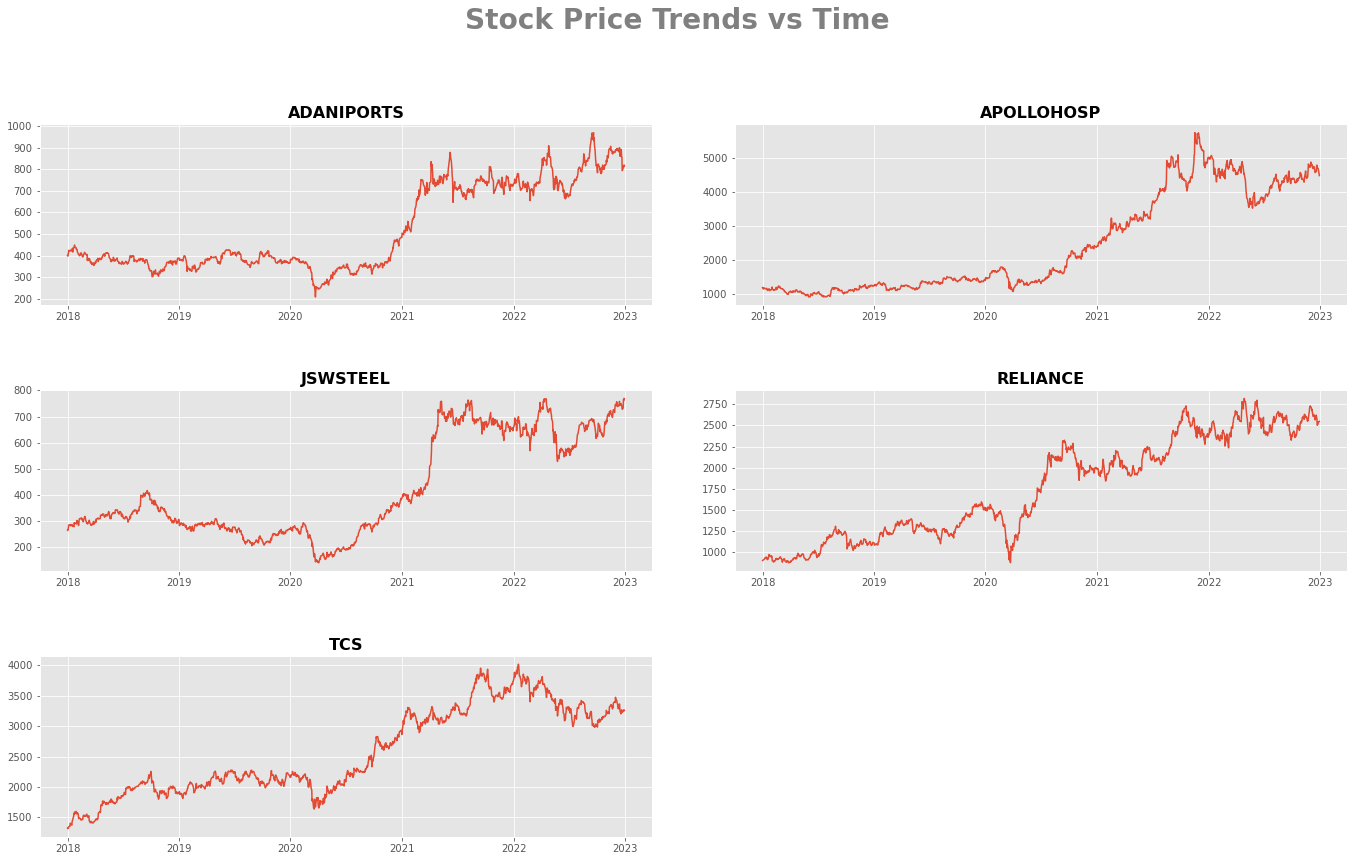

In [32]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Stock Price Trends vs Time',
             fontsize=28,
             fontweight='bold',
             color='grey')

for i, col in enumerate(labels):
    ax = fig.add_subplot(5,2,i+1)
    ax.plot(stocks_cl.index,
            stocks_cl[col])
    ax.set_title(col,
                 fontsize=16,
                 fontweight='bold')

fig.tight_layout(pad=5)
# plt.savefig('stocks.jpg')
plt.show()

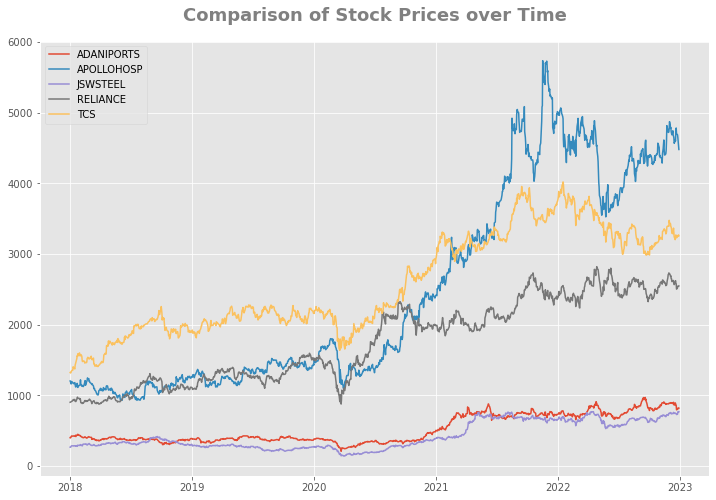

In [33]:
fig, ax = plt.subplots(figsize=(12,8))

ax.set_title('Comparison of Stock Prices over Time',
             color='grey',
             fontweight='bold',
             size=18,
             pad=20)

for col in labels:
    ax.plot(stocks_cl.index,
            stocks_cl[col],
            label=col)

ax.legend()

# plt.savefig('stocks2.jpg')
plt.show()

The time series plots of closing prices of all the stocks indicates that the stock price movements were fairly flat from the beginning of 2018 till the beginning of 2020. From the beginning of 2020 till the middle of 2020, the stock prices started falling, and hit the bottom around the first quarter of 2020. This period coincides with the outbreak of the global pandemic, and that perhaps is an explanation of the stock prices trend. From then onwards, the stock prices started rising again, and peaked around the end of 2021. Since then, stock prices have been fairly stable.

The combined plot provides a comparison of the closing prices of all the stocks against each other. While the direction of movements of the stock prices is quite similar, the actual prices are quite different. For example, <b>JSWSTEEL</b> stock prices fall in the 400 - 700 range while, <b>APOLLOHOSP</b> stock prices fall in the 1200 - 3000 range. This disparity implies that for a more accurate prediction, the stock prices need to be normalized before being fed to the prediction model. For this purpose, normalization will be employed.  

In [34]:
stocks_cln = stocks.filter(['Stock', 'Date', 'Close', 'Close_N', 'Month'])
stocks_cln.set_index('Date', inplace=True)
stocks_cln = stocks_cln.pivot(columns='Stock',
                          values=['Close_N'])

stocks_cln.head(7)

Close_N                                         
Stock      ADANIPORTS APOLLOHOSP  JSWSTEEL  RELIANCE       TCS
Date                                                          
2018-01-01   0.000000   0.000000  0.000000  0.000000  0.000000
2018-01-02  -0.005630  -0.008815 -0.004703  0.001539 -0.005443
2018-01-03   0.025793  -0.012962  0.015687  0.004006  0.002831
2018-01-04   0.005397  -0.013940  0.031448  0.006012  0.006992
2018-01-05   0.034037   0.031204  0.028685  0.003205  0.012081
2018-01-06  -0.000531  -0.003260  0.000789  0.001435  0.002343
2018-01-07  -0.000531  -0.003271  0.000789  0.001433  0.002337

In [35]:
stocks_cln.columns

MultiIndex([('Close_N', 'ADANIPORTS'),
            ('Close_N', 'APOLLOHOSP'),
            ('Close_N',   'JSWSTEEL'),
            ('Close_N',   'RELIANCE'),
            ('Close_N',        'TCS')],
           names=[None, 'Stock'])

In [36]:
stocks_cln.columns = [x for x in [col[1] for col in stocks_cln.columns.values]]
stocks_cln.head()

,ADANIPORTS,APOLLOHOSP,JSWSTEEL,RELIANCE,TCS
Date,,,,,
2018-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-02,-0.005630,-0.008815,-0.004703,0.001539,-0.005443
2018-01-03,0.025793,-0.012962,0.015687,0.004006,0.002831
2018-01-04,0.005397,-0.013940,0.031448,0.006012,0.006992
2018-01-05,0.034037,0.031204,0.028685,0.003205,0.012081


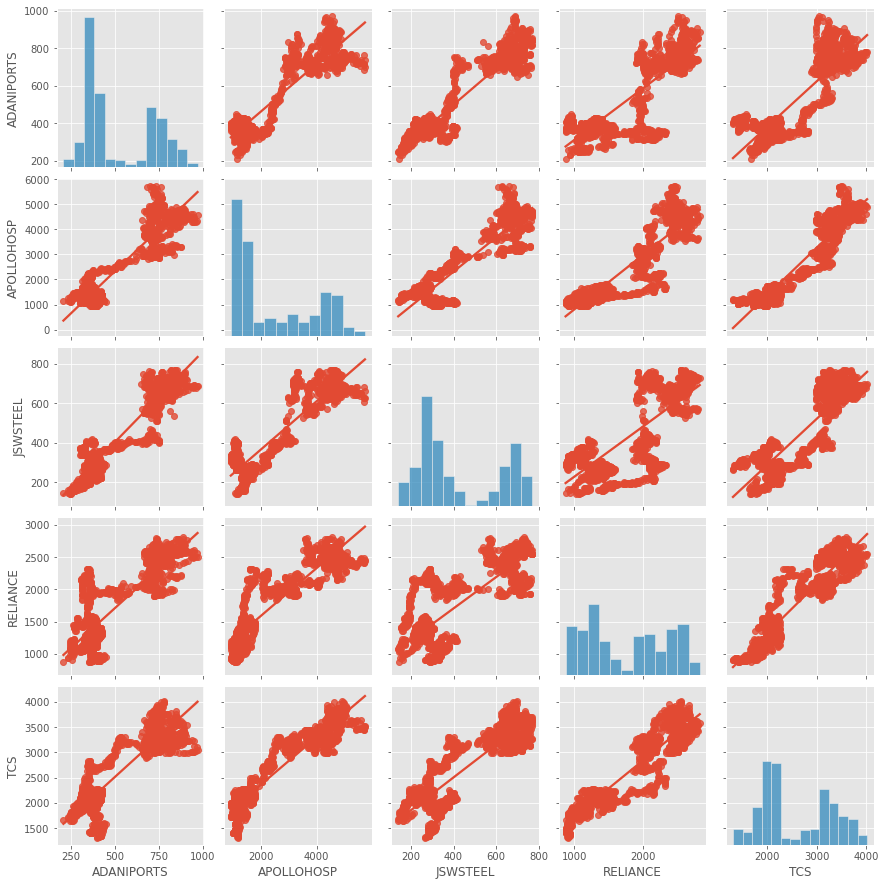

In [37]:
pplot = sns.pairplot(stocks_cl, 
                     kind='reg')

# plt.savefig('pplot.jpg')
plt.show()

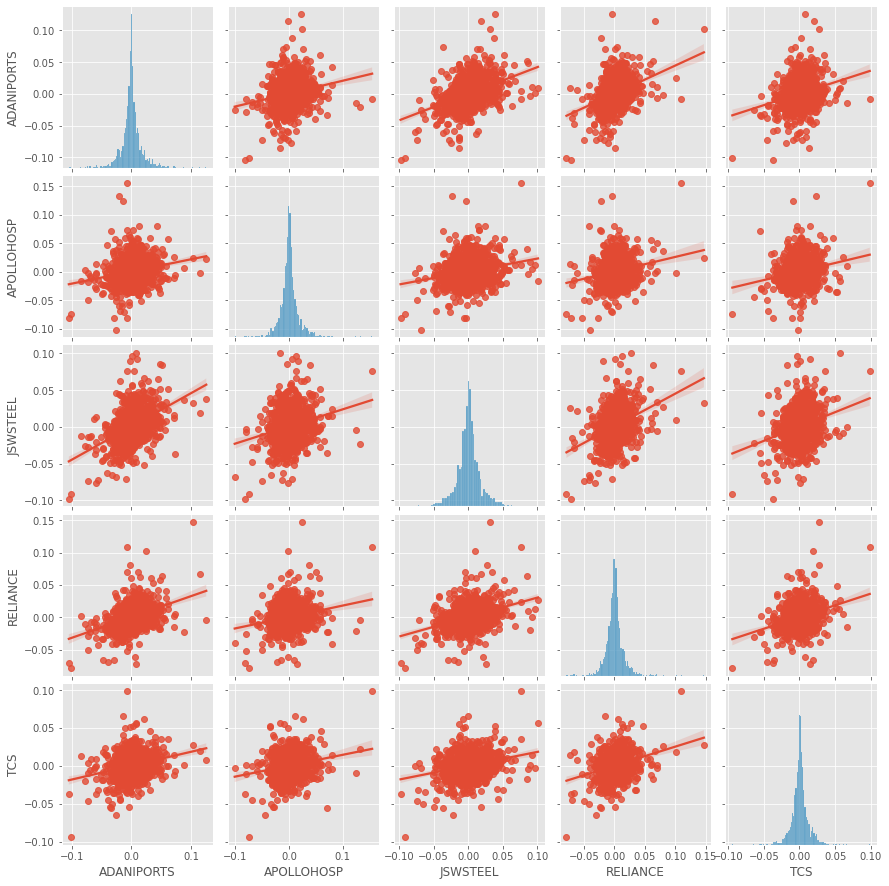

In [38]:
pplot = sns.pairplot(stocks_cln, 
                     kind='reg')

# plt.savefig('pplot2.jpg')
plt.show()

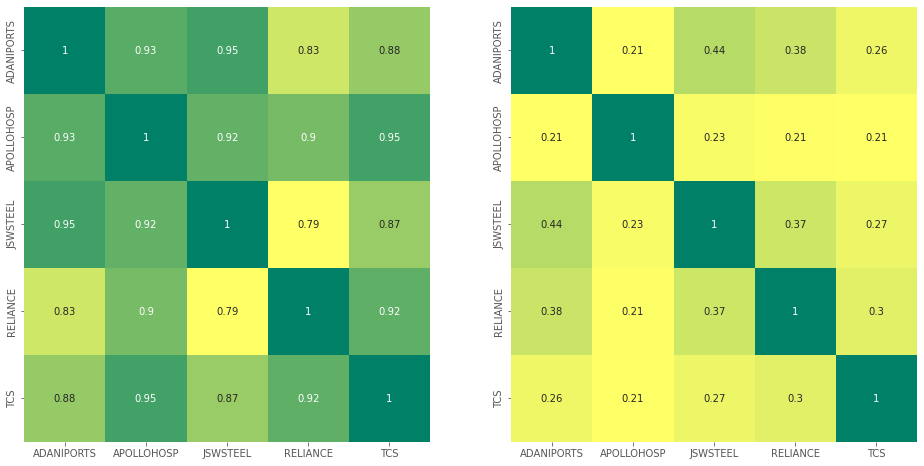

In [39]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

sns.heatmap(stocks_cl.corr(),
            annot=True,
            cmap='summer_r',
            cbar=False,
            ax = ax[0])

sns.heatmap(stocks_cln.corr(),
            annot=True,
            cmap='summer_r',
            cbar=False,
            ax = ax[1])

# plt.savefig('corr.jpg')
plt.show()

The above four plots - the pairplots between all the closing stock prices and the percentage changes in closing prices, and the correlation heat maps - show the correlation among the individual stock prices. 

<ul>
    <li>The first pairplot - between the closing prices of all the stocks - contains a fair amount of linearity in the scatter plots, which indicates that there exists some degree of correlation between the various stock prices.</li>
    <li>The non-linearity in the scatter plots in the second pairplot - between the percentage changes in the closing prices - indicates that there is only a weak correlation for this attribute between any pair of stocks.</li> 
    <li>The correlation heat map on the left - between the closing prices of all the stocks - shows a high degree of positive correlation (> 0.75) among the different stock prices. This observation reinforces the trend in the movement of stock prices observed earlier.</li>
    <li>In the correlation heat map on the right - between the percentage changes in the closing prices - it may be seen that all the values are > 0, but less than 0.5, which implies that there is only weak positive correlation between all pairs of stocks. The maximum correlation, at 0.44, can be observed between ADANIPORTS and JSWSTEEL, followed by 0.38 between ADANIPORTS and RELIANCE and 0.37 between JSWSTEEL and RELIANCE. All these values correspond to only weak positive correlation between the respective pairs of stocks.</li>
</ul>

### 2.2 Data Cleaning and Preprocessing on Tweets Data

As the sample data display of the tweets DataFrame and the DataFrame's columns list showed in the previous section, that the <b>"ID"</b> column was an integer type field. However, for the purpose of analysis, it is more suitable for the <b>"ID"</b> column to be a text field. Hence, the columns will be converted accordingly.

In [40]:
# Converting Date column from string to datetime and ID column from integer to string
news_twts_df["ID"] = news_twts_df["ID"].values.astype('object')

# Displaying sample data after above steps
news_twts_df.head()

,Date,ID,TwtsTxt,User
0,2018-12-31 13:41:04+00:00,1079734183411548161,From CNBC | Senator Elizabeth Warren launches ...,CNBCTV18Live
1,2018-12-31 13:02:48+00:00,1079724553775964165,#JustIn | @IndianOilcl to cut non-subsidised L...,CNBCTV18Live
2,2018-12-31 12:55:48+00:00,1079722793858547712,Kotak Mahindra Bank to CNBC-TV8: @KotakBankLtd...,CNBCTV18Live
3,2018-12-31 12:43:23+00:00,1079719666904252416,FIIs net sell Rs 326.87 cr &amp; DIIs net buy ...,CNBCTV18Live
4,2018-12-31 12:25:35+00:00,1079715187517620225,Core Sector Data | November steel output at 6%...,CNBCTV18Live


In [41]:
news_twts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875711 entries, 0 to 1875710
Data columns (total 4 columns):
 #   Column   Dtype              
---  ------   -----              
 0   Date     datetime64[ns, UTC]
 1   ID       object             
 2   TwtsTxt  object             
 3   User     object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 57.2+ MB


We will be using VADER (vaderSentiment) for sentiment analysis. Twitter content contains a lot of words and characters that are part of the social media lexicon but may not necessarily be part of the regular lexicon. Some of the charactristics of social media texts are - 

<ol>
    <li>presence of multimedia like images, videos, etc.</li>
    <li>presence of URLs</li>
    <li>presence of emojis</li>
    <li>capitalization of words</li>
    <li>truncation of words</li>
</ol>

VADER is a valence aware sentiment analyzer which is optimized for social media content. The VADER sentiment analyzer can interpret social media textual components. Therefore, no preprocessing is required in this case. 

========================================================================================================

## 3. Stock Price Prediction Based on Historical Prices

The prediction workflow will have the following steps - 

<ol>
    <li>Data preparation</li>
    <li>Train - test split</li>
    <li>Model building and training</li>
    <li>Prediction</li>
    <li>Evaluation of results</li>
    <li>Visualization of results</li>
</ol>

### 3.1 Data Preparation

In the data preparation step, the original dataset will be filtered in order to get the relevant data. The original dataset - pandas DataFrame 'stocks' - contains the stock prices for all the 5 stocks in consideration. As part of data preparation, the following steps will be performed - 

<ol>
    <li>The dataset will be filtered such that the resultant data contains only the closing price, and percentage change in closing price, along with the columns 'Stock', 'Date', and 'Month'.</li>
    <li><b><i>One-hot encoding</i></b> will be performed on the 'Stock' column as this is one of the features to be used while training the prediction model. The features obtained from One-hot encoding will be merged with the original dataset. In One-hot encoding, one of the generated features is dropped in order to avoid multicollinearity. Thus, for the 5 stocks, 4 new features will be generated.</li>
    <li>The data will be split into different subsets - each corresponding to one of the stocks - as the stock prices of each stock will be scaled individually.</li>
    <li>From each subset, the predictor variables will be separated from the target variable. Here, the predictor variables are - 'Close_N' (percentage change in closing price), 'Month' (month from the date), and the 4 dummy features obtained from One-hot encoding.</li> 
    <li>The closing prices in the filtered data will then be scaled using <b>RobustScaler()</b> method  from the scikitlearn library, so that the data is suitable for a LSTM network.</li>
</ol> 
    
These operations will be performed via the <b><i>FilterData</i></b>, <b><i>SplitFtrs</i></b>, and <b><i>ScaleData</i></b> functions. The FilterData function will take a dataframe and columns as inputs and return a subset of the original dataset. The SplitFtrs function will split the dataset into predictor variable arrays and target variable arrays respectively. The ScaleData function takes the filtered data as input, and returns a numpy array with the values scaled using RobustScaler() method.

In [42]:
def FilterData(df, cols):

    if not type(cols) is list:
        raise TypeError("A list expected  for argument 'cols'")
        return
    
    df_filt = df.filter(cols)
    return df_filt

In [43]:
def SplitFtrs(df, label, vals, cols):
 
    if not type(vals) is list:
        raise TypeError("Lists expected for argument 'vals'")
        return
    
    if not type(cols) is list:
        raise TypeError("Lists expected for argument 'cols'")
        return
    
    x_cl = df.loc[df['Stock'] == label, vals].values
    x_ftrs = df.loc[df['Stock'] == label, cols].values
    return x_cl, x_ftrs

In [44]:
def ScaleData(data):
    scaler = RobustScaler()
    data = scaler.fit_transform(data)
    return data, scaler

### 3.2 Train - Test Split

In this step, the scaled will be split into subsets to be used in training and testing phases respectively. The split will be performed according to the fraction specified for training data. For example, if the fraction specified is 0.9, then 90% of the scaled data will be used to train the model, and the remaining 10% will be used to test the model. The default split has been set to 0.80, i.e., if no values is specified, then 80% of the data will be used for training and 25% for testing. 

For the purpose of train - test split, the functions <b><i>CreateTrainData</i></b> and <b><i>CreateTestData</i></b> have been created. The CreateTrainData function takes the complete scaled data as input and returns the training subset of the features and output in accordance with the train-test split strategy. The CreateTestData takes the complete actual as input and returns the test subset of the features and output in accordance with the train-test split strategy.

Each sample of the training data contains the 6 aforementioned predictor variables, along with the previous 10 days' closing prices as input. The training data output is a single value corresponding to the specific day's closing price. All values in the training data are scaled as mentioned previously. Similarly, each sample of the test data contains the 6 aforementioned predictor variables, along with the previous 10 days' closing prices (scaled) as input, while the test data output is the actual closing price for the specific day (unscaled).  

In [45]:
def CreateTrainData(x, trn_data_len, time_steps):
    
    if not type(trn_data_len) is int:
        raise TypeError("Integer value expected for argument 'trn_data_len'")
        return
    
    if not type(time_steps) is int:
        raise TypeError("Integer value expected for argument 'time_steps'")
        return
    
    trn_data = x[0:trn_data_len, :]
    x_train = []
    y_train = []

    for i in range(time_steps, trn_data_len):
        x_train.append(trn_data[i-time_steps:i,:])
        y_train.append(trn_data[i,-1])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    y_train = np.reshape(y_train, (x_train.shape[0], 1))
    
    return x_train, y_train

In [46]:
def CreateTestData(x_y, x, trn_data_len, time_steps):
    
    if not type(trn_data_len) is int:
        raise TypeError("Integer value expected for argument 'trn_data_len'")
        return
    
    if not type(time_steps) is int:
        raise TypeError("Integer value expected for argument 'time_steps'")
        return
    
    test_data = x[trn_data_len - time_steps:, :]
    x_test = []
    y_test = x_y[trn_data_len:, :]

    for i in range(time_steps, len(test_data)):
        x_test.append(test_data[i-time_steps:i, :])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))
    
    return x_test, y_test

The PrepareData function takes the original dataframe, desired stock label, train-test split fraction (default value is set to 80% for training data), and returns the train and test subsets of data. The function calls the SplitFtrs, ScaleData, CreateTrainData, and CreateTestData functions to get the required output. The function also returns an instance of the scaler method, that has been used to fit the data.

In [47]:
def PrepareData(df, label, vals, cols, trn_data_pct=0.8, time_steps=10):
    
    print("\nPreparing data for",label)
    print("-------------------------------")
    
    x_val, x_ftrs = SplitFtrs(df, label, vals, cols)
    
    x_sc, scaler = ScaleData(x_val)
    
    x = np.concatenate((x_ftrs, x_sc), axis=1)
    print("Input data shape before train-test split:", x.shape)
    
    trn_data_len = int(np.ceil(len(x) * trn_data_pct))
    print("Training data length:", trn_data_len)
    tst_data_len = int(len(x) - trn_data_len)
    print("Test data length:", tst_data_len)
    
    x_train, y_train = CreateTrainData(x, trn_data_len, time_steps)
    print("Training input shape:", x_train.shape)
    print("Training output shape:", y_train.shape)
    
    x_test, y_test = CreateTestData(x_val, x, trn_data_len, time_steps)
    print("Test input shape:", x_test.shape)
    print("Test output shape:", y_test.shape)
    
    return x_train, y_train, x_test, y_test, scaler, trn_data_len, tst_data_len

<b>Filtering the original dataset with the columns - 'Date', 'Stock', 'Close', 'Close_N', 'Month'. </b>

In [48]:
st_cl = FilterData(stocks, ['Date', 'Stock', 'Close', 'Close_N', 'Month'])
st_cl.head()

,Date,Stock,Close,Close_N,Month
0,2018-01-01,ADANIPORTS,399.649994,0.000000,1
1,2018-01-02,ADANIPORTS,397.399994,-0.005630,1
2,2018-01-03,ADANIPORTS,407.649994,0.025793,1
3,2018-01-04,ADANIPORTS,409.850006,0.005397,1
4,2018-01-05,ADANIPORTS,423.799988,0.034037,1


In [49]:
st_cl.tail()

,Date,Stock,Close,Close_N,Month
9120,2022-12-26,TCS,3252.899902,0.003788,12
9121,2022-12-27,TCS,3259.500000,0.002029,12
9122,2022-12-28,TCS,3257.100098,-0.000736,12
9123,2022-12-29,TCS,3268.750000,0.003577,12
9124,2022-12-30,TCS,3256.699951,-0.003686,12


<b>Performing One-hot encoding on the filtered dataset</b>

In [50]:
ohe = OneHotEncoder(drop='first', sparse=False)
st_enc = ohe.fit_transform(st_cl[['Stock']])
st_enc = pd.DataFrame(st_enc, columns=ohe.get_feature_names_out())
st_enc.tail()

,Stock_APOLLOHOSP,Stock_JSWSTEEL,Stock_RELIANCE,Stock_TCS
9120,0.0,0.0,0.0,1.0
9121,0.0,0.0,0.0,1.0
9122,0.0,0.0,0.0,1.0
9123,0.0,0.0,0.0,1.0
9124,0.0,0.0,0.0,1.0


<b>Merging the One-hot encoding features with the actual data</b>

In [51]:
st_cl_enc = st_cl.merge(st_enc, left_index=True, right_index=True)
st_cl_enc.head()

,Date,Stock,Close,Close_N,Month,Stock_APOLLOHOSP,Stock_JSWSTEEL,Stock_RELIANCE,Stock_TCS
0,2018-01-01,ADANIPORTS,399.649994,0.000000,1,0.0,0.0,0.0,0.0
1,2018-01-02,ADANIPORTS,397.399994,-0.005630,1,0.0,0.0,0.0,0.0
2,2018-01-03,ADANIPORTS,407.649994,0.025793,1,0.0,0.0,0.0,0.0
3,2018-01-04,ADANIPORTS,409.850006,0.005397,1,0.0,0.0,0.0,0.0
4,2018-01-05,ADANIPORTS,423.799988,0.034037,1,0.0,0.0,0.0,0.0


In [52]:
st_cl_enc.tail()

,Date,Stock,Close,Close_N,Month,Stock_APOLLOHOSP,Stock_JSWSTEEL,Stock_RELIANCE,Stock_TCS
9120,2022-12-26,TCS,3252.899902,0.003788,12,0.0,0.0,0.0,1.0
9121,2022-12-27,TCS,3259.500000,0.002029,12,0.0,0.0,0.0,1.0
9122,2022-12-28,TCS,3257.100098,-0.000736,12,0.0,0.0,0.0,1.0
9123,2022-12-29,TCS,3268.750000,0.003577,12,0.0,0.0,0.0,1.0
9124,2022-12-30,TCS,3256.699951,-0.003686,12,0.0,0.0,0.0,1.0


The previous two cells show the values of the features obtained from One-hot encoding. The last 5 records correspond to the TCS stock, hence the column 'Stock_TCS' has a value 1, while all others have 0. The first 5 records have 0s in all the 4 features, as the first feature - 'Stock_ADANIPORTS' - was dropped.

In [53]:
x_trn_l = []
y_trn_l = []
x_tst_l = []
y_tst_l = []
scalers = []

ohe_cols = ['Date', 'Stock']
vals = ['Close']
cols = [x for x in st_cl_enc.columns if x not in vals and x not in ohe_cols]

for label in labels:
    x_trn, y_trn, x_tst, y_tst, sc, train_len, test_len = PrepareData(st_cl_enc, label, vals, cols)
    x_trn_l.append(x_trn)
    y_trn_l.append(y_trn)
    x_tst_l.append(x_tst)
    y_tst_l.append(y_tst)
    scalers.append(sc)
    
x_train = np.concatenate(x_trn_l, axis=0)
y_train = np.concatenate(y_trn_l, axis=0)
x_test = np.concatenate(x_tst_l, axis=0)
y_test = np.concatenate(y_tst_l, axis=0)

print("\nMerged Training input shape:", x_train.shape)
print("Merged Training output shape:", y_train.shape)
print("Merged Test input shape:", x_test.shape)
print("Merged Test output shape:", y_test.shape)


Preparing data for ADANIPORTS
-------------------------------
Input data shape before train-test split: (1825, 7)
Training data length: 1460
Test data length: 365
Training input shape: (1450, 10, 7)
Training output shape: (1450, 1)
Test input shape: (365, 10, 7)
Test output shape: (365, 1)

Preparing data for APOLLOHOSP
-------------------------------
Input data shape before train-test split: (1825, 7)
Training data length: 1460
Test data length: 365
Training input shape: (1450, 10, 7)
Training output shape: (1450, 1)
Test input shape: (365, 10, 7)
Test output shape: (365, 1)

Preparing data for JSWSTEEL
-------------------------------
Input data shape before train-test split: (1825, 7)
Training data length: 1460
Test data length: 365
Training input shape: (1450, 10, 7)
Training output shape: (1450, 1)
Test input shape: (365, 10, 7)
Test output shape: (365, 1)

Preparing data for RELIANCE
-------------------------------
Input data shape before train-test split: (1825, 7)
Training data

The model is going to take the previous 10 days' closing price, the name of the stock, and the month from the date as input features, and predict the closing price for the next day. This implies that each LSTM unit in the model that will be built will take an input of shape 10, and produce the output. However, since the data contains 5 different stocks, after the train-test split, the distribution of samples in training and test datasets may be skewed. Hence, instead of performing the train-test split on the complete dataset, the data for each stock was split according to the 80-20 proportion, and then all the individual training sets were merged. Therefore, each individual input, i.e., x_train and x_test, is a 3D array of shape 1450x10x7, where 1450 corresponds to the number of samples for each stock, and 10 corresponds to the number of timesteps that the LSTM will look back into, and 7 corresponds to the number of features. All these individual datasets are merged to get a single training dataset containing the data for all 5 stocks. Thus, the merged training inputs are arrays are of shape (7250x10x7). Similarly, the merged training output has the shape (7250x1). The test inputs and outputs are arrays of shape (1825x10x7) and (1825x1).

The following cells show sample data in each of the training and testing subsets.

In [54]:
# First and last training input samples 
x_train[[0,-1]]

array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.02546668e-02],
        [-5.62992627e-03,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.64905923e-02],
        [ 2.57926526e-02,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.19175126e-02],
        [ 5.39681648e-03,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.80148958e-02],
        [ 3.40367976e-02,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          5.66775829e-02],
        [-5.30907222e-04,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          5.60539946e-02],
        [-5.31189234e-04,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00

In [55]:
# First 5 training data outputs
y_train[0:5]

array([[0.0613892 ],
       [0.05529182],
       [0.05342106],
       [0.05155029],
       [0.04780876]])

In [56]:
# First and last test data input samples
x_test[[0,-1]]

array([[[ 3.40600869e-02,  1.20000000e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.93123018e-01],
        [-3.78996705e-03,  1.20000000e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.85501332e-01],
        [ 1.16898561e-02,  1.20000000e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          9.08920730e-01],
        [-1.21700582e-02,  1.20000000e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.84254282e-01],
        [ 2.76850694e-04,  1.20000000e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.84808578e-01],
        [ 2.76774069e-04,  1.20000000e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.85362874e-01],
        [ 5.53394973e-04,  1.20000000e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00

In [57]:
# First 5 test data outputs
y_test[0:5]

array([[730.29998779],
       [731.87498474],
       [733.44998169],
       [736.59997559],
       [739.25      ]])

It may be noted that while the x_train, y_train, and x_test arrays contain scaled values, the y_test array contains the original, unscaled values. The y_test will be used to evaluate the model performance, by comparing the y_test with the predicted values, after applying the inverse transformation on the predictions. 

### 3.3 Model Building, Fitting and Compilation

The model contains 3 LSTM layers. The first layer contains 10 units, i.e., the output space of the first LSTM layer has a dimensionality of 10. The second and third LSTM layers contain 5 units each. The first and second layers return their outputs and feed to the subsequent layer. For each LSTM layer, ReLU activation function is used. The LSTM layers are followed by a Dense layer containing 10 units. The final layer is another dense layer containing 1 unit. This LSTM model is built using the <b><i>BuildModel</i></b> function. 

Once built, the model is compiled and fit to the training data. For this purpose, 'ADAM' optimizer is used and 'mean squared error' is used as the loss function. For fitting the model, various batch sizes and number of epochs have been experimented with. The batch sizes used in the experiments are - 1, 32, 64, 128. These bact sizes have been run for 10, 25, and 30 epochs respectively. These operations are performed by the <b><i>FitModel</i></b> function.

In [58]:
def BuildModel(unit_i, unit_h, act_fn='relu'):
    
    model = Sequential()
    
    model.add(LSTM(units=unit_i,
                   activation=act_fn,
                   return_sequences=True,
                   input_shape=(x_train.shape[1], x_train.shape[2])))    
    
    model.add(LSTM(units=unit_h,
                   activation=act_fn,
                   return_sequences=True,
                   input_shape=(x_train.shape[1], x_train.shape[2])))    
    
    model.add(LSTM(units=unit_h,
                   activation=act_fn,
                   return_sequences=False))
      
    model.add(Dense(units=10))
        
    model.add(Dense(units=1))
    
    return model

In [59]:
def FitModel(model, x_train, y_train, opt='adam', loss='mean_squared_error', btc_size=64, epochs=25):
    
    model.compile(optimizer=opt,
                loss=loss)
    
    model.fit(x_train, 
              y_train, 
              batch_size=btc_size,
              epochs=epochs)
    
    return model

### 3.4 Prediction

After compiling and fitting the model with the training dataset, the model is used for predicting stock prices. The prediction step involves two operations - predicting values using the scaled data, and performing an inverse transform on the predicted values to get unscaled predictions. This is done using the <b><i>ModelPrediction</i></b> function.

In [60]:
def ModelPrediction(model, x_test, scaler):
    pred = model.predict(x_test)
    pred = scaler.inverse_transform(pred)
    
    return pred

### 3.5 Evaluation of the Model

The predicted values (after applying the inverse transform) are used to calculate the 'Root Mean Squared Error (RMSE)' and the 'Mean Absolute Percentage Error (MAPE)'. These metrics serve as the evaluation metrics for the model. The RMSE and MAPE are calculated as shown below -

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$ RMSE = \sqrt{\frac{(\sum \limits _{i=1} ^{n}(y_{i} - \hat{y}_{i})^{2})}{n}} $

and

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$ MAPE = \frac{\sum \limits _{i=1} ^{n}(\lvert(y_{i} - \hat{y}_{i})\rvert)}{n} * 100 $

where, $y_{i}$ = actual value, $\hat{y}_{i}$ = predicted value, and n is the number of test samples.

In [61]:
def EvaluateModel(pred, orig):
    rmse = np.sqrt(np.mean((pred - orig) ** 2))
    mape = np.mean((np.abs(pred - orig)/orig)) * 100

    return rmse, mape

### 3.6 Experimental Setup for Choosing Model Parameters

Now that all the necessary functions have been created, we will run some experiments in order to identify the best set of hyperparameters and the best model design. We will call each of the functions defined above with different sets of parameters, and observe the performance in each case. We will first build a model and train this model using different batch sizes and training epochs. From the results, we will choose the best pair of batch size and training epochs, and train the model with different activation functions. The activation giving the best results will be used to train a different model with these parameters. The model that gives the best values of the chosen evaluation metrics will be used for predictions.

#### 3.6.1 Experiments using Different Batch Sizes and No. of Training Epochs

In this experiment, following sets of batch size and no. of epochs will be used - 

<ul>
    <li><b>Batch Size:</b> [1, 32, 64, 128]</li>
    <li><b>No. of epochs:</b> [10, 25, 30]</li>
</ul>

Each combination of the above two parameters will be used to measure the performance of the model. Each combination will be executed 10 times, and the results will be plotted.

In [62]:
batches = [1, 32, 64, 128]
epochs = [10, 25, 30]

# The code below was executed and the results saved in a pickle file. 
# As the code takes a long time (> 11 hrs), the pickle file will be used for reusability.

# model = BuildModel(10, 5, 'relu')

# eval_exp = []
# i = 0

# start_time = time.time()

# while i < 10:
#     print("Iteration",i)
#     for btc in batches:
#         print("Batch Size:",btc)
#         for n in epochs:
#             print("No. of epochs:",n)
#             model = FitModel(model, 
#                              x_train, 
#                              y_train, 
#                              opt='adam', 
#                              loss='mean_squared_error', 
#                              btc_size=btc, 
#                              epochs=n)
            
#             for j, label in enumerate(labels):
#                 idx_l = j*test_len
#                 idx_h = idx_l + test_len
#                 y_pred = ModelPrediction(model,
#                                          x_test[idx_l:idx_h],
#                                          scalers[j])
#                 rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#                 mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#                 eval_exp.append([label, str(btc), str(n), rmse, mape])
#     i += 1

# end_time = time.time()
# print("Total time elapsed:", (end_time - start_time)/60, "minutes")

# eval_df = pd.DataFrame(eval_exp, 
#                        columns=['Stock',
#                                 'Batch Size',
#                                 '# Epochs',
#                                 'RMSE',
#                                 'MAPE'])

# # Saving results to file for future reuse
# eval_df.to_pickle("eval_df.pkl")
# eval_df.to_csv("E:\BITS - MTech DataScience\Semester - 4\Dissertation\Data\eval_df.csv")

# Loading saved results from pickle file
eval_df = pd.read_pickle('eval_df.pkl')

The above operation fits the model with different sets of parameters and saves the RMSE and MAPE in each case in a dataframe. Each combination of Batch Size and No. of Epochs was run 10 times, as the values predicted by the model vary from execution to execution due to the way the parameters are initialized. We will plot the results and identify the best combination of batch size and no. of epochs hyperparameters. 

Also, as indicated by the output, the whole experiment took more than 3 hours (> 700 minutes => ~11.5 hrs). Therefore, the results are being saved to a csv file as well as to a pickle file, so that the results can be reused later, if required.

In [63]:
eval_df.head()

,Stock,Batch Size,# Epochs,RMSE,MAPE
0,ADANIPORTS,1,10,14.403297,1.349361
1,APOLLOHOSP,1,10,89.361890,1.583629
2,JSWSTEEL,1,10,15.928771,2.034384
3,RELIANCE,1,10,35.056772,0.979268
4,TCS,1,10,42.908095,0.960667


In [64]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Stock       600 non-null    object 
 1   Batch Size  600 non-null    object 
 2   # Epochs    600 non-null    object 
 3   RMSE        600 non-null    float64
 4   MAPE        600 non-null    float64
dtypes: float64(2), object(3)
memory usage: 23.6+ KB


In [65]:
eval_df.groupby(['Stock', 'Batch Size', '# Epochs'])['RMSE'].median()

Stock       Batch Size  # Epochs
ADANIPORTS  1           10           33.946072
                        25           21.341688
                        30           20.943864
            128         10           39.869409
                        25           51.919908
                        30           46.765932
            32          10           27.287969
                        25           29.768430
                        30           26.496503
            64          10           31.061801
                        25           29.043917
                        30           31.615021
APOLLOHOSP  1           10          154.686660
                        25          128.945621
                        30          148.395258
            128         10          174.350843
                        25          176.132896
                        30          178.145384
            32          10          151.207704
                        25          209.208128
                        30 

In [66]:
print("Median RMSE for various Batch Size & # Epochs :", end=" ")
print()
print(eval_df.groupby(['Stock', 'Batch Size', '# Epochs'])['RMSE'].median())
print("\nMedian MAPE for various Batch Size & # Epochs:", end=" ")
print()
print(eval_df.groupby(['Stock', 'Batch Size', '# Epochs'])['MAPE'].median())

Median RMSE for various Batch Size & # Epochs : 
Stock       Batch Size  # Epochs
ADANIPORTS  1           10           33.946072
                        25           21.341688
                        30           20.943864
            128         10           39.869409
                        25           51.919908
                        30           46.765932
            32          10           27.287969
                        25           29.768430
                        30           26.496503
            64          10           31.061801
                        25           29.043917
                        30           31.615021
APOLLOHOSP  1           10          154.686660
                        25          128.945621
                        30          148.395258
            128         10          174.350843
                        25          176.132896
                        30          178.145384
            32          10          151.207704
                        2

The previous two cells show the median values of RMSE and MAPE for each stock grouped by Batch size and # Epochs, i.e., the median RMSE and MAPE values for each combination of Batch size and # Epochs. These results only show the median values in each case, while in fact the values are in the form of a distribution as the experiment was conducted in 10 iterations for each combination. The distributions are being plotted in the following cells, in the form of several box plots.  

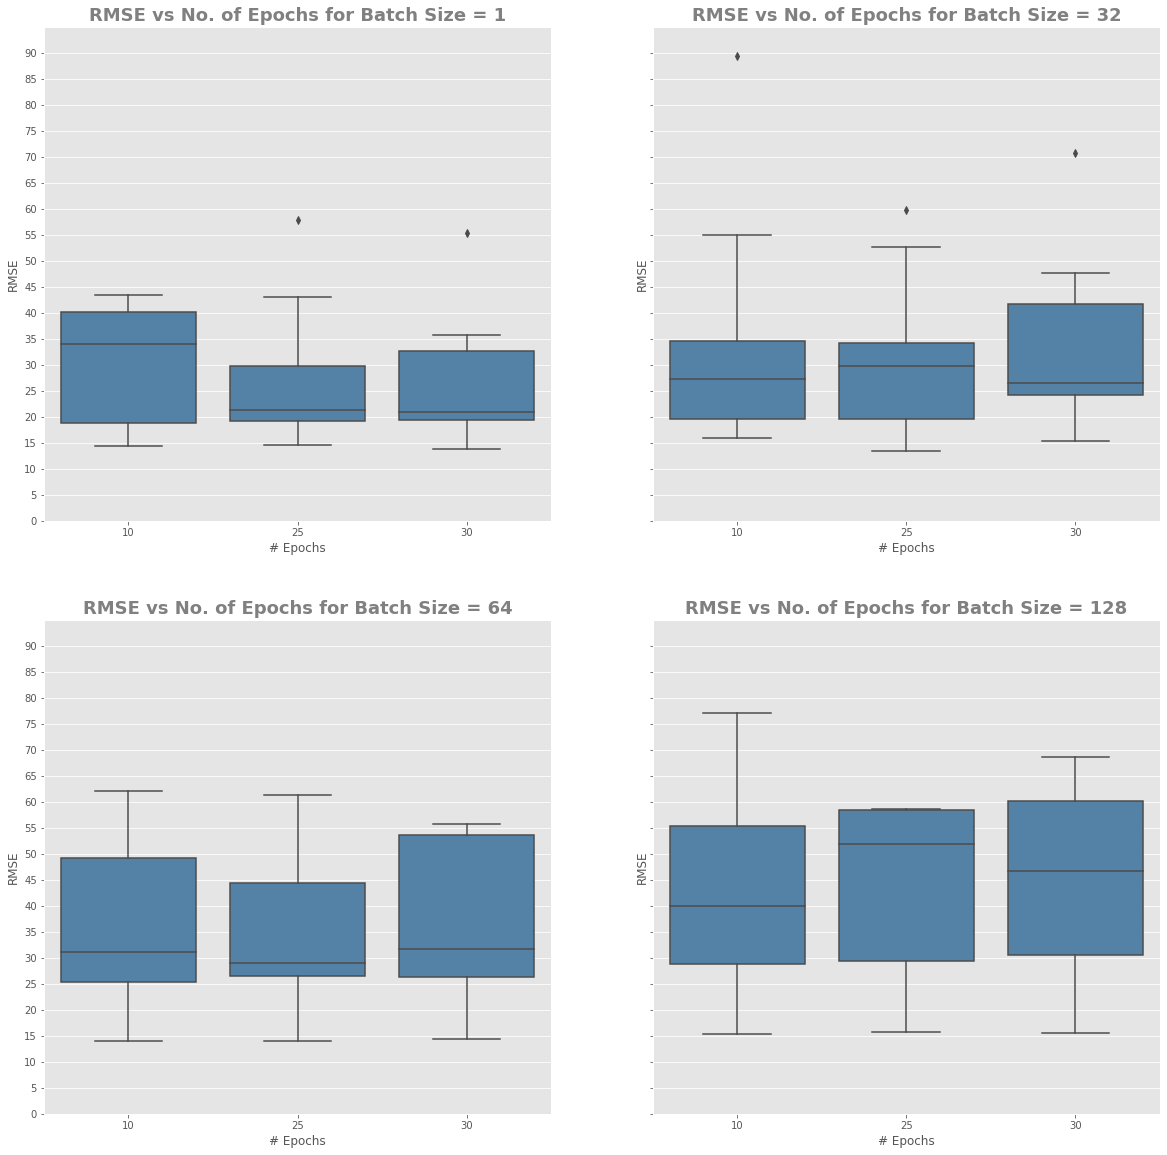

In [67]:
ctr = 0
fig, axes = plt.subplots(2,2,figsize=(20,20), sharey=True)

for i in range(2):
    for j in range(2):
        btc = str(batches[ctr])
        sns.boxplot(x='# Epochs',
                    y='RMSE',
                    data=eval_df.loc[(eval_df['Stock']==labels[0]) & (eval_df['Batch Size']==btc)],
                    ax=axes[i,j],
                    color='steelblue')
        title = "RMSE vs No. of Epochs for Batch Size = " + btc
        axes[i,j].set_title(title,
                              fontsize=18,
                              fontweight='bold',
                              color='grey')
        
        axes[i,j].set_ylim(0,95)
        axes[i,j].set_yticks(np.arange(0,95,5))
        ctr += 1
        
# plt.savefig("RMSEvsEpocs.jpg")
plt.show()

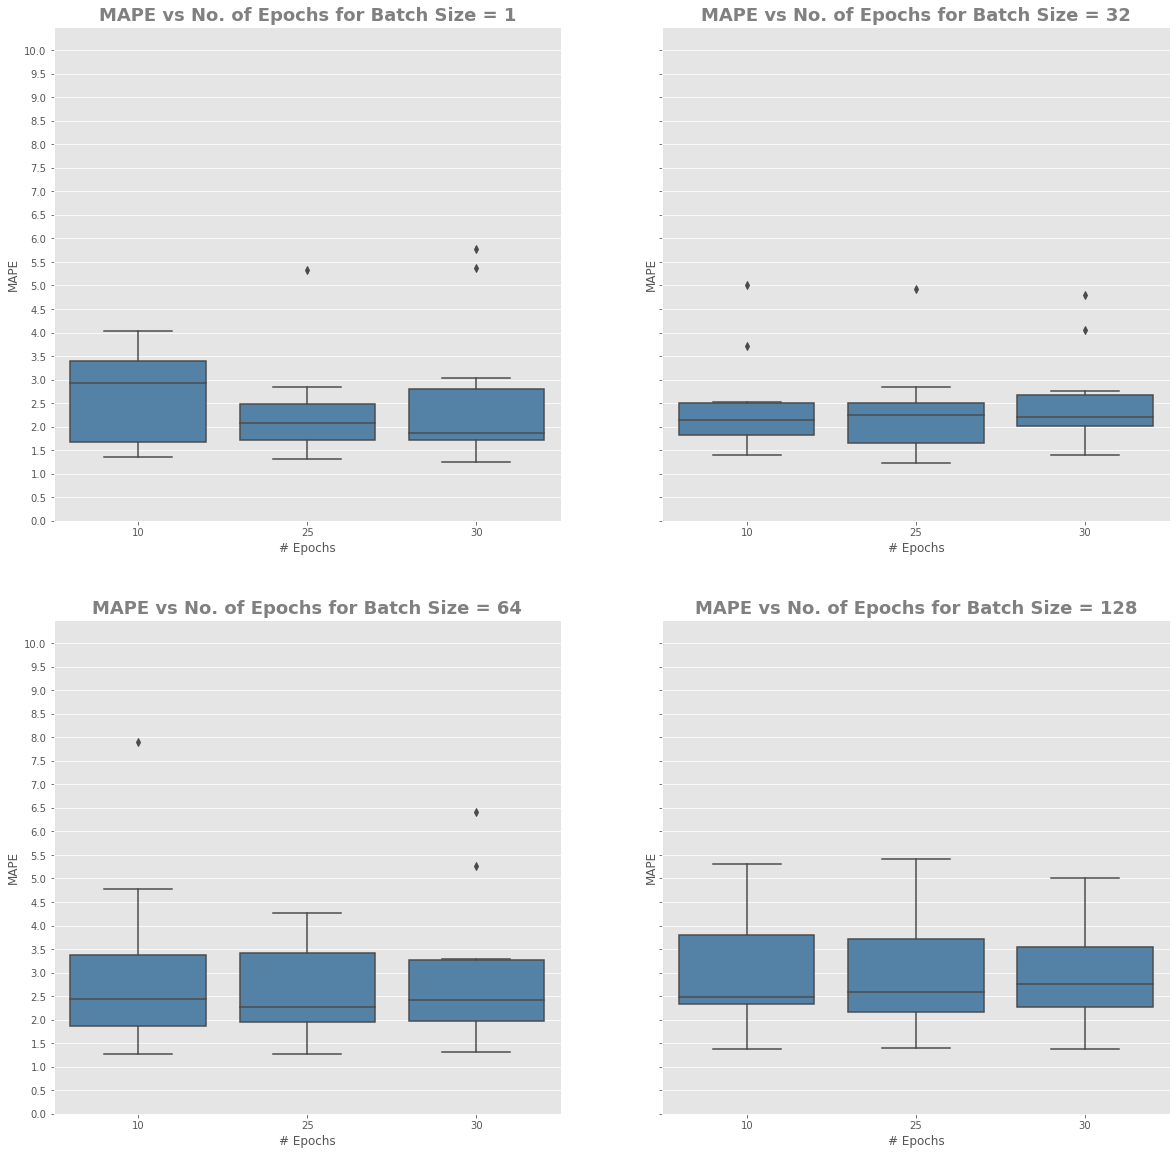

In [68]:
ctr = 0
fig, axes = plt.subplots(2,2,figsize=(20,20), sharey=True)

for i in range(2):
    for j in range(2):
        btc = str(batches[ctr])
        sns.boxplot(x='# Epochs',
                    y='MAPE',
                    data=eval_df.loc[(eval_df['Stock']==labels[0]) & (eval_df['Batch Size']==btc)],
                    ax=axes[i,j],
                    color='steelblue')
        
        title = "MAPE vs No. of Epochs for Batch Size = " + btc
        axes[i,j].set_title(title,
                              fontsize=18,
                              fontweight='bold',
                              color='grey')
        
        axes[i,j].set_ylim(0,10.5)
        axes[i,j].set_yticks(np.arange(0,10.5,0.5))
        ctr += 1

# plt.savefig("MAPEvsEpochs.jpg")
plt.show()

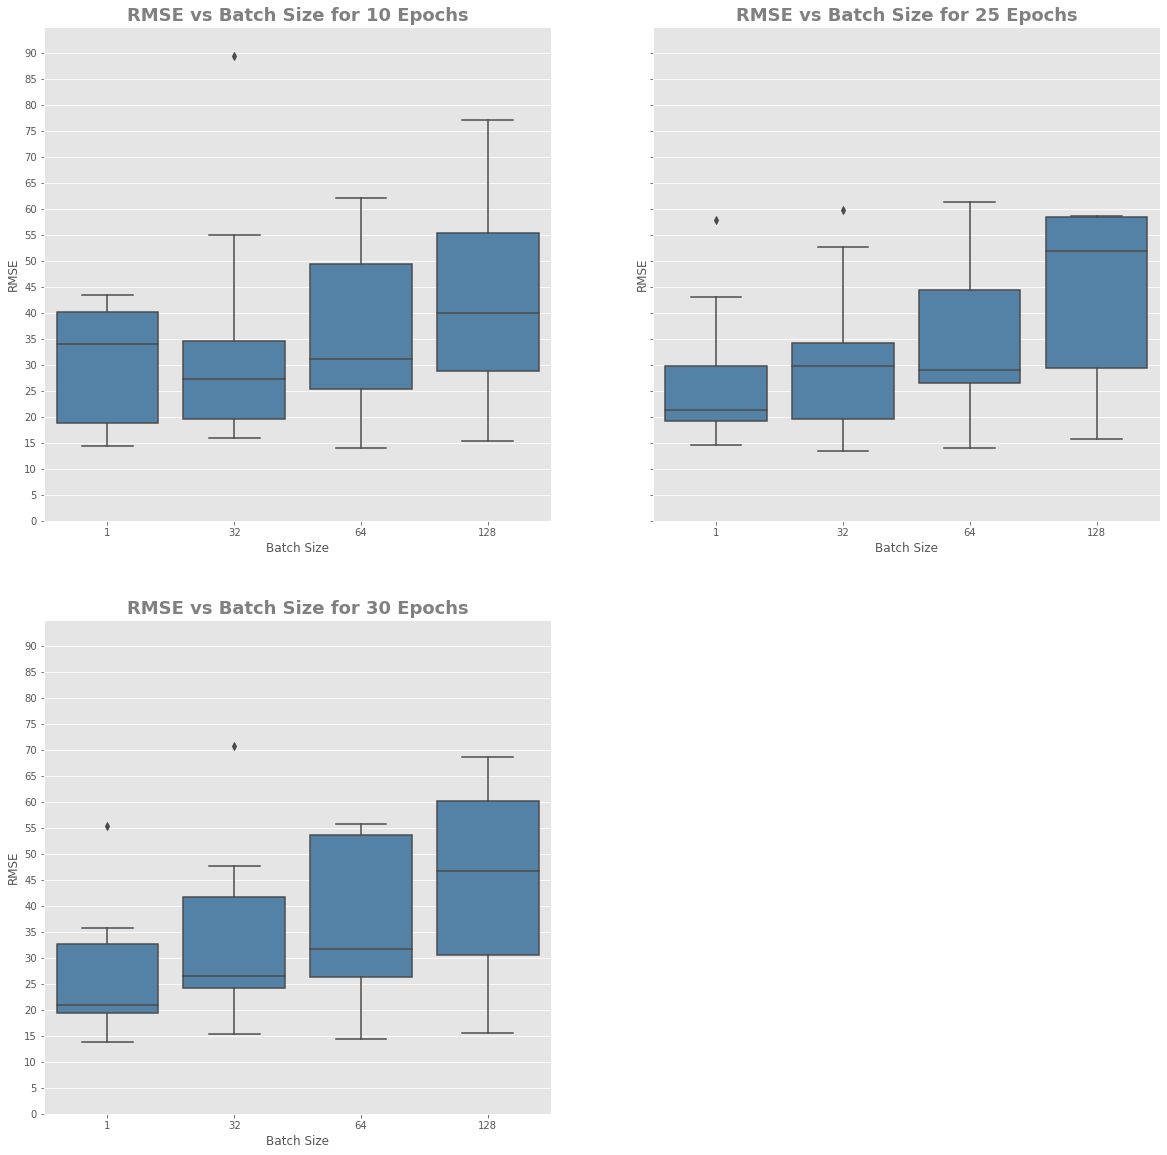

In [69]:
ctr = 0

fig, axes = plt.subplots(2,2,figsize=(20,20), sharey=True)

for i in range(2):
    for j in range(2):
        if ctr >= len(epochs):
            fig.delaxes(axes[i,j])
            break        
        n = str(epochs[ctr])
        sns.boxplot(x='Batch Size',
                    y='RMSE',
                    data=eval_df.loc[(eval_df['Stock']==labels[0]) & (eval_df['# Epochs']==n)],
                    ax=axes[i,j],
                    color='steelblue')
        
        title = "RMSE vs Batch Size for " + n + " Epochs"
        axes[i,j].set_title(title,
                              fontsize=18,
                              fontweight='bold',
                              color='grey')
        
        axes[i,j].set_ylim(0,95)
        axes[i,j].set_yticks(np.arange(0,95,5))
        ctr += 1
        
# plt.savefig("RMSEvsBatch.jpg")
plt.show()

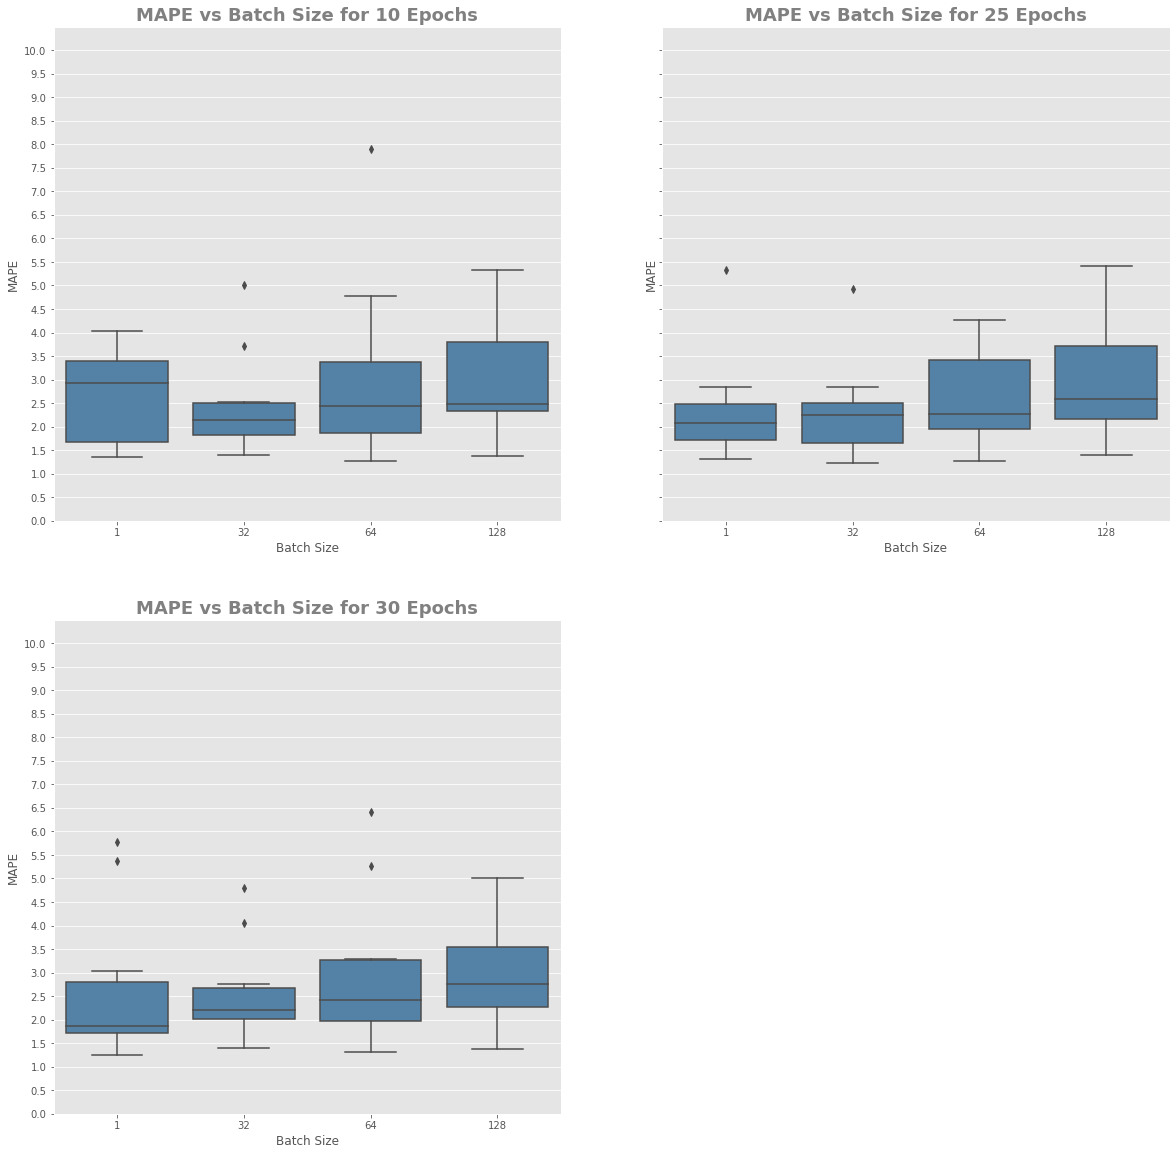

In [70]:
ctr = 0

fig, axes = plt.subplots(2,2,figsize=(20,20), sharey=True)

for i in range(2):
    for j in range(2):
        if ctr >= len(epochs):
            fig.delaxes(axes[i,j])
            break        
        n = str(epochs[ctr])
        sns.boxplot(x='Batch Size',
                    y='MAPE',
                    data=eval_df.loc[(eval_df['Stock']==labels[0]) & (eval_df['# Epochs']==n)],
                    ax=axes[i,j],
                    color='steelblue')
        
        title = "MAPE vs Batch Size for " + n + " Epochs"
        axes[i,j].set_title(title,
                              fontsize=18,
                              fontweight='bold',
                              color='grey')
        
        axes[i,j].set_ylim(0,10.5)
        axes[i,j].set_yticks(np.arange(0,10.5,0.5))
        ctr += 1
        
# plt.savefig("MAPEvsBatch.jpg")
plt.show()

The analysis of the 4 plots above provides the following observations - 

<ul>
    <li>The best RMSE was obtained with a batch size of 32 and 25 epochs.</li>
    <li>The RMSE values demonstrated maximum spread for batch size 1.</li>
    <li>Irrespective of the no. of epochs, batch size 1 had the worst performance.</li>
    <li>For the same no. of epochs, the least RMSE was observed for batch size 32.</li> 
    <li>The MAPE values showed very little variation.</li>
</ul>

Based on these observations, we can use a batch size of 32 and 25 epochs for training and making predictions with our model.

#### 3.6.2 Experiments using Different Activation Functions

We will use the same model with ReLU and TANH activation functions. From our previous experiment, we will use a batch size of 32 and 25 epochs for training.

In [71]:
# eval_act = []
# i = 0

# print("ReLU Activation Function")
# print()
# mod_relu = BuildModel(10, 5, 'relu')

# while i < 10:
#     print("Iteration", str(i+1),":")
#     mod_relu = FitModel(mod_relu, 
#                      x_train, 
#                      y_train, 
#                      opt='adam', 
#                      loss='mean_squared_error', 
#                      btc_size=32, 
#                      epochs=25)
            
#     for j, label in enumerate(labels):
#         idx_l = j*test_len
#         idx_h = idx_l + test_len
#         y_pred = ModelPrediction(mod_relu,
#                                  x_test[idx_l:idx_h],
#                                  scalers[j])
#         rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#         mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#         eval_act.append([label, 'RELU', rmse, mape])
        
#     i += 1
    
# print("Tanh Activation Function")
# print()

# i = 0
# mod_tanh = BuildModel(10, 5, 'tanh')

# while i < 10:
#     print("Iteration", str(i+1),":")
#     mod_tanh = FitModel(mod_tanh, 
#                         x_train, 
#                         y_train, 
#                         opt='adam', 
#                         loss='mean_squared_error', 
#                         btc_size=32, 
#                         epochs=25)
            
#     for j, label in enumerate(labels):
#         idx_l = j*test_len
#         idx_h = idx_l + test_len
#         y_pred = ModelPrediction(mod_tanh,
#                                  x_test[idx_l:idx_h],
#                                  scalers[j])
#         rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#         mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#         eval_act.append([label, 'TANH', rmse, mape])
        
#     i += 1
    
# eval_act_df = pd.DataFrame(eval_act, 
#                            columns=['Stock', 'Act_Fn', 'RMSE', 'MAPE'])

# # # Saving results to file for future reuse
# eval_act_df.to_pickle("eval_act_df.pkl")

# Loading saved results from pickle file
eval_act_df = pd.read_pickle('eval_act_df.pkl')

In [72]:
eval_act_df.head()

,Stock,Act_Fn,RMSE,MAPE
0,ADANIPORTS,RELU,18.228845,1.702392
1,APOLLOHOSP,RELU,156.939412,1.992434
2,JSWSTEEL,RELU,14.759377,1.539050
3,RELIANCE,RELU,49.919483,1.386910
4,TCS,RELU,73.022106,1.221714


In [73]:
print("Median RMSE for each Activation Function :", end=" ")
print(eval_act_df.groupby(['Stock', 'Act_Fn'])['RMSE'].median())
print("\nMedian MAPE for each Activation Function :", end=" ")
print(eval_act_df.groupby(['Stock', 'Act_Fn'])['MAPE'].median())

Median RMSE for each Activation Function : Stock       Act_Fn
ADANIPORTS  RELU       14.438896
            TANH       14.405109
APOLLOHOSP  RELU      105.986384
            TANH      135.738671
JSWSTEEL    RELU       12.450522
            TANH       12.019681
RELIANCE    RELU       34.050977
            TANH       34.978425
TCS         RELU       47.933314
            TANH       47.307818
Name: RMSE, dtype: float64

Median MAPE for each Activation Function : Stock       Act_Fn
ADANIPORTS  RELU      1.309864
            TANH      1.276982
APOLLOHOSP  RELU      1.769520
            TANH      2.240246
JSWSTEEL    RELU      1.428915
            TANH      1.358171
RELIANCE    RELU      0.940335
            TANH      0.974931
TCS         RELU      1.002757
            TANH      1.044754
Name: MAPE, dtype: float64


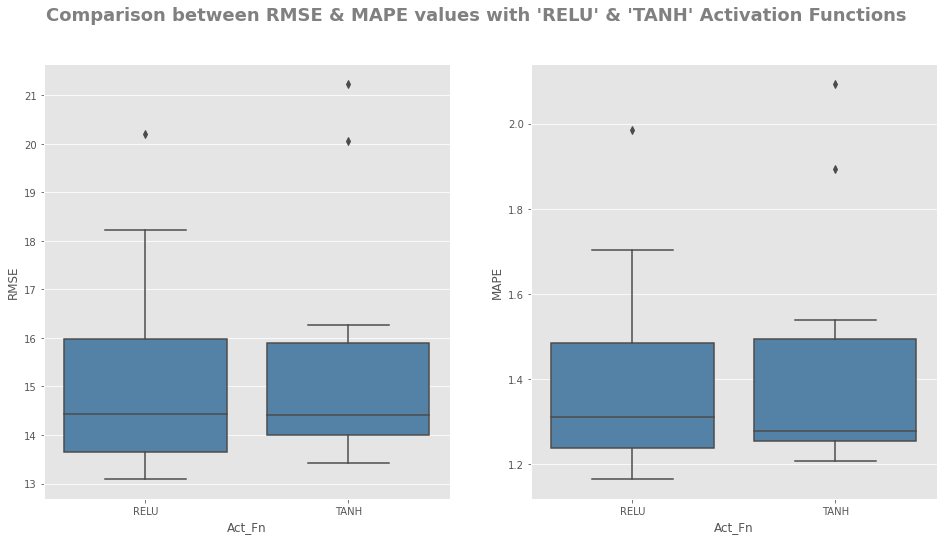

In [74]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

sns.boxplot(x='Act_Fn',
            y='RMSE',
            data=eval_act_df.loc[(eval_act_df['Stock']==labels[0])],
            ax=axes[0],
            color='steelblue')

sns.boxplot(x='Act_Fn',
            y='MAPE',
            data=eval_act_df.loc[(eval_act_df['Stock']==labels[0])],
            ax=axes[1],
            color='steelblue')
        
title = "Comparison between RMSE & MAPE values with 'RELU' & 'TANH' Activation Functions"

fig.suptitle(title,
             fontsize=18,
             fontweight='bold',
             color='grey')

# plt.savefig("Act_Fn.jpg")
plt.show()

The results above show that there is not much difference in the RMSE and MAPE values with ReLU or TANH activation functions. Therefore, we stick to the ReLU function as the activation function. 

#### 3.6.3 Experiments with Different Model Architectures

##### 3.6.3.1. Different Number of LSTM Layers - 3 hidden layers of 10 units each vs 4 hidden layers of 10 units each

In [75]:
def BuildModel2(unit_i, unit_h, act_fn='relu'):
    
    model = Sequential()
    
    model.add(LSTM(units=unit_i,
                   activation=act_fn,
                   return_sequences=True,
                   input_shape=(x_train.shape[1], x_train.shape[2])))
    
    model.add(LSTM(units=unit_i,
                   activation=act_fn,
                   return_sequences=True,
                   input_shape=(x_train.shape[1], x_train.shape[2])))    
    
    model.add(LSTM(units=unit_h,
                   activation=act_fn,
                   return_sequences=True,
                   input_shape=(x_train.shape[1], x_train.shape[2])))    
    
    model.add(LSTM(units=unit_h,
                   activation=act_fn,
                   return_sequences=False))
      
    model.add(Dense(units=10))
        
    model.add(Dense(units=1))
    
    return model

In [76]:
# eval_mod = []
# i = 0

# print("MODEL 1")
# print()
# model1 = BuildModel(10, 5, 'relu')

# while i < 10:
#     print("Iteration", str(i+1),":")
#     model1 = FitModel(model1, 
#                      x_train, 
#                      y_train, 
#                      opt='adam', 
#                      loss='mean_squared_error', 
#                      btc_size=32, 
#                      epochs=25)
            
#     for j, label in enumerate(labels):
#         idx_l = j*test_len
#         idx_h = idx_l + test_len
#         y_pred = ModelPrediction(model1,
#                                  x_test[idx_l:idx_h],
#                                  scalers[j])
#         rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#         mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#         eval_mod.append([label, 'MODEL1', rmse, mape])
        
#     i += 1
# i = 0

# print("MODEL 2")
# print()
# model2 = BuildModel2(10, 5, 'relu')

# while i < 10:
#     print("Iteration", str(i+1),":")
#     model2 = FitModel(model2, 
#                      x_train, 
#                      y_train, 
#                      opt='adam', 
#                      loss='mean_squared_error', 
#                      btc_size=32, 
#                      epochs=25)
            
#     for j, label in enumerate(labels):
#         idx_l = j*test_len
#         idx_h = idx_l + test_len
#         y_pred = ModelPrediction(model2,
#                                  x_test[idx_l:idx_h],
#                                  scalers[j])
#         rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#         mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#         eval_mod.append([label, 'MODEL2', rmse, mape])
        
#     i += 1
    
# eval_mod_df = pd.DataFrame(eval_mod, 
#                            columns=['Stock', 'Model', 'RMSE', 'MAPE'])

# # # Saving results to file for future reuse
# eval_mod_df.to_pickle("eval_mod_df.pkl")

# Loading saved results from pickle file
eval_mod_df = pd.read_pickle('eval_mod_df.pkl')    

In [77]:
eval_mod_df.head()

,Stock,Model,RMSE,MAPE
0,ADANIPORTS,MODEL1,18.168796,1.858927
1,APOLLOHOSP,MODEL1,206.010766,3.687536
2,JSWSTEEL,MODEL1,21.871843,2.738579
3,RELIANCE,MODEL1,45.011439,1.434470
4,TCS,MODEL1,63.680099,1.576901


In [78]:
print("Median RMSE for each Model :", end=" ")
print()
print(eval_mod_df.groupby(['Stock', 'Model'])['RMSE'].median())
print("\nMedian MAPE for each Model :", end=" ")
print()
print(eval_mod_df.groupby(['Stock', 'Model'])['MAPE'].median())

Median RMSE for each Model : 
Stock       Model 
ADANIPORTS  MODEL1     15.561944
            MODEL2     15.709148
APOLLOHOSP  MODEL1    164.128177
            MODEL2    156.356677
JSWSTEEL    MODEL1     13.448557
            MODEL2     19.462506
RELIANCE    MODEL1     37.601685
            MODEL2     40.290545
TCS         MODEL1     68.285782
            MODEL2     74.677483
Name: RMSE, dtype: float64

Median MAPE for each Model : 
Stock       Model 
ADANIPORTS  MODEL1    1.444079
            MODEL2    1.440707
APOLLOHOSP  MODEL1    2.452744
            MODEL2    2.320348
JSWSTEEL    MODEL1    1.531323
            MODEL2    2.052595
RELIANCE    MODEL1    1.129219
            MODEL2    1.142038
TCS         MODEL1    1.407331
            MODEL2    1.487339
Name: MAPE, dtype: float64


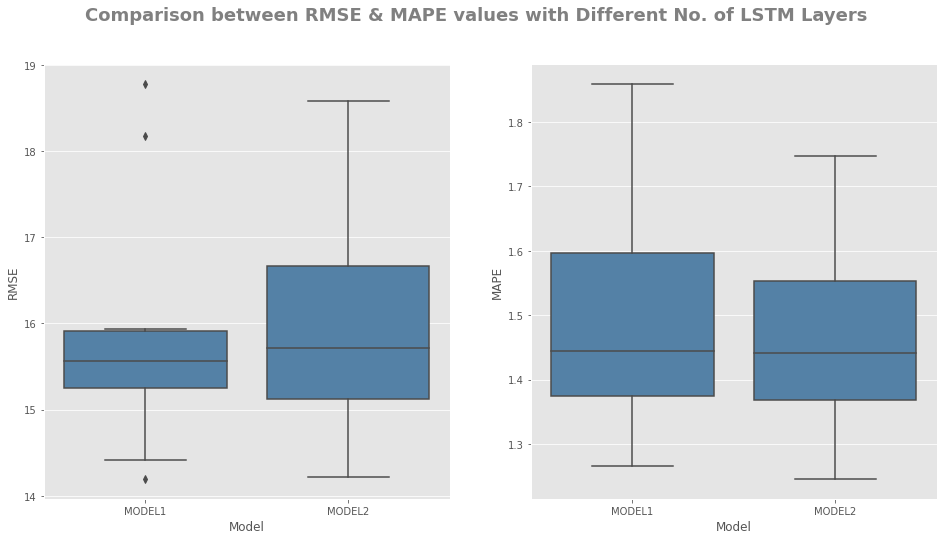

In [79]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

sns.boxplot(x='Model',
            y='RMSE',
            data=eval_mod_df.loc[(eval_mod_df['Stock']==labels[0])],
            ax=axes[0],
            color='steelblue')

sns.boxplot(x='Model',
            y='MAPE',
            data=eval_mod_df.loc[(eval_mod_df['Stock']==labels[0])],
            ax=axes[1],
            color='steelblue')
        
title = "Comparison between RMSE & MAPE values with Different No. of LSTM Layers"
fig.suptitle(title,
             fontsize=18,
             fontweight='bold',
             color='grey')

# plt.savefig("Model.jpg")
plt.show()

##### 3.6.3.2. Different Number of LSTM Units - 3 hidden layers with (10,5,5) units vs 3 hidden layers with (32,4,4) units

In [80]:
# eval_mod = []
# i = 0

# print("MODEL_10")
# print()
# mod10 = BuildModel(10, 5, 'relu')

# while i < 10:
#     print("Iteration", str(i+1),":")
#     mod10 = FitModel(mod10, 
#                      x_train, 
#                      y_train, 
#                      opt='adam', 
#                      loss='mean_squared_error', 
#                      btc_size=32, 
#                      epochs=25)
            
#     for j, label in enumerate(labels):
#         idx_l = j*test_len
#         idx_h = idx_l + test_len
#         y_pred = ModelPrediction(mod10,
#                                  x_test[idx_l:idx_h],
#                                  scalers[j])
#         rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#         mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#         eval_mod.append([label, 'MODEL10', rmse, mape])
        
#     i += 1
    
# i = 0

# print("MODEL_32")
# print()
# mod32 = BuildModel(32, 4, 'relu')

# while i < 10:
#     print("Iteration", str(i+1),":")
#     mod32 = FitModel(mod32, 
#                      x_train, 
#                      y_train, 
#                      opt='adam', 
#                      loss='mean_squared_error', 
#                      btc_size=32, 
#                      epochs=25)
            
#     for j, label in enumerate(labels):
#         idx_l = j*test_len
#         idx_h = idx_l + test_len
#         y_pred = ModelPrediction(mod32,
#                                  x_test[idx_l:idx_h],
#                                  scalers[j])
#         rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#         mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#         eval_mod.append([label, 'MODEL32', rmse, mape])
        
#     i += 1
    
# eval_mod1_df = pd.DataFrame(eval_mod, 
#                            columns=['Stock', 'Model', 'RMSE', 'MAPE'])

# # # Saving results to file for future reuse
# eval_mod1_df.to_pickle("eval_mod1_df.pkl")

# Loading saved results from pickle file
eval_mod1_df = pd.read_pickle('eval_mod1_df.pkl')    

In [81]:
eval_mod1_df.head()

,Stock,Model,RMSE,MAPE
0,ADANIPORTS,MODEL10,16.068369,1.460132
1,APOLLOHOSP,MODEL10,85.247838,1.466037
2,JSWSTEEL,MODEL10,15.044144,1.609106
3,RELIANCE,MODEL10,41.308815,1.272973
4,TCS,MODEL10,84.134429,1.524097


In [82]:
print("Median RMSE for each Model :", end=" ")
print()
print(eval_mod1_df.groupby(['Stock', 'Model'])['RMSE'].median())
print("\nMedian MAPE for each Model :", end=" ")
print()
print(eval_mod1_df.groupby(['Stock', 'Model'])['MAPE'].median())

Median RMSE for each Model : 
Stock       Model  
ADANIPORTS  MODEL10     17.332022
            MODEL32     18.151580
APOLLOHOSP  MODEL10    105.963844
            MODEL32    263.862849
JSWSTEEL    MODEL10     14.338562
            MODEL32     15.924750
RELIANCE    MODEL10     33.999661
            MODEL32     42.393097
TCS         MODEL10     72.200385
            MODEL32    146.253634
Name: RMSE, dtype: float64

Median MAPE for each Model : 
Stock       Model  
ADANIPORTS  MODEL10    1.589803
            MODEL32    1.650437
APOLLOHOSP  MODEL10    1.734404
            MODEL32    3.864519
JSWSTEEL    MODEL10    1.625890
            MODEL32    1.868592
RELIANCE    MODEL10    0.961389
            MODEL32    1.264928
TCS         MODEL10    1.379961
            MODEL32    2.533156
Name: MAPE, dtype: float64


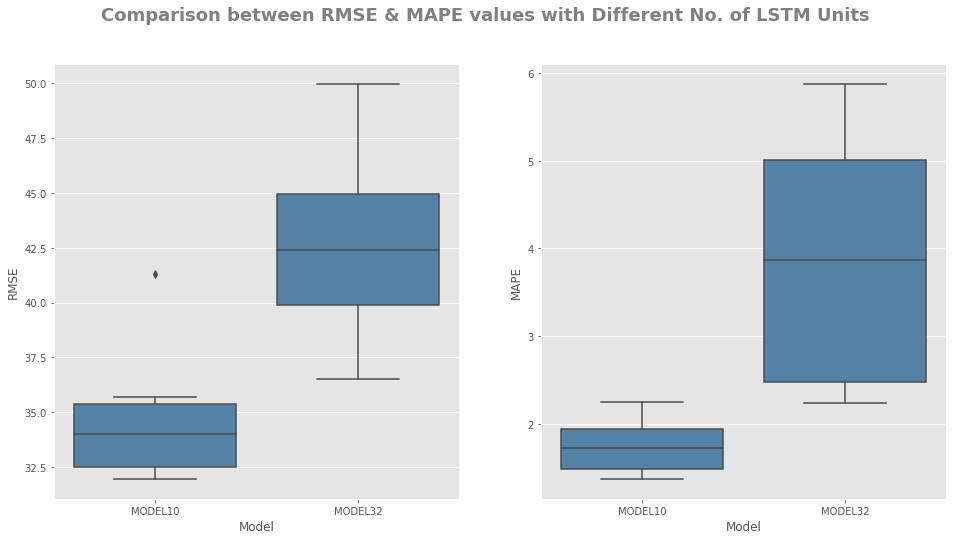

In [83]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

sns.boxplot(x='Model',
            y='RMSE',
            data=eval_mod1_df.loc[(eval_mod1_df['Stock']==labels[3])],
            ax=axes[0],
            color='steelblue')

sns.boxplot(x='Model',
            y='MAPE',
            data=eval_mod1_df.loc[(eval_mod1_df['Stock']==labels[1])],
            ax=axes[1],
            color='steelblue')
        
title = "Comparison between RMSE & MAPE values with Different No. of LSTM Units"
fig.suptitle(title,
             fontsize=18,
             fontweight='bold',
             color='grey')

# plt.savefig("Model1.jpg")
plt.show()

##### 3.6.3.3. Different Number of LSTM Units - 4 hidden layers with (10,10,5,5) units vs 4 hidden layers with (32,32,4,4) units

In [84]:
# eval_mod = []
# i = 0

# print("MODEL_10")
# print()
# mod_10 = BuildModel2(10, 5, 'relu')

# while i < 10:
#     print("Iteration", str(i+1),":")
#     mod_10 = FitModel(mod_10, 
#                      x_train, 
#                      y_train, 
#                      opt='adam', 
#                      loss='mean_squared_error', 
#                      btc_size=32, 
#                      epochs=25)
            
#     for j, label in enumerate(labels):
#         idx_l = j*test_len
#         idx_h = idx_l + test_len
#         y_pred = ModelPrediction(mod_10,
#                                  x_test[idx_l:idx_h],
#                                  scalers[j])
#         rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#         mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#         eval_mod.append([label, 'MODEL10', rmse, mape])
        
#     i += 1
    
# i = 0

# print("MODEL_32")
# print()
# mod_32 = BuildModel2(32, 4, 'relu')

# while i < 10:
#     print("Iteration", str(i+1),":")
#     mod_32 = FitModel(mod_32, 
#                      x_train, 
#                      y_train, 
#                      opt='adam', 
#                      loss='mean_squared_error', 
#                      btc_size=32, 
#                      epochs=25)
            
#     for j, label in enumerate(labels):
#         idx_l = j*test_len
#         idx_h = idx_l + test_len
#         y_pred = ModelPrediction(mod_32,
#                                  x_test[idx_l:idx_h],
#                                  scalers[j])
#         rmse = np.sqrt(np.mean((y_pred - y_test[idx_l:idx_h]) ** 2))
#         mape = np.mean(np.abs((y_pred - y_test[idx_l:idx_h])/y_test[idx_l:idx_h])) * 100
#         eval_mod.append([label, 'MODEL32', rmse, mape])
        
#     i += 1
    
# eval_mod2_df = pd.DataFrame(eval_mod, 
#                             columns=['Stock', 'Model', 'RMSE', 'MAPE'])

# # # # Saving results to file for future reuse
# eval_mod2_df.to_pickle("eval_mod2_df.pkl")

# Loading saved results from pickle file
eval_mod2_df = pd.read_pickle('eval_mod2_df.pkl')    

In [85]:
eval_mod2_df.head()

,Stock,Model,RMSE,MAPE
0,ADANIPORTS,MODEL10,15.983988,1.487198
1,APOLLOHOSP,MODEL10,123.800445,1.883268
2,JSWSTEEL,MODEL10,13.375265,1.534067
3,RELIANCE,MODEL10,51.128585,1.494778
4,TCS,MODEL10,96.948742,2.234519


In [86]:
print("Median RMSE for each Model :", end=" ")
print()
print(eval_mod2_df.groupby(['Stock', 'Model'])['RMSE'].median())
print("\nMedian MAPE for each Model :", end=" ")
print()
print(eval_mod2_df.groupby(['Stock', 'Model'])['MAPE'].median())

Median RMSE for each Model : 
Stock       Model  
ADANIPORTS  MODEL10     15.380315
            MODEL32     16.943119
APOLLOHOSP  MODEL10     82.223273
            MODEL32    149.779432
JSWSTEEL    MODEL10     12.630841
            MODEL32     13.825778
RELIANCE    MODEL10     34.779475
            MODEL32     46.881280
TCS         MODEL10     50.815536
            MODEL32     68.764507
Name: RMSE, dtype: float64

Median MAPE for each Model : 
Stock       Model  
ADANIPORTS  MODEL10    1.403052
            MODEL32    1.569434
APOLLOHOSP  MODEL10    1.331025
            MODEL32    2.279999
JSWSTEEL    MODEL10    1.484387
            MODEL32    1.621825
RELIANCE    MODEL10    0.973378
            MODEL32    1.306207
TCS         MODEL10    1.032327
            MODEL32    1.426507
Name: MAPE, dtype: float64


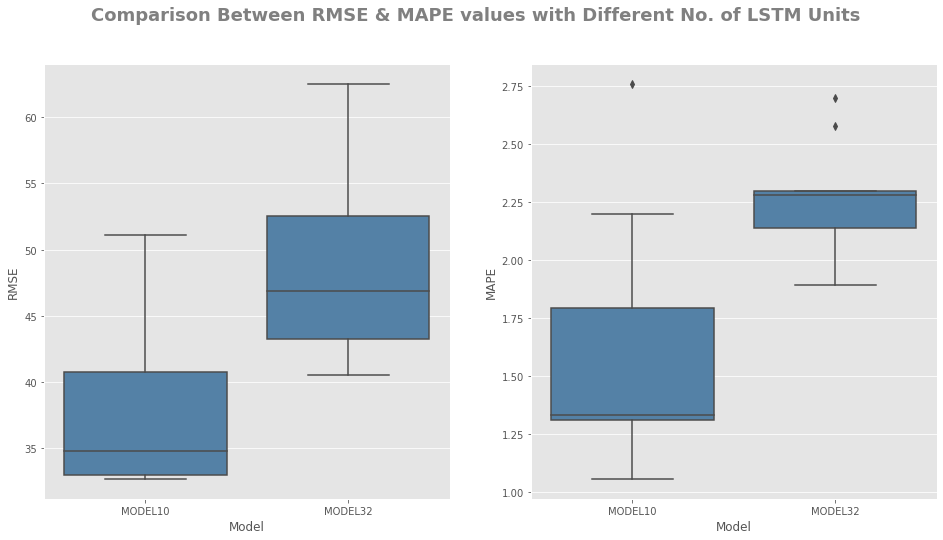

In [87]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

sns.boxplot(x='Model',
            y='RMSE',
            data=eval_mod2_df.loc[(eval_mod2_df['Stock']==labels[3])],
            ax=axes[0],
            color='steelblue')

sns.boxplot(x='Model',
            y='MAPE',
            data=eval_mod2_df.loc[(eval_mod2_df['Stock']==labels[1])],
            ax=axes[1],
            color='steelblue')
        
title = "Comparison Between RMSE & MAPE values with Different No. of LSTM Units"
fig.suptitle(title,
             fontsize=18,
             fontweight='bold',
             color='grey')

# plt.savefig("Model2.jpg")
plt.show()

### 3.7 Visualizing the Results

In this section, we will plot the predicted values for each stock and compare them against the respective actual values. 2 plots will be plotted for each stock - 1. Comparison between the values predicted on the test dataset vs the actual values in the test dataset, and 2. Comparison between the actual and predicted values over the entire dataset.

In [88]:
rmse_l = []
mape_l = []
y_preds = []

# Training samples
trn_len = train_len - 10
train = stocks_cl[:trn_len].copy()

# Test samples
valid = stocks_cl[train_len:].copy()

# Commented as model will be loaded from saved pickle file
# model = BuildModel(10, 5, 'relu')
# model = FitModel(model, 
#                  x_train, 
#                  y_train, 
#                  opt='adam', 
#                  loss='mean_squared_error', 
#                  btc_size=32, 
#                  epochs=25)

# Saving the trained model to pickle file for future reuse
# pickle.dump(model, open("base_model.pkl", 'wb'))

# Loading the pre-trained model from saved pickle file
model = pickle.load(open('base_model.pkl', 'rb'))

# Predictions
for i, label in enumerate(labels):
    idx_l = i*test_len
    idx_h = idx_l + test_len
    y_pred = ModelPrediction(model,
                             x_test[idx_l:idx_h],
                             scalers[i])
    
    y_preds.append(y_pred)
    
    rmse, mape = EvaluateModel(y_pred, y_test[idx_l:idx_h])
    print("\nStock:", label)
    print("RMSE =", rmse)
    print("MAPE =", mape)
    rmse_l.append(rmse)
    mape_l.append(mape)

metrics_df = pd.DataFrame(zip(labels, rmse_l, mape_l), 
                          columns=['Stock', 'RMSE', 'MAPE'])

model.summary()

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-20 00:09:52         3938
metadata.json                                  2023-02-20 00:09:52           64
variables.h5                                   2023-02-20 00:09:52        53496
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\lstm_2
......vars
...layers\lstm_2\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
....

In [89]:
metrics_df

,Stock,RMSE,MAPE
0,ADANIPORTS,19.672577,1.785773
1,APOLLOHOSP,254.794712,3.539566
2,JSWSTEEL,13.196724,1.505702
3,RELIANCE,41.778531,1.237540
4,TCS,111.180586,1.846280


#### 3.7.1. Visualizing Results for 'ADANIPORTS'

In [90]:
valid.loc[:,'Pred'] = y_preds[0]

pred_train = model.predict(x_train[:trn_len])
pred_train = scalers[0].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[0])
acts = np.append(train[labels[0]].values, y_test[:test_len])

46/46 [==============================] - 0s 7ms/step


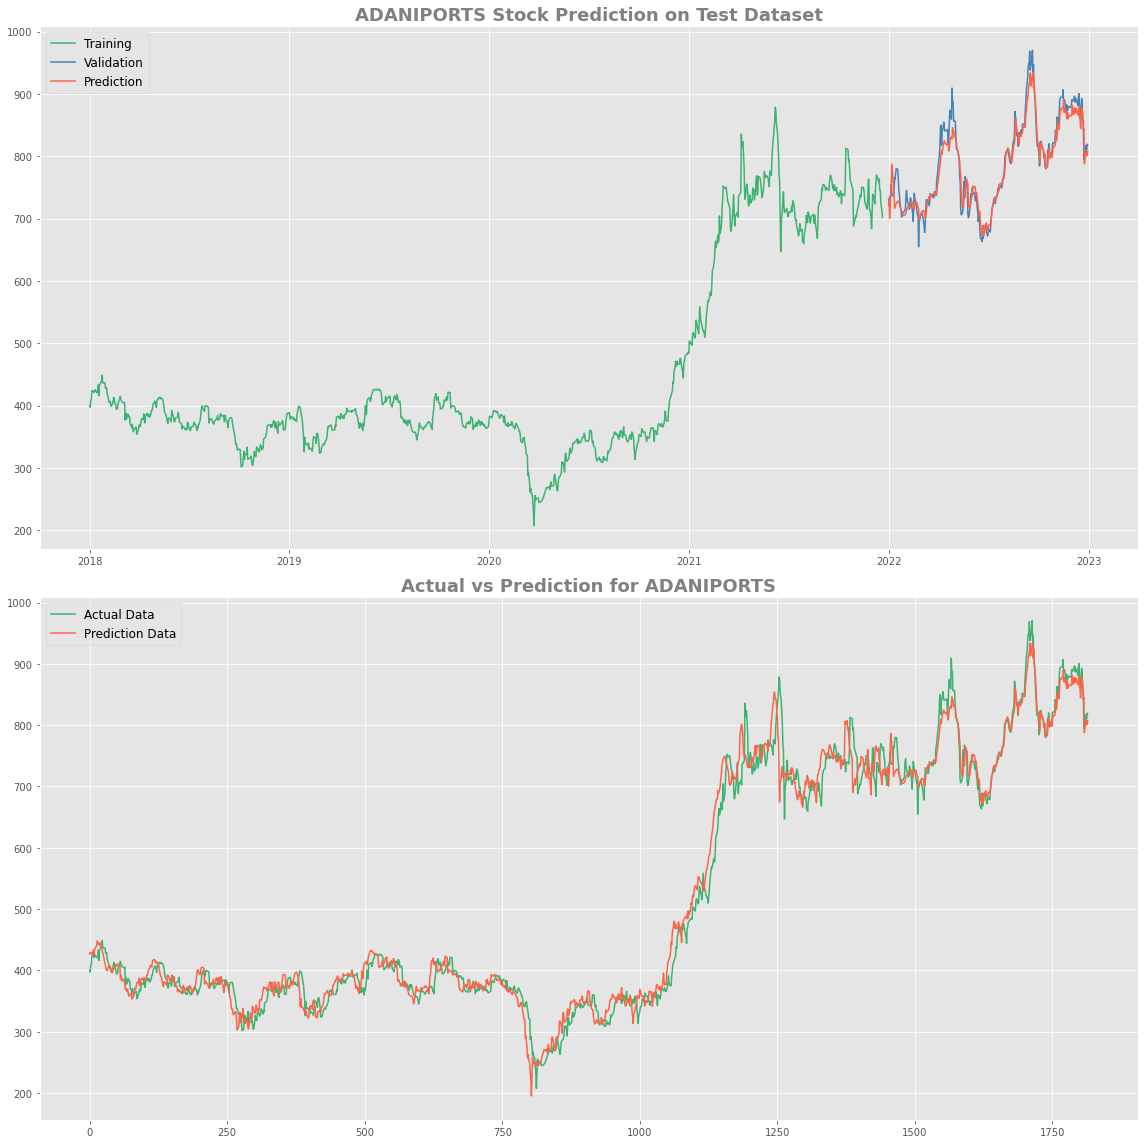

In [91]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[0] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[0]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[0]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[0]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("ADANIPORTS.jpg")
plt.show()

The model has a RMSE of 32.55 and a MAPE of 3.22. The above 2 plots show that our prediction model performs fairly well in general. However, at steep rises / falls, the model is not as accurate. Also, in some parts of the plot, the prediction line runs parallel to the actual line, indicating that while the general direction of the predicted values are correct, the values are different. 

#### 3.7.2. Visualizing Results for 'APOLLOHOSP'

In [92]:
valid.loc[:,'Pred'] = y_preds[1]

trn_idx_l = trn_len
trn_idx_h = trn_idx_l + trn_len
tst_idx_l = test_len
tst_idx_h = tst_idx_l + test_len

pred_train = model.predict(x_train[trn_idx_l:trn_idx_h])
pred_train = scalers[1].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[1])
acts = np.append(train[labels[1]].values, y_test[tst_idx_l:tst_idx_h])

46/46 [==============================] - 0s 7ms/step


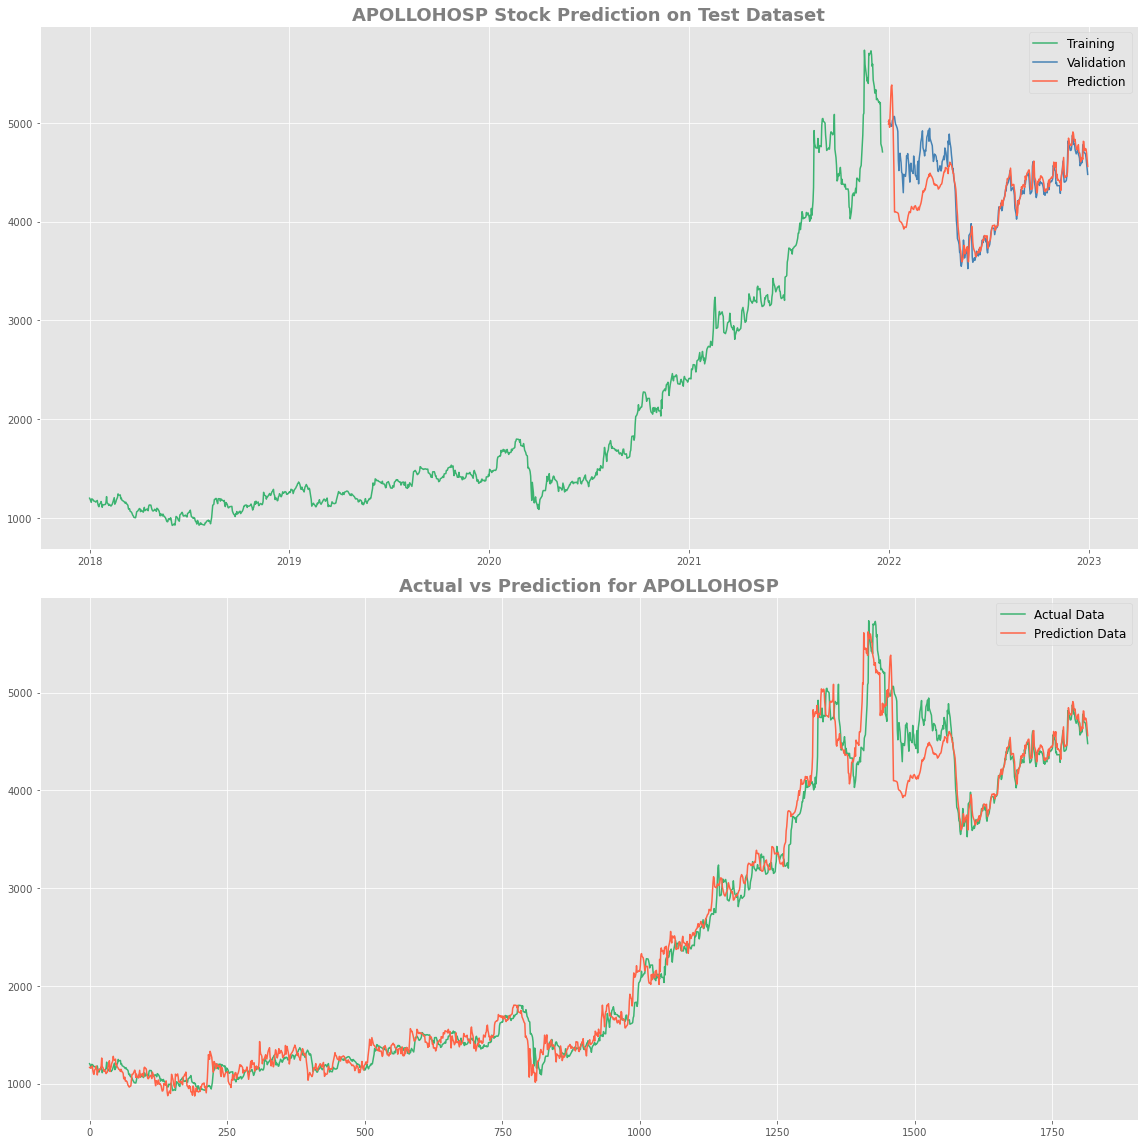

In [93]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[1] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[1]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[1]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[1]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("APOLLOHOSP.jpg")
plt.show()

#### 3.7.3. Visualizing Results for 'JSWSTEEL'

In [94]:
valid.loc[:,'Pred'] = y_preds[2]

trn_idx_l = 2*trn_len
trn_idx_h = trn_idx_l + trn_len
tst_idx_l = 2*test_len
tst_idx_h = tst_idx_l + test_len

pred_train = model.predict(x_train[trn_idx_l:trn_idx_h])
pred_train = scalers[2].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[2])
acts = np.append(train[labels[2]].values, y_test[tst_idx_l:tst_idx_h])

46/46 [==============================] - 0s 7ms/step


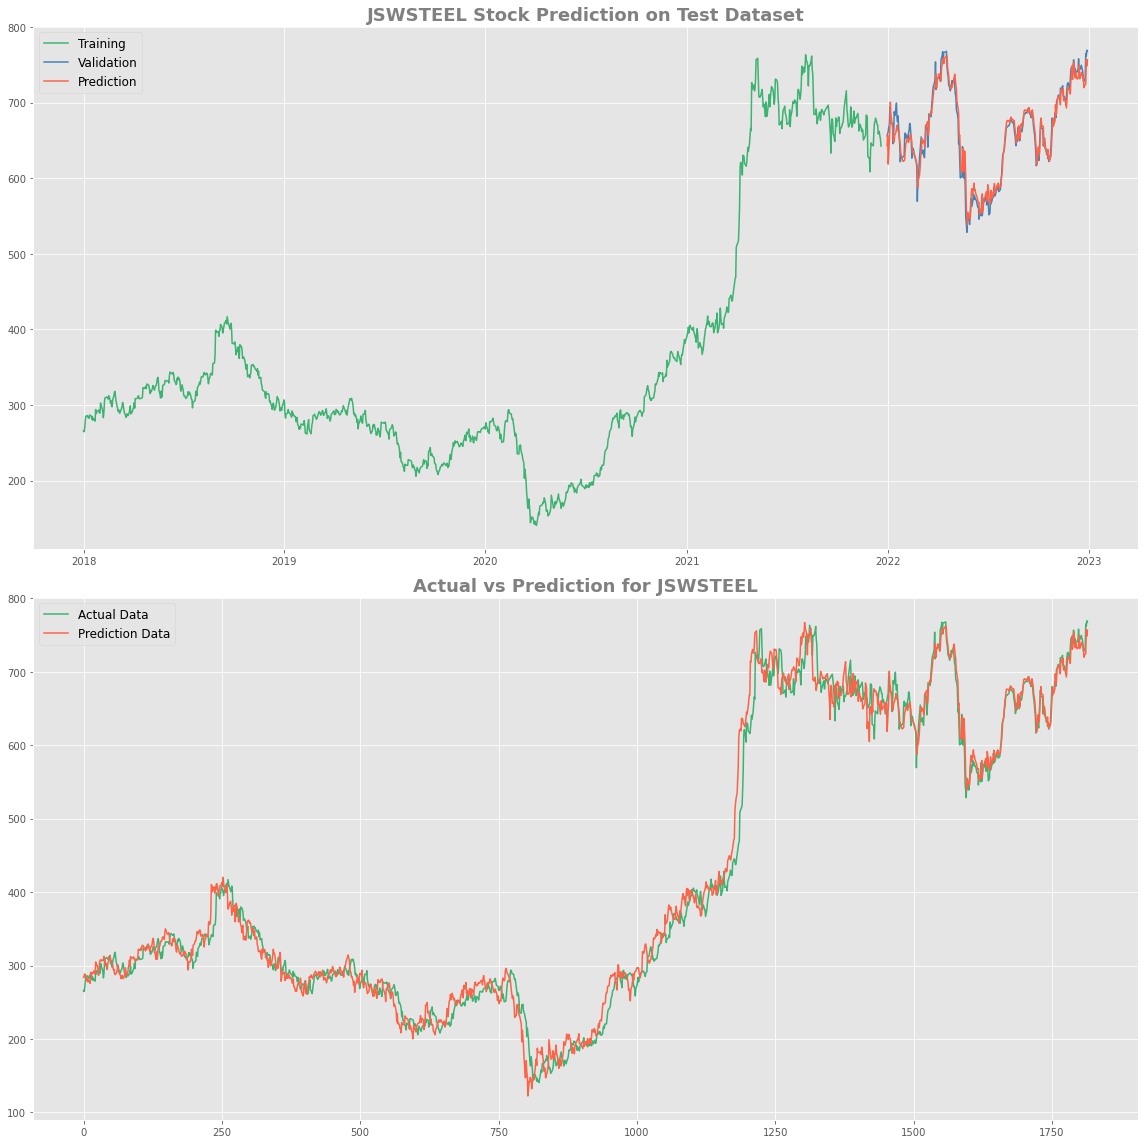

In [95]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[2] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[2]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[2]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[2]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("JSWSTEEL.jpg")
plt.show()

#### 3.7.4. Visualizing Results for 'RELIANCE'

In [96]:
valid.loc[:,'Pred'] = y_preds[3]

trn_idx_l = 3*trn_len
trn_idx_h = trn_idx_l + trn_len
tst_idx_l = 3*test_len
tst_idx_h = tst_idx_l + test_len

pred_train = model.predict(x_train[trn_idx_l:trn_idx_h])
pred_train = scalers[3].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[3])
acts = np.append(train[labels[3]].values, y_test[tst_idx_l:tst_idx_h])

46/46 [==============================] - 0s 7ms/step


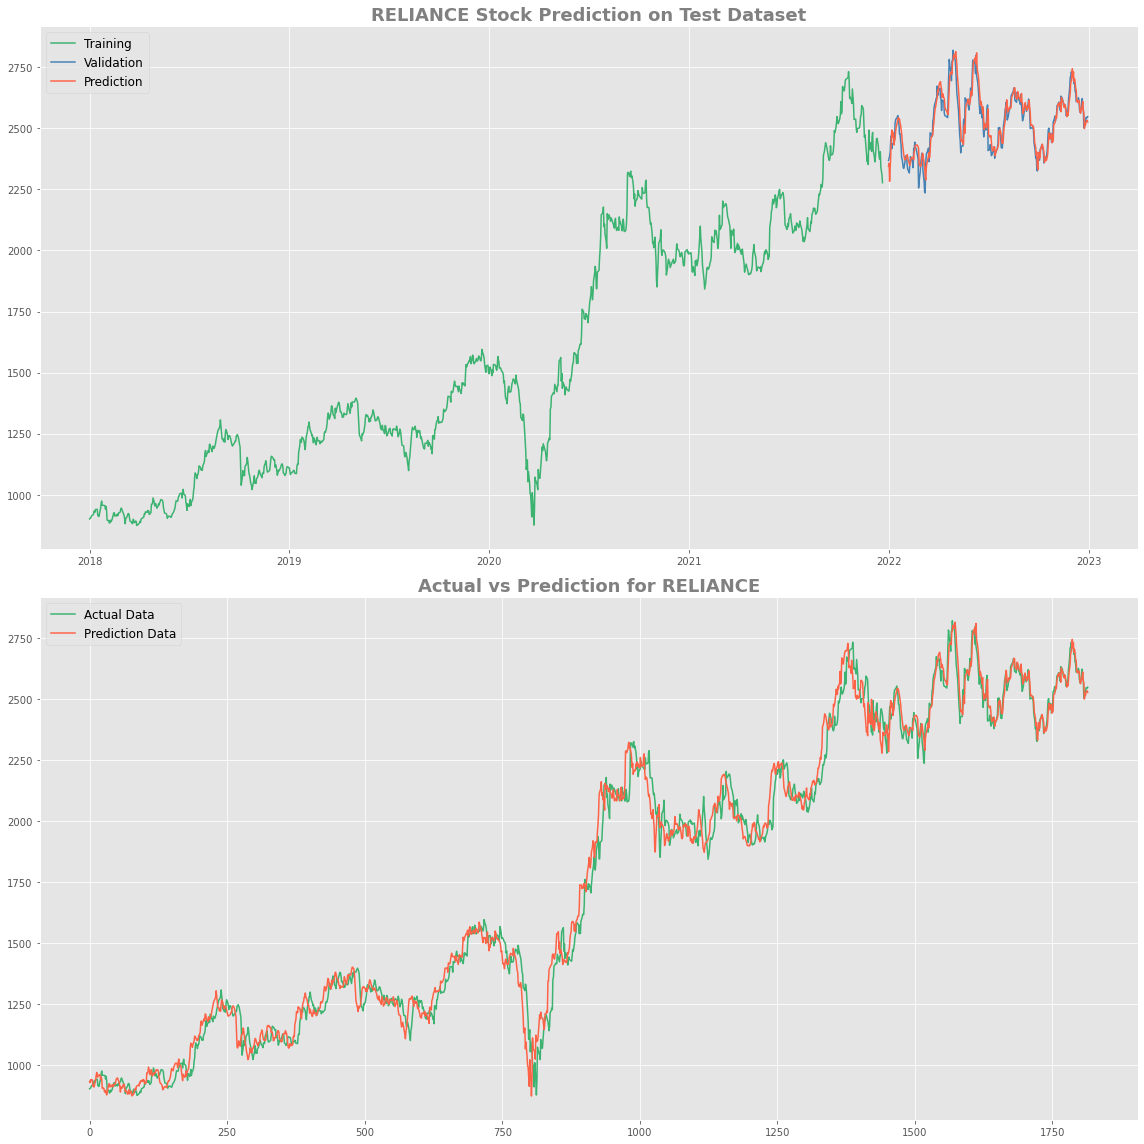

In [97]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[3] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[3]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[3]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[3]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("RELIANCE.jpg")
plt.show()

#### 3.7.5. Visualizing Results for 'TCS'

In [98]:
valid.loc[:,'Pred'] = y_preds[4]

trn_idx_l = 4*trn_len
trn_idx_h = trn_idx_l + trn_len
tst_idx_l = 4*test_len
tst_idx_h = tst_idx_l + test_len

pred_train = model.predict(x_train[trn_idx_l:trn_idx_h])
pred_train = scalers[4].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[4])
acts = np.append(train[labels[4]].values, y_test[tst_idx_l:tst_idx_h])

46/46 [==============================] - 0s 7ms/step


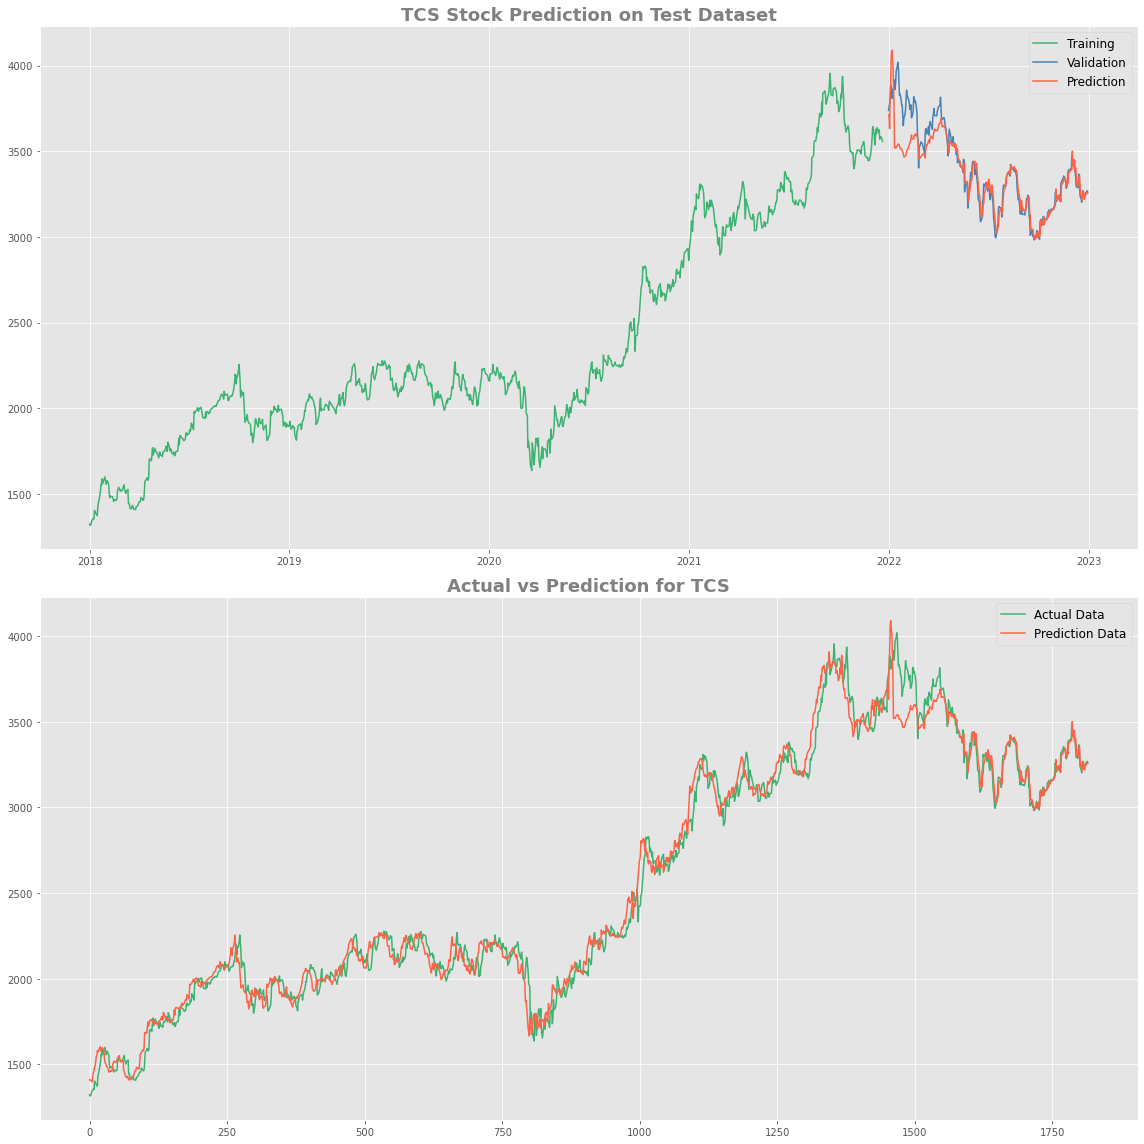

In [99]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[4] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[4]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[4]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[4]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("TCS.jpg")
plt.show()

#### 3.7.6 Observing the Evaluation Metrics for All Predictions

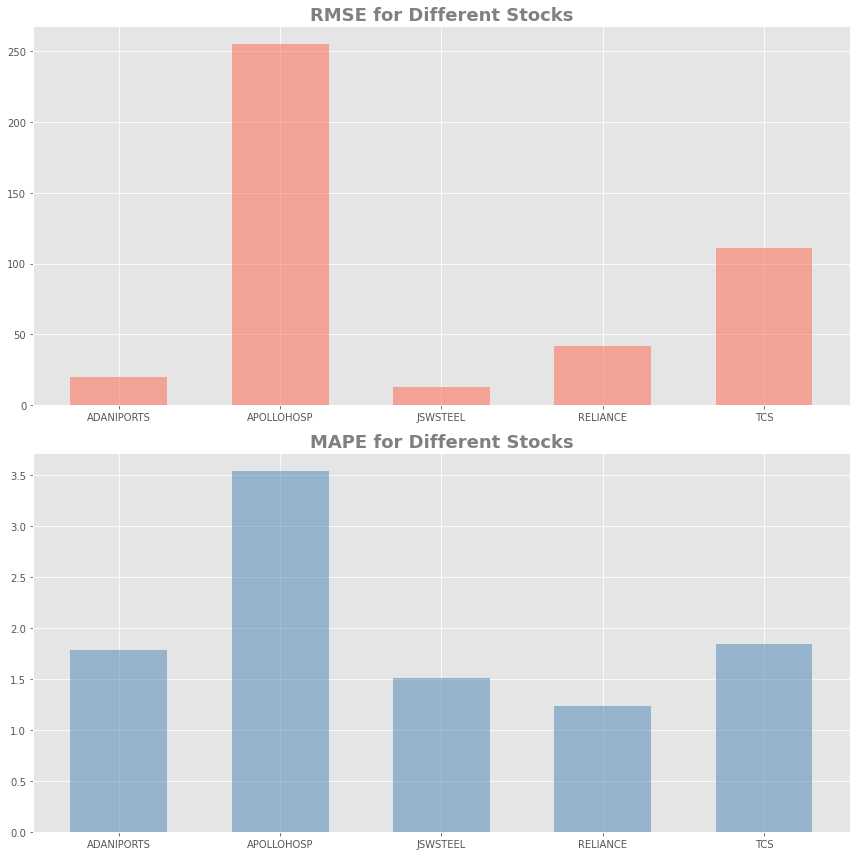

In [100]:
fig, ax = plt.subplots(2,1,figsize=(12,12))

ax[0].set_title("RMSE for Different Stocks",
                fontsize=18,
                fontweight='bold',
                color='grey')

ax[0].bar(metrics_df['Stock'],
          metrics_df['RMSE'],
          color='tomato',
          alpha=0.5,
          width=0.6)

ax[1].set_title("MAPE for Different Stocks",
                fontsize=18,
                fontweight='bold',
                color='grey')

ax[1].bar(metrics_df['Stock'],
          metrics_df['MAPE'],
          color='steelblue',
          alpha=0.5,
          width=0.6)

fig.tight_layout()
# plt.savefig("RMSE_MAPE.jpg")
plt.show()

From the above two plots, it can be seen that RMSE values are spread over a wide range, as they are directly related to the scale of magnitude of the variables being observed, i.e., for stocks having high values of stock prices, for example, "APOLLOHOSP", the RMSE value is much larger than the RMSE value for "ADANIPORTS", whose stock prices are in a much lower range.

On the other hand, MAPE values are in the same range for all datasets, as they represent the mean percentage error for each dataset.

========================================================================================================

## 4. Sentiment Analysis on Twitter Data

In this section, sentiment scores will be determined for each tweet in the dataset. The sentiment scores correspond to 3 polarities - Negative, Neutral, and Positive. After obtaining the sentiment scores for the tweets, following steps will be performed -

<ul>
    <li>A random sample will be collected along with the calculated sentiment scores, and the tweets in the sample will be manually labelled as negative, neutral or positive.</li>
    <li>The manually labelled sample will then used to plot the ROC curve for each sentiment category, and the best threshold values for negative and positive sentiments will be determined.</li>
    <li>After determining the appropriate thresholds, the sentiment scores will be aggregated to get the sentiment score for each day.</li>
    <li>Additional features will be created, which will be used in the training and prediction steps.</li>
</ul>

### 4.1 Determining Sentiment Polarities

We will first determine the sentiment polarity scores for each tweet using the VADER setiment analyzer. The VADER sentiment analyzer provides a dictionary of sentiment scores - in terms of Positive sentiment, Negative sentiment, and Neutral sentiment - as output for each input sentence. In addition, the VADER also provides an output called 'Compound', which is computed by aggregating the valence scores of each word and normalizing to be between -1 and 1. The compound scores can be interpreted as follows - 

<ol>
    <li>Compound score > 0.05 denotes positive sentiment</li>
    <li>Compound score >= -0.05 and <= 0.05 denotes neutral sentiment</li>
    <li>Compound score < -0.05 denotes negative sentiment</li>
</ol>

The positive, negative and neutral scores lie between 0 and 1.

In [101]:
sent_analyzer = SentimentIntensityAnalyzer()
def SentimentScore(sent):
    score = sent_analyzer.polarity_scores(sent)
    return score

In [102]:
strt = time.time()

sent_scores = news_twts_df['TwtsTxt'].apply(SentimentScore)
 
news_twts_df = news_twts_df.assign(Neg = [x['neg'] for x in sent_scores],
                                   Neu = [x['neu'] for x in sent_scores],
                                   Pos = [x['pos'] for x in sent_scores],
                                   Comp = [x['compound'] for x in sent_scores])

end = time.time()

print("Time elapsed for", len(news_twts_df),"tweets:", str(int((end - strt)//60)), "mins", str(int((end - strt)%60)), "secs")

Time elapsed for 1875711 tweets: 11 mins 26 secs


In [103]:
news_twts_df.head()

,Date,ID,TwtsTxt,User,Neg,Neu,Pos,Comp
0,2018-12-31 13:41:04+00:00,1079734183411548161,From CNBC | Senator Elizabeth Warren launches ...,CNBCTV18Live,0.000,1.000,0.000,0.0000
1,2018-12-31 13:02:48+00:00,1079724553775964165,#JustIn | @IndianOilcl to cut non-subsidised L...,CNBCTV18Live,0.139,0.861,0.000,-0.2732
2,2018-12-31 12:55:48+00:00,1079722793858547712,Kotak Mahindra Bank to CNBC-TV8: @KotakBankLtd...,CNBCTV18Live,0.044,0.929,0.027,-0.1813
3,2018-12-31 12:43:23+00:00,1079719666904252416,FIIs net sell Rs 326.87 cr &amp; DIIs net buy ...,CNBCTV18Live,0.000,1.000,0.000,0.0000
4,2018-12-31 12:25:35+00:00,1079715187517620225,Core Sector Data | November steel output at 6%...,CNBCTV18Live,0.000,1.000,0.000,0.0000


In [104]:
news_twts_df.tail()

,Date,ID,TwtsTxt,User,Neg,Neu,Pos,Comp
1875706,2021-01-01 03:27:20+00:00,1344847650684690434,"@Sammedh3 Hey Sammedh, could you please create...",zerodhaonline,0.00,0.773,0.227,0.5267
1875707,2021-01-01 03:21:58+00:00,1344846300420874240,"@swatibhattbhatt Hey Swati, we're sorry to hea...",zerodhaonline,0.06,0.880,0.060,0.0000
1875708,2021-01-01 03:17:35+00:00,1344845196819800064,"@prateekprakash1 Hey Prateek, could you please...",zerodhaonline,0.00,0.773,0.227,0.5267
1875709,2021-01-01 03:15:21+00:00,1344844633390477312,"@HarendarRathore Hey Harendar, What seems to b...",zerodhaonline,0.00,0.865,0.135,0.3939
1875710,2021-01-01 02:24:21+00:00,1344831798887415809,@valueshadow @Nithin0dha https://t.co/dUHAjxumEy,zerodhaonline,0.00,1.000,0.000,0.0000


In [105]:
news_twts_df['Sent'] = news_twts_df['Comp'].apply(lambda x: -1 if x < -0.05 else 1 if x > 0.05 else 0)
news_twts_df.head()

,Date,ID,TwtsTxt,User,Neg,Neu,Pos,Comp,Sent
0,2018-12-31 13:41:04+00:00,1079734183411548161,From CNBC | Senator Elizabeth Warren launches ...,CNBCTV18Live,0.000,1.000,0.000,0.0000,0
1,2018-12-31 13:02:48+00:00,1079724553775964165,#JustIn | @IndianOilcl to cut non-subsidised L...,CNBCTV18Live,0.139,0.861,0.000,-0.2732,-1
2,2018-12-31 12:55:48+00:00,1079722793858547712,Kotak Mahindra Bank to CNBC-TV8: @KotakBankLtd...,CNBCTV18Live,0.044,0.929,0.027,-0.1813,-1
3,2018-12-31 12:43:23+00:00,1079719666904252416,FIIs net sell Rs 326.87 cr &amp; DIIs net buy ...,CNBCTV18Live,0.000,1.000,0.000,0.0000,0
4,2018-12-31 12:25:35+00:00,1079715187517620225,Core Sector Data | November steel output at 6%...,CNBCTV18Live,0.000,1.000,0.000,0.0000,0


### 4.2 Sampling Tweets and Manual Labelling

In this sub-section a random sample of tweets will be collected and the sampled tweets will be manually labelled as negative, positive, or neutral. For this purpose, <b><i>stratified random sampling</i></b> will be used, with equal number of samples from each category. The sample will contain 1000 tweets each, belonging to the negative sentiment class (-1), neutral sentiment class (0), and positive sentiment class (1). As the random sample created each time will contain different data records, the sample will be saved to a csv file, and reused in subsequent analysis.

In [106]:
# twts_smpl = news_twts_df.groupby(news_twts_df['Sent'], group_keys=False).apply(lambda x: x.sample(1000))
# twts_smpl.to_csv('Twts_Sent.csv')
# twts_smpl.groupby(twts_smpl['Sent']).count()
twts_lbl = pd.read_csv("Tweets_Sample_Label.csv")
twts_lbl.head()

,Date,ID,TwtsTxt,User,Neg,Neu,Pos,Comp,Sent,Sent_lbl
0,16-12-2022 15:07:06,1603685638888460288,Rupee Falls 13 Paise To 82.89 Per Dollar On Ec...,NDTVProfit,0.161,0.690,0.149,-0.0516,-1,-1
1,30-11-2020 16:50:26,1333370297748111361,Bandhan Bank’s Chandra Shekhar Ghosh opens up ...,moneycontrolcom,0.109,0.891,0.000,-0.4005,-1,0
2,05-08-2019 11:27:00,1158255563098198016,Article 35A denied people of #Kashmir a boomin...,bsindia,0.139,0.861,0.000,-0.4404,-1,-1
3,12-05-2022 22:40:00,1524799061240553475,The median salary increment this year is likel...,EconomicTimes,0.079,0.921,0.000,-0.3400,-1,1
4,31-03-2022 02:45:00,1509278039233990663,The State Department’s travel advisory comes a...,livemint,0.055,0.945,0.000,-0.2732,-1,1


In [107]:
twts_lbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3000 non-null   object 
 1   ID        3000 non-null   int64  
 2   TwtsTxt   3000 non-null   object 
 3   User      3000 non-null   object 
 4   Neg       3000 non-null   float64
 5   Neu       3000 non-null   float64
 6   Pos       3000 non-null   float64
 7   Comp      3000 non-null   float64
 8   Sent      3000 non-null   int64  
 9   Sent_lbl  3000 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 234.5+ KB


### 4.3 Evaluating the Sentiment Scores using the Manually Labelled Sample

The manually labelled sample will be used to evaluate the performance of the sentiment analyzer. Since the data has 3 sentiment classes, the <b><i>"One vs All"</i></b> method will be employed. For this purpose, the manually labelled sentiment classes will be fed to a <b><i>label binarizer</i></b>, which will convert the single sentiment class column to 3 columns - one corresponding to each of the sentiment categories. The <b><i>roc_curve</i></b> and <b><i>auc</i></b> methods of the <b>sklearn</b> library will be used to determine the <b>"False Positive Rate"</b> and <b>"True Positive Rate"</b> for various threshold values, and to calculate the <b>"Area Under the Curve"</b>. This will be done for the negative sentiment class and positive sentiment class separately. The ROC curves in each case will be plotted, and the best threshold values for each classification will be selected based on the results. 

#### 4.3.1 Label Binarizer for the Sentiment Class

In [108]:
twts_lbl[['is_neg', 'is_neu', 'is_pos']] = pd.DataFrame(label_binarize(y=twts_lbl['Sent_lbl'], 
                                                                         classes=[-1, 0, 1]), 
                                                        index=twts_lbl.index)
twts_lbl.head()

,Date,ID,TwtsTxt,User,Neg,Neu,Pos,Comp,Sent,Sent_lbl,is_neg,is_neu,is_pos
0,16-12-2022 15:07:06,1603685638888460288,Rupee Falls 13 Paise To 82.89 Per Dollar On Ec...,NDTVProfit,0.161,0.690,0.149,-0.0516,-1,-1,1,0,0
1,30-11-2020 16:50:26,1333370297748111361,Bandhan Bank’s Chandra Shekhar Ghosh opens up ...,moneycontrolcom,0.109,0.891,0.000,-0.4005,-1,0,0,1,0
2,05-08-2019 11:27:00,1158255563098198016,Article 35A denied people of #Kashmir a boomin...,bsindia,0.139,0.861,0.000,-0.4404,-1,-1,1,0,0
3,12-05-2022 22:40:00,1524799061240553475,The median salary increment this year is likel...,EconomicTimes,0.079,0.921,0.000,-0.3400,-1,1,0,0,1
4,31-03-2022 02:45:00,1509278039233990663,The State Department’s travel advisory comes a...,livemint,0.055,0.945,0.000,-0.2732,-1,1,0,0,1


In [109]:
print("Negative tweets in labelled data:") 
print(twts_lbl['is_neg'].value_counts())
print("\nNeutral tweets in labelled data:") 
print(twts_lbl['is_neu'].value_counts())
print("\nPositive tweets in labelled data:") 
twts_lbl['is_pos'].value_counts()

Negative tweets in labelled data:
0    1992
1    1008
Name: is_neg, dtype: int64

Neutral tweets in labelled data:
0    1768
1    1232
Name: is_neu, dtype: int64

Positive tweets in labelled data:


0    2240
1     760
Name: is_pos, dtype: int64

#### 4.3.2 Determining ROC and AUC for the Negative Labelled Tweets

In [110]:
neg_fpr, neg_tpr, neg_thresholds = roc_curve(twts_lbl['is_neg'], -twts_lbl['Comp'], pos_label=1)
neg_roc_auc = auc(neg_fpr, neg_tpr)
neg_roc_auc

0.7706415941543955

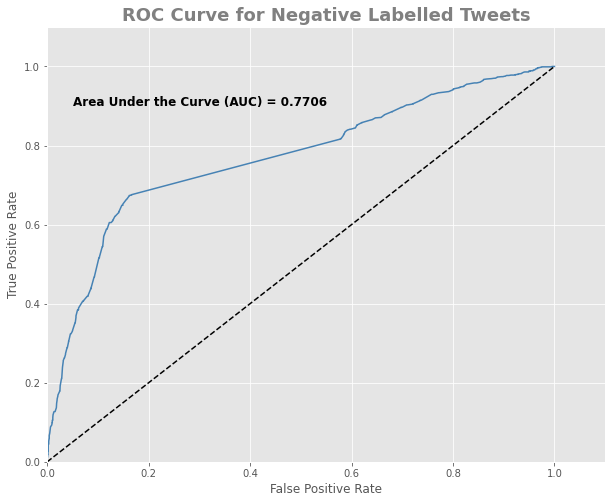

In [111]:
fig, ax = plt.subplots(figsize=(10,8))

ax.set_title("ROC Curve for Negative Labelled Tweets",
             color='grey',
             fontweight='bold',
             fontsize=18)

ax.plot(neg_fpr, 
        neg_tpr,
        color='steelblue')

ax.plot([0,1], 
        [0,1], 
        linestyle='--', 
        color='black')

ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

txt = "Area Under the Curve (AUC) = " + str(round(neg_roc_auc,4))
ax.text(0.05,
        0.9,
        txt,
        ha='left',
        size=12,
        fontweight='bold')

# plt.savefig("Neg_ROC.jpg")
plt.show()

#### 4.3.3 Determining ROC and AUC for Positive Labelled Tweets

In [112]:
pos_fpr, pos_tpr, pos_thresholds = roc_curve(twts_lbl['is_pos'], twts_lbl['Comp'], pos_label=1)
pos_roc_auc = auc(pos_fpr, pos_tpr)
pos_roc_auc

0.7314350328947369

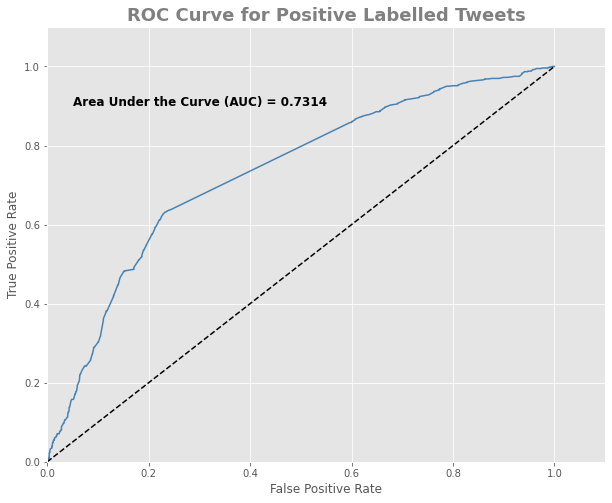

In [113]:
fig, ax = plt.subplots(figsize=(10,8))

ax.set_title("ROC Curve for Positive Labelled Tweets",
             color='grey',
             fontweight='bold',
             fontsize=18)

ax.plot(pos_fpr, 
        pos_tpr,
        color='steelblue')

ax.plot([0,1],
        [0,1],
        linestyle='--', 
        color='black')

ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

txt = "Area Under the Curve (AUC) = " + str(round(pos_roc_auc,4))
ax.text(0.05,
        0.9,
        txt,
        ha='left',
        size=12,
        fontweight='bold')

# plt.savefig("Pos_ROC.jpg")
plt.show()

#### 4.3.4 Measuring Accuracy at Different Classification Thresholds and Determining Best Thresholds 

In [114]:
neg_acc = []
for i,t in enumerate(neg_thresholds):
    neg_sent = -twts_lbl['Comp'] > t
    acc = accuracy_score(twts_lbl['is_neg'], neg_sent)
    neg_acc.append([-t, acc])
    
neg_acc_df = pd.DataFrame(neg_acc, 
                          columns=['Threshold', 'Accuracy'])

neg_acc_df.loc[neg_acc_df['Accuracy'] == neg_acc_df['Accuracy'].max()]

,Threshold,Accuracy
130,-0.2014,0.786


The analysis shows that the best accuracy is obtained at a threshold value of -0.2014, i.e., the classification of tweets as negative works best for VADER compound score less than -0.2014. The accuracy achieved at this classification threshold is 0.786 or 78.6%.

In [115]:
pos_acc = []
for i,t in enumerate(pos_thresholds):
    pos_sent = twts_lbl['Comp'] > t
    acc = accuracy_score(twts_lbl['is_pos'], pos_sent)
    pos_acc.append([t, acc])
    
pos_acc_df = pd.DataFrame(pos_acc,
                          columns=['Threshold', 'Accuracy'])

pos_acc_df.loc[pos_acc_df['Accuracy'] == pos_acc_df['Accuracy'].max()]

,Threshold,Accuracy
130,0.3595,0.757333
131,0.3400,0.757333


The analysis shows that the best accuracy is obtained at a threshold values 0.34 and 0.3595, i.e., the classification of tweets as positive works best for VADER compound score greater than 0.34. The accuracy achieved at this classification threshold is 0.757333 or 75.733%.

In [116]:
neg_sent = -twts_lbl['Comp'] > 0.05
neg_acc = accuracy_score(twts_lbl['is_neg'], neg_sent)
print("Accuracy at threshold -0.05 for negative labelled tweets:", neg_acc)
pos_sent = twts_lbl['Comp'] > 0.05
pos_acc = accuracy_score(twts_lbl['is_pos'], pos_sent)
print("Accuracy at threshold 0.05 for positive labelled tweets:", pos_acc)

Accuracy at threshold -0.05 for negative labelled tweets: 0.7826666666666666
Accuracy at threshold 0.05 for positive labelled tweets: 0.7333333333333333


The above results show that at the classification thresholds -0.05 for negative sentiment and 0.05 for positive sentiment, the accuracy is 0.782666 or 78.267% and 0.73333 or 73.333%. These accuracy figures are very close to the best accuracies achieved according to the ROC curves, and hence we will use these threshold values for the sentiment classification.

The plot below shows the change in accuracy values with different threshold values for negative and positive sentiment classification respectively.

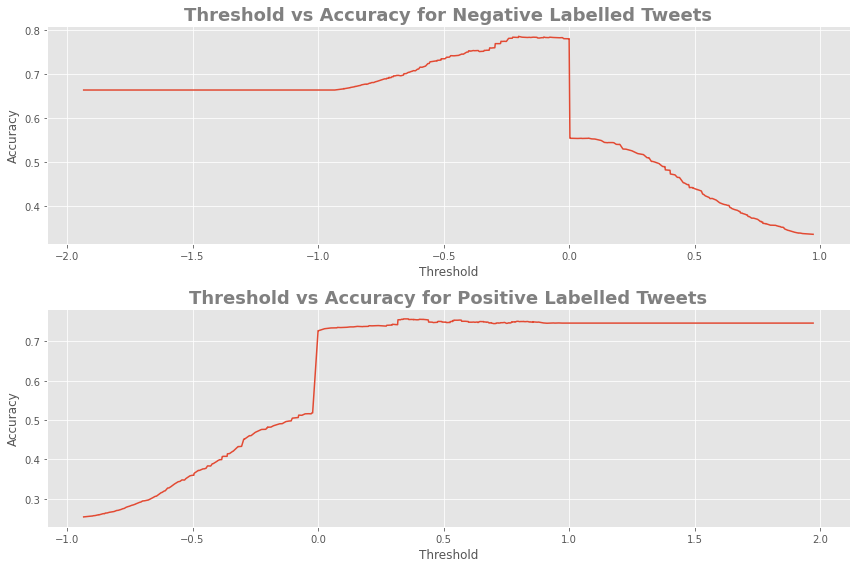

In [117]:
fig, ax = plt.subplots(2,1,figsize=(12,8))

ax[0].set_title("Threshold vs Accuracy for Negative Labelled Tweets",
                color='grey',
                fontweight='bold',
                fontsize=18)

ax[0].plot(neg_acc_df['Threshold'],
           neg_acc_df['Accuracy'])

ax[0].set_xlabel("Threshold")
ax[0].set_ylabel("Accuracy")

ax[1].set_title("Threshold vs Accuracy for Positive Labelled Tweets",
                color='grey',
                fontweight='bold',
                fontsize=18)

ax[1].plot(pos_acc_df['Threshold'],
           pos_acc_df['Accuracy'])

ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Accuracy")

fig.tight_layout()
# plt.savefig("Thresh_Acc.jpg")
plt.show()

### 4.4 Sentiment Aggregation

#### 4.4.1 Calculating Daily Average Sentiment Scores and Plotting the Scores 

In [118]:
twt_sent_day = news_twts_df.groupby(news_twts_df['Date'].dt.date).mean()
twt_sent_day.drop(columns=['Sent'], inplace=True)
twt_sent_day.head()

,Neg,Neu,Pos,Comp
Date,,,,
2018-01-01,0.056053,0.866130,0.077817,0.047221
2018-01-02,0.057763,0.877544,0.064696,0.024138
2018-01-03,0.072063,0.866552,0.061382,-0.004985
2018-01-04,0.061512,0.872664,0.065826,0.022938
2018-01-05,0.053936,0.871056,0.075010,0.049976


In [119]:
twt_sent_day.tail()

,Neg,Neu,Pos,Comp
Date,,,,
2022-12-26,0.033233,0.894353,0.072426,0.125318
2022-12-27,0.034320,0.891056,0.074625,0.128400
2022-12-28,0.034169,0.892782,0.073053,0.129645
2022-12-29,0.036127,0.898528,0.065341,0.097828
2022-12-30,0.037193,0.891209,0.071602,0.115942


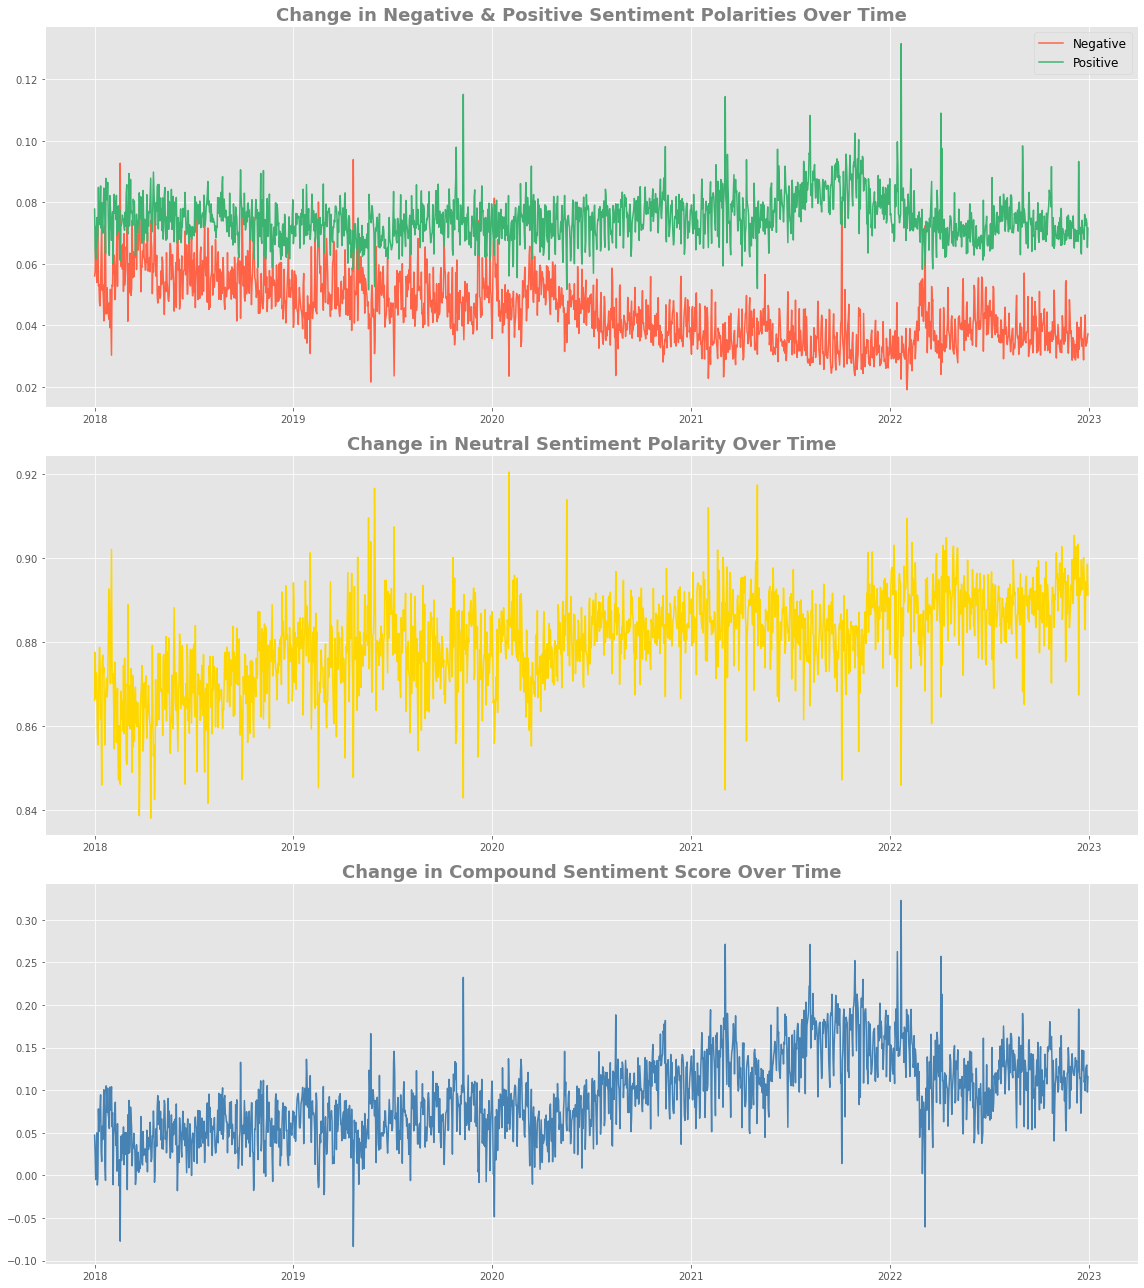

In [120]:
fig, ax = plt.subplots(3,1,figsize=(16,18))

ax[0].set_title("Change in Negative & Positive Sentiment Polarities Over Time",
                fontsize=18,
                fontweight='bold',
                color='grey')

ax[0].plot(twt_sent_day['Neg'],
           label='Negative',
           color='tomato')

ax[0].plot(twt_sent_day['Pos'],
           label='Positive',
           color='mediumseagreen')

ax[1].set_title("Change in Neutral Sentiment Polarity Over Time",
                fontsize=18,
                fontweight='bold',
                color='grey')

ax[1].plot(twt_sent_day['Neu'],
           label='Neutral',
           color='gold')

ax[2].set_title("Change in Compound Sentiment Score Over Time",
                fontsize=18,
                fontweight='bold',
                color='grey')

ax[2].plot(twt_sent_day['Comp'],
        label='Compound',
        color='steelblue')

ax[0].legend(fontsize=12)

fig.tight_layout()
# plt.savefig('Day_Sentiments.jpg')
plt.show()

#### 4.4.2 Feature Engineering

In this sub-section, new features will be extracted from the sentiment scores, and these features will be used later for training the model and predicting the stock prices. The following features will be created -

<ul>
    <li>Daily Mean of Compound score</li>
    <li>Daily Minimum of Compound Score</li>
    <li>Daily Maximum of Compound Score</li>
    <li>Number of negative tweets in a day, normalized by the total number of tweets for that day</li>
    <li>Number of neutral tweets in a day, normalized by the total number of tweets for that day</li>
    <li>Number of positive tweets in a day, normalized by the total number of tweets for that day</li>
    <li>3-day exponentially weighted average compound score</li>
    <li>7-day exponentially weighted average compound score</li>
    <li>10-day exponentially weighted average compound score</li>
</ul>

In [121]:
news_twt_sents = pd.DataFrame(news_twts_df.groupby(news_twts_df['Date'].dt.date)['Comp'].mean())
news_twt_sents['Comp_Min'] = news_twts_df.groupby(news_twts_df['Date'].dt.date)['Comp'].min()
news_twt_sents['Comp_Max'] = news_twts_df.groupby(news_twts_df['Date'].dt.date)['Comp'].max()

news_twt_sents.head()

,Comp,Comp_Min,Comp_Max
Date,,,
2018-01-01,0.047221,-0.9136,0.9052
2018-01-02,0.024138,-0.9331,0.9041
2018-01-03,-0.004985,-0.9607,0.8399
2018-01-04,0.022938,-0.9201,0.9022
2018-01-05,0.049976,-0.9477,0.8979


In [122]:
news_twt_sents['Neg_Cnt_N'] = news_twts_df.loc[news_twts_df['Comp'] < -0.05].\
groupby(news_twts_df['Date'].dt.date)['Comp'].count()\
/news_twts_df.groupby(news_twts_df['Date'].dt.date)['Comp'].count()

news_twt_sents['Neu_Cnt_N'] = news_twts_df.loc[(news_twts_df['Comp'] >= -0.05) \
                                             & (news_twts_df['Comp'] <= 0.05)].\
groupby(news_twts_df['Date'].dt.date)['Comp'].count()\
/news_twts_df.groupby(news_twts_df['Date'].dt.date)['Comp'].count()

news_twt_sents['Pos_Cnt_N'] = news_twts_df.loc[news_twts_df['Comp'] > 0.05].\
groupby(news_twts_df['Date'].dt.date)['Comp'].count()\
/news_twts_df.groupby(news_twts_df['Date'].dt.date)['Comp'].count()

news_twt_sents.head()

,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N
Date,,,,,,
2018-01-01,0.047221,-0.9136,0.9052,0.204600,0.438257,0.357143
2018-01-02,0.024138,-0.9331,0.9041,0.239845,0.449710,0.310445
2018-01-03,-0.004985,-0.9607,0.8399,0.284449,0.429134,0.286417
2018-01-04,0.022938,-0.9201,0.9022,0.257056,0.435484,0.307460
2018-01-05,0.049976,-0.9477,0.8979,0.220994,0.430939,0.348066


In [123]:
news_twt_sents.tail()

,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N
Date,,,,,,
2022-12-26,0.125318,-0.9423,0.9636,0.188245,0.359015,0.452740
2022-12-27,0.128400,-0.9402,0.9485,0.203162,0.352569,0.444269
2022-12-28,0.129645,-0.9393,0.9487,0.194006,0.344637,0.461356
2022-12-29,0.097828,-0.8957,0.9313,0.211307,0.374558,0.414134
2022-12-30,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198


In [124]:
news_twt_sents['Comp_3'] = news_twt_sents['Comp'].ewm(span=3, 
                                              adjust=True).mean()

news_twt_sents['Comp_7'] = news_twt_sents['Comp'].ewm(span=7, 
                                              adjust=True).mean()

news_twt_sents['Comp_10'] = news_twt_sents['Comp'].ewm(span=10, 
                                              adjust=True).mean()

news_twt_sents.head(10)

,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N,Comp_3,Comp_7,Comp_10
Date,,,,,,,,,
2018-01-01,0.047221,-0.9136,0.9052,0.204600,0.438257,0.357143,0.047221,0.047221,0.047221
2018-01-02,0.024138,-0.9331,0.9041,0.239845,0.449710,0.310445,0.031832,0.034030,0.034525
2018-01-03,-0.004985,-0.9607,0.8399,0.284449,0.429134,0.286417,0.010794,0.017159,0.018642
2018-01-04,0.022938,-0.9201,0.9022,0.257056,0.435484,0.307460,0.017271,0.019273,0.020058
2018-01-05,0.049976,-0.9477,0.8979,0.220994,0.430939,0.348066,0.034151,0.029337,0.028647
2018-01-06,-0.011287,-0.9371,0.8934,0.284965,0.395105,0.319930,0.011071,0.016982,0.018274
2018-01-07,-0.002605,-0.9423,0.9022,0.280405,0.435811,0.283784,0.004179,0.011331,0.013243
2018-01-08,0.078051,-0.9349,0.9559,0.213052,0.394434,0.392514,0.041260,0.029867,0.027987
2018-01-09,0.051537,-0.9548,0.9062,0.207885,0.456093,0.336022,0.046409,0.035724,0.033111


In [125]:
news_twt_sents.reset_index(inplace=True)
news_twt_sents['Date'] = pd.to_datetime(news_twt_sents['Date'], format="%Y-%m-%d")
news_twt_sents.head()

,Date,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N,Comp_3,Comp_7,Comp_10
0,2018-01-01,0.047221,-0.9136,0.9052,0.204600,0.438257,0.357143,0.047221,0.047221,0.047221
1,2018-01-02,0.024138,-0.9331,0.9041,0.239845,0.449710,0.310445,0.031832,0.034030,0.034525
2,2018-01-03,-0.004985,-0.9607,0.8399,0.284449,0.429134,0.286417,0.010794,0.017159,0.018642
3,2018-01-04,0.022938,-0.9201,0.9022,0.257056,0.435484,0.307460,0.017271,0.019273,0.020058
4,2018-01-05,0.049976,-0.9477,0.8979,0.220994,0.430939,0.348066,0.034151,0.029337,0.028647


In [126]:
news_twt_sents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   Comp       1825 non-null   float64       
 2   Comp_Min   1825 non-null   float64       
 3   Comp_Max   1825 non-null   float64       
 4   Neg_Cnt_N  1825 non-null   float64       
 5   Neu_Cnt_N  1825 non-null   float64       
 6   Pos_Cnt_N  1825 non-null   float64       
 7   Comp_3     1825 non-null   float64       
 8   Comp_7     1825 non-null   float64       
 9   Comp_10    1825 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 142.7 KB


========================================================================================================

## 5. Stock Price Prediction using Sentiment Data

The sentiment analysis performed in the previous section contains the sentiment scores for each day in the 5-year period from 01-01-2018 to 31-12-2022. The historical stock prices data contains daily stock prices for the 5 selected stocks during the same period. In order to be able to use the sentiment data for prediction of stock prices, the sentiment scores need to be augmented to the historical stock prices. For this purpose, the two datasets will be joined based on the <b>"Date"</b> column in both the datasets. Once the two datasets are joined, all the steps required to perform predictions - preparing the training and test datasets, compiling and training the model, performing predictions, and evaluarting the model - will be performed on the merged dataset.  

### 5.1 Joining the Historical Stock Prices and Sentiment Data

In [127]:
stocks_sent = stocks.merge(news_twt_sents,
                           left_on='Date',
                           right_on='Date')

In [128]:
stocks_sent.head()

,Stock,Date,Open,High,Low,Close,Adj Close,Volume,Close_N,Month,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N,Comp_3,Comp_7,Comp_10
0,ADANIPORTS,2018-01-01,406.700012,407.700012,398.049988,399.649994,387.671692,2701537.0,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221
1,APOLLOHOSP,2018-01-01,1216.000000,1216.000000,1199.099976,1202.550049,1182.671631,117565.0,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221
2,JSWSTEEL,2018-01-01,269.500000,271.700012,264.350006,265.799988,227.685211,1261616.0,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221
3,RELIANCE,2018-01-01,914.035828,914.035828,898.978577,901.207458,881.918213,4362651.0,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221
4,TCS,2018-01-01,1341.150024,1347.400024,1317.500000,1322.800049,1184.243896,1351760.0,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221


In [129]:
stocks_sent.tail()

,Stock,Date,Open,High,Low,Close,Adj Close,Volume,Close_N,Month,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N,Comp_3,Comp_7,Comp_10
9120,ADANIPORTS,2022-12-30,822.450012,826.750000,815.599976,818.099976,818.099976,3252956.0,-0.001769,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164
9121,APOLLOHOSP,2022-12-30,4550.000000,4582.450195,4468.100098,4477.600098,4471.560059,348965.0,-0.010355,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164
9122,JSWSTEEL,2022-12-30,773.000000,777.500000,765.250000,768.049988,768.049988,2190914.0,-0.001755,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164
9123,RELIANCE,2022-12-30,2545.100098,2577.000000,2541.100098,2547.199951,2547.199951,3364092.0,0.001533,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164
9124,TCS,2022-12-30,3286.050049,3299.000000,3246.199951,3256.699951,3192.039795,1163131.0,-0.003686,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164


The combined dataset has all the features from the two individual datasets - the historical stock prices dataset and the sentiment scores dataset.

### 5.2 Data Preparation

The data preparation stage includes the following steps -

<ol>
    <li>Filtering the dataset with the features of interest</li>
    <li>One-hot encoding for the 'Stock' column</li>
    <li>Merging the one-hot encoded features with the dataset</li>
    <li>Splitting the dataset into training and test sets</li>
</ol>

#### 5.2.1 Filtering the Combined Dataset with the Required Columns

In [130]:
all_cols = stocks_sent.columns.to_list()
cols_exc = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
cols_inc = [x for x in all_cols if x not in cols_exc]
cols_inc

['Stock',
 'Date',
 'Close',
 'Close_N',
 'Month',
 'Comp',
 'Comp_Min',
 'Comp_Max',
 'Neg_Cnt_N',
 'Neu_Cnt_N',
 'Pos_Cnt_N',
 'Comp_3',
 'Comp_7',
 'Comp_10']

In [131]:
st_cl_sent = FilterData(stocks_sent, cols_inc)
st_cl_sent.head()

,Stock,Date,Close,Close_N,Month,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N,Comp_3,Comp_7,Comp_10
0,ADANIPORTS,2018-01-01,399.649994,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221
1,APOLLOHOSP,2018-01-01,1202.550049,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221
2,JSWSTEEL,2018-01-01,265.799988,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221
3,RELIANCE,2018-01-01,901.207458,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221
4,TCS,2018-01-01,1322.800049,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221


In [132]:
st_cl_sent.tail()

,Stock,Date,Close,Close_N,Month,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N,Comp_3,Comp_7,Comp_10
9120,ADANIPORTS,2022-12-30,818.099976,-0.001769,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164
9121,APOLLOHOSP,2022-12-30,4477.600098,-0.010355,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164
9122,JSWSTEEL,2022-12-30,768.049988,-0.001755,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164
9123,RELIANCE,2022-12-30,2547.199951,0.001533,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164
9124,TCS,2022-12-30,3256.699951,-0.003686,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164


#### 5.2.2 Performing One-hot Encoding on the Filtered Dataset

In [133]:
ohe2 = OneHotEncoder(drop='first', sparse=False)
st_sent_enc = ohe.fit_transform(st_cl_sent[['Stock']])
st_sent_enc = pd.DataFrame(st_sent_enc, columns=ohe.get_feature_names_out())
st_sent_enc.head()

,Stock_APOLLOHOSP,Stock_JSWSTEEL,Stock_RELIANCE,Stock_TCS
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0


In [134]:
st_sent_enc.tail()

,Stock_APOLLOHOSP,Stock_JSWSTEEL,Stock_RELIANCE,Stock_TCS
9120,0.0,0.0,0.0,0.0
9121,1.0,0.0,0.0,0.0
9122,0.0,1.0,0.0,0.0
9123,0.0,0.0,1.0,0.0
9124,0.0,0.0,0.0,1.0


#### 5.2.3 Merging the One-hot Encoding Features with the Actual Data

In [135]:
stocks_sent_enc = st_cl_sent.merge(st_sent_enc, left_index=True, right_index=True)
stocks_sent_enc.head()

,Stock,Date,Close,Close_N,Month,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N,Comp_3,Comp_7,Comp_10,Stock_APOLLOHOSP,Stock_JSWSTEEL,Stock_RELIANCE,Stock_TCS
0,ADANIPORTS,2018-01-01,399.649994,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221,0.0,0.0,0.0,0.0
1,APOLLOHOSP,2018-01-01,1202.550049,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221,1.0,0.0,0.0,0.0
2,JSWSTEEL,2018-01-01,265.799988,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221,0.0,1.0,0.0,0.0
3,RELIANCE,2018-01-01,901.207458,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221,0.0,0.0,1.0,0.0
4,TCS,2018-01-01,1322.800049,0.0,1,0.047221,-0.9136,0.9052,0.2046,0.438257,0.357143,0.047221,0.047221,0.047221,0.0,0.0,0.0,1.0


In [136]:
stocks_sent_enc.tail()

,Stock,Date,Close,Close_N,Month,Comp,Comp_Min,Comp_Max,Neg_Cnt_N,Neu_Cnt_N,Pos_Cnt_N,Comp_3,Comp_7,Comp_10,Stock_APOLLOHOSP,Stock_JSWSTEEL,Stock_RELIANCE,Stock_TCS
9120,ADANIPORTS,2022-12-30,818.099976,-0.001769,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164,0.0,0.0,0.0,0.0
9121,APOLLOHOSP,2022-12-30,4477.600098,-0.010355,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164,1.0,0.0,0.0,0.0
9122,JSWSTEEL,2022-12-30,768.049988,-0.001755,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164,0.0,1.0,0.0,0.0
9123,RELIANCE,2022-12-30,2547.199951,0.001533,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164,0.0,0.0,1.0,0.0
9124,TCS,2022-12-30,3256.699951,-0.003686,12,0.115942,-0.9674,0.9636,0.218423,0.329379,0.452198,0.113953,0.116234,0.117164,0.0,0.0,0.0,1.0


#### 5.2.4 Train-Test Split

In [137]:
x_trn_l = []
y_trn_l = []
x_tst_l = []
y_tst_l = []
scalers = []

ohe_cols = ['Date', 'Stock']
vals = ['Close']
cols = [x for x in stocks_sent_enc.columns if x not in vals and x not in ohe_cols]

for label in labels:
    x_trn, y_trn, x_tst, y_tst, sc, train_len, test_len = PrepareData(stocks_sent_enc, label, vals, cols)
    x_trn_l.append(x_trn)
    y_trn_l.append(y_trn)
    x_tst_l.append(x_tst)
    y_tst_l.append(y_tst)
    scalers.append(sc)
    
x_train = np.concatenate(x_trn_l, axis=0)
y_train = np.concatenate(y_trn_l, axis=0)
x_test = np.concatenate(x_tst_l, axis=0)
y_test = np.concatenate(y_tst_l, axis=0)

print("\nMerged Training input shape:", x_train.shape)
print("Merged Training output shape:", y_train.shape)
print("Merged Test input shape:", x_test.shape)
print("Merged Test output shape:", y_test.shape)


Preparing data for ADANIPORTS
-------------------------------
Input data shape before train-test split: (1825, 16)
Training data length: 1460
Test data length: 365
Training input shape: (1450, 10, 16)
Training output shape: (1450, 1)
Test input shape: (365, 10, 16)
Test output shape: (365, 1)

Preparing data for APOLLOHOSP
-------------------------------
Input data shape before train-test split: (1825, 16)
Training data length: 1460
Test data length: 365
Training input shape: (1450, 10, 16)
Training output shape: (1450, 1)
Test input shape: (365, 10, 16)
Test output shape: (365, 1)

Preparing data for JSWSTEEL
-------------------------------
Input data shape before train-test split: (1825, 16)
Training data length: 1460
Test data length: 365
Training input shape: (1450, 10, 16)
Training output shape: (1450, 1)
Test input shape: (365, 10, 16)
Test output shape: (365, 1)

Preparing data for RELIANCE
-------------------------------
Input data shape before train-test split: (1825, 16)
Tra

In [138]:
# First and last training input samples 
x_train[[0,-1]]

array([[[ 0.00000000e+00,  1.00000000e+00,  4.72205811e-02,
         -9.13600000e-01,  9.05200000e-01,  2.04600484e-01,
          4.38256659e-01,  3.57142857e-01,  4.72205811e-02,
          4.72205811e-02,  4.72205811e-02,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.02546668e-02],
        [-5.62992627e-03,  1.00000000e+00,  2.41378143e-02,
         -9.33100000e-01,  9.04100000e-01,  2.39845261e-01,
          4.49709865e-01,  3.10444874e-01,  3.18320699e-02,
          3.40304287e-02,  3.45250594e-02,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.64905923e-02],
        [ 2.57926526e-02,  1.00000000e+00, -4.98454724e-03,
         -9.60700000e-01,  8.39900000e-01,  2.84448819e-01,
          4.29133858e-01,  2.86417323e-01,  1.07940030e-02,
          1.71590877e-02,  1.86424600e-02,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.19175126e-02],
        [ 5.3968164

In [139]:
# First 5 training data outputs
y_train[0:5]

array([[0.0613892 ],
       [0.05529182],
       [0.05342106],
       [0.05155029],
       [0.04780876]])

In [140]:
# First and last test data input samples
x_test[[0,-1]]

array([[[ 3.40600869e-02,  1.20000000e+01,  1.64107275e-01,
         -9.38200000e-01,  9.61200000e-01,  1.69757489e-01,
          3.47360913e-01,  4.82881598e-01,  1.53796971e-01,
          1.54234831e-01,  1.54956114e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.93123018e-01],
        [-3.78996705e-03,  1.20000000e+01,  1.60126190e-01,
         -9.31300000e-01,  9.58900000e-01,  1.59147870e-01,
          3.48370927e-01,  4.92481203e-01,  1.56961581e-01,
          1.55707671e-01,  1.55896128e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.85501332e-01],
        [ 1.16898561e-02,  1.20000000e+01,  1.84332330e-01,
         -9.36000000e-01,  9.58900000e-01,  1.53649168e-01,
          3.21382843e-01,  5.24967990e-01,  1.70646956e-01,
          1.62863836e-01,  1.61066346e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          9.08920730e-01],
        [-1.2170058

In [141]:
# First 5 test data outputs
y_test[0:5]

array([[730.29998779],
       [731.87498474],
       [733.44998169],
       [736.59997559],
       [739.25      ]])

### 5.3 Model Building and Price Predictions

The model for predicting the stock prices will have the same architecture as the baseline model, i.e., the model has one input layer with 10 LSTM units, 2 hidden layers of 5 LSTM units each, 1 Dense layer containing 10 units and 1 Dense output layer containing a single unit. The model will use ReLU activation function, and will be trained for 25 epochs with a batch size of 32. The model will use the mean squared error as the loss function, and ADAM optimizer. 

#### 5.3.1 Building and Training the Model

In [142]:
# Commented as model will be loaded from saved pickle file
# model_f = BuildModel(10, 5, 'relu')
# model_f = FitModel(model_f, 
#                  x_train, 
#                  y_train, 
#                  opt='adam', 
#                  loss='mean_squared_error', 
#                  btc_size=32, 
#                  epochs=25)

# Saving the trained model to pickle file for future reuse
# pickle.dump(model_f, open("final_model.pkl", 'wb'))

# Loading the pre-trained model from saved pickle file
model_f = pickle.load(open('final_model.pkl', 'rb'))

model.summary()

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-07 20:51:58         3927
metadata.json                                  2023-03-07 20:51:58           64
variables.h5                                   2023-03-07 20:51:58        57368
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\lstm_2
......vars
...layers\lstm_2\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
....

#### 5.3.2 Predicting Stock Prices using Sentiment Scores

In [143]:
rmse_l = []
mape_l = []
y_preds = []

# Predictions
for i, label in enumerate(labels):
    idx_l = i*test_len
    idx_h = idx_l + test_len
    y_pred = ModelPrediction(model_f,
                             x_test[idx_l:idx_h],
                             scalers[i])
    
    y_preds.append(y_pred)
    
    rmse, mape = EvaluateModel(y_pred, y_test[idx_l:idx_h])
    print("\nStock:", label)
    print("RMSE =", rmse)
    print("MAPE =", mape)
    rmse_l.append(rmse)
    mape_l.append(mape)

metrics_df2 = pd.DataFrame(zip(labels, rmse_l, mape_l), 
                          columns=['Stock', 'RMSE', 'MAPE'])

12/12 [==============================] - 1s 7ms/step

Stock: ADANIPORTS
RMSE = 16.915048040909912
MAPE = 1.5612592524899853
12/12 [==============================] - 0s 8ms/step

Stock: APOLLOHOSP
RMSE = 101.73124087426173
MAPE = 1.6319929801302127
12/12 [==============================] - 0s 8ms/step

Stock: JSWSTEEL
RMSE = 14.111181185864167
MAPE = 1.4835646376206966
12/12 [==============================] - 0s 8ms/step

Stock: RELIANCE
RMSE = 42.290529847560215
MAPE = 1.241736328346965
12/12 [==============================] - 0s 8ms/step

Stock: TCS
RMSE = 57.35182932749786
MAPE = 1.2093059618231494


In [144]:
metrics_df2

,Stock,RMSE,MAPE
0,ADANIPORTS,16.915048,1.561259
1,APOLLOHOSP,101.731241,1.631993
2,JSWSTEEL,14.111181,1.483565
3,RELIANCE,42.290530,1.241736
4,TCS,57.351829,1.209306


### 5.4 Visualizing Prediction Results

In [145]:
# Training samples
trn_len = train_len - 10
train = stocks_cl[:trn_len].copy()

# Test samples
valid = stocks_cl[train_len:].copy()

#### 5.4.1 Visualizing Results for 'ADANIPORTS'

In [146]:
valid.loc[:,'Pred'] = y_preds[0]

pred_train = model_f.predict(x_train[:trn_len])
pred_train = scalers[0].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[0])
acts = np.append(train[labels[0]].values, y_test[:test_len])

46/46 [==============================] - 0s 8ms/step


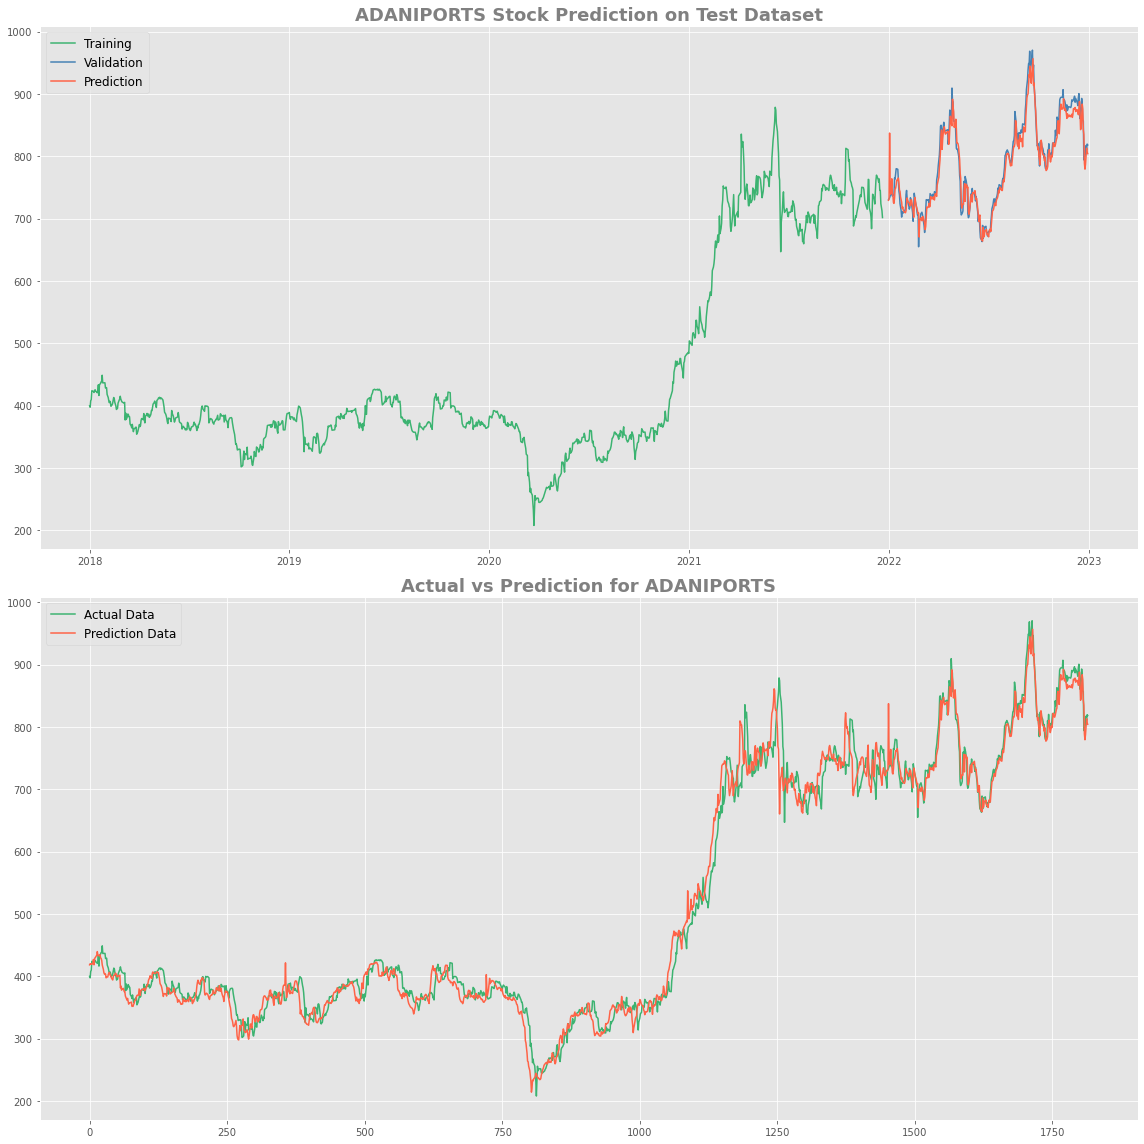

In [147]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[0] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[0]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[0]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[0]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("ADANIPORTS_Sent.jpg")
plt.show()

#### 5.4.2 Visualizing Results for 'APOLLOHOSP'

In [148]:
valid.loc[:,'Pred'] = y_preds[1]

trn_idx_l = trn_len
trn_idx_h = trn_idx_l + trn_len
tst_idx_l = test_len
tst_idx_h = tst_idx_l + test_len

pred_train = model_f.predict(x_train[trn_idx_l:trn_idx_h])
pred_train = scalers[1].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[1])
acts = np.append(train[labels[1]].values, y_test[tst_idx_l:tst_idx_h])

46/46 [==============================] - 0s 8ms/step


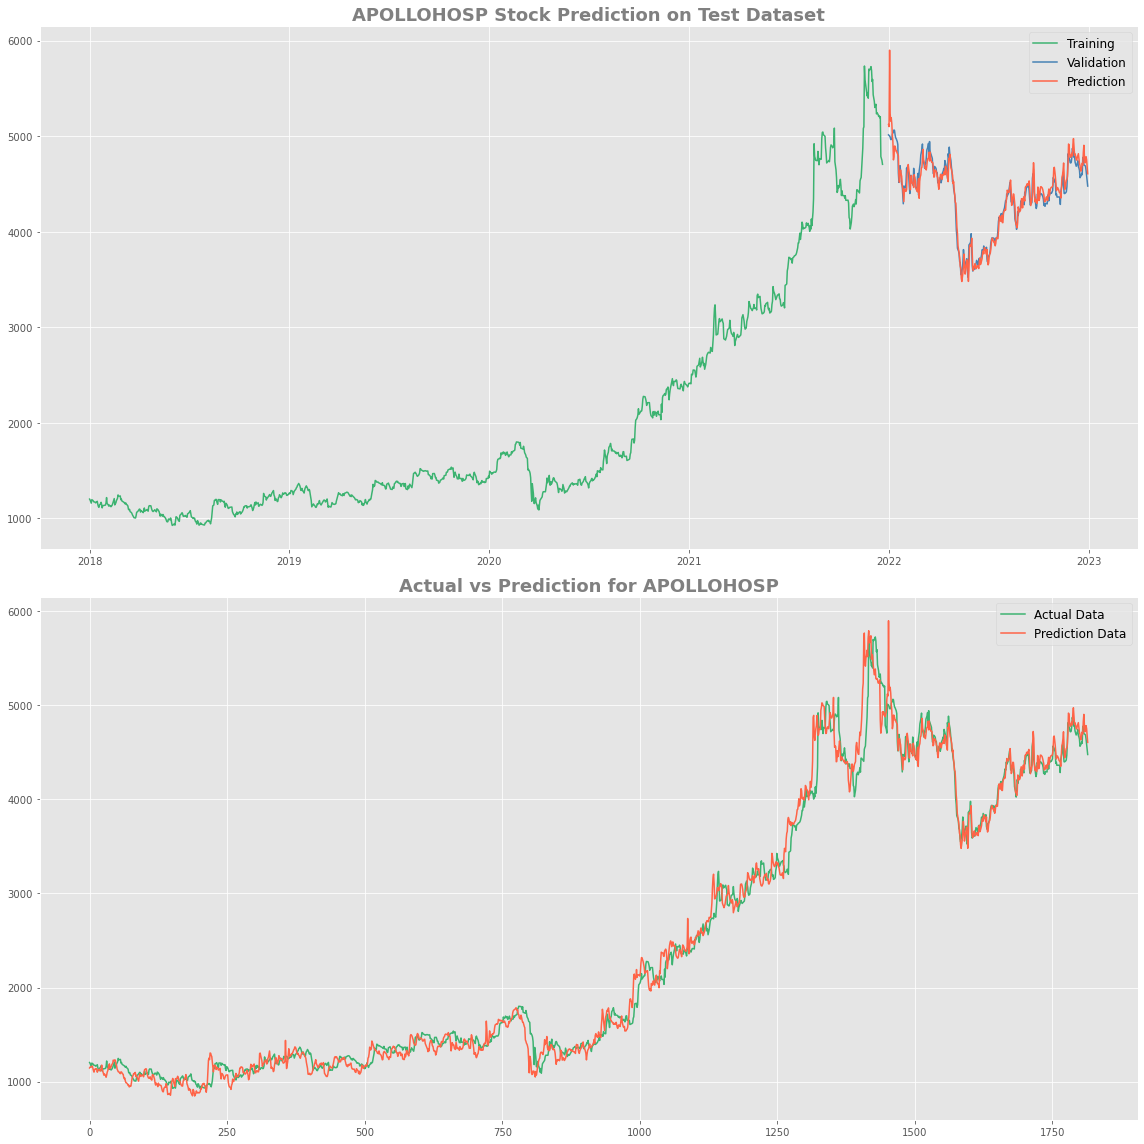

In [149]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[1] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[1]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[1]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[1]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("APOLLOHOSP_Sent.jpg")
plt.show()

#### 5.4.3 Visualizing Results for 'JSWSTEEL'

In [150]:
valid.loc[:,'Pred'] = y_preds[2]

trn_idx_l = 2*trn_len
trn_idx_h = trn_idx_l + trn_len
tst_idx_l = 2*test_len
tst_idx_h = tst_idx_l + test_len

pred_train = model_f.predict(x_train[trn_idx_l:trn_idx_h])
pred_train = scalers[2].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[2])
acts = np.append(train[labels[2]].values, y_test[tst_idx_l:tst_idx_h])

46/46 [==============================] - 0s 8ms/step


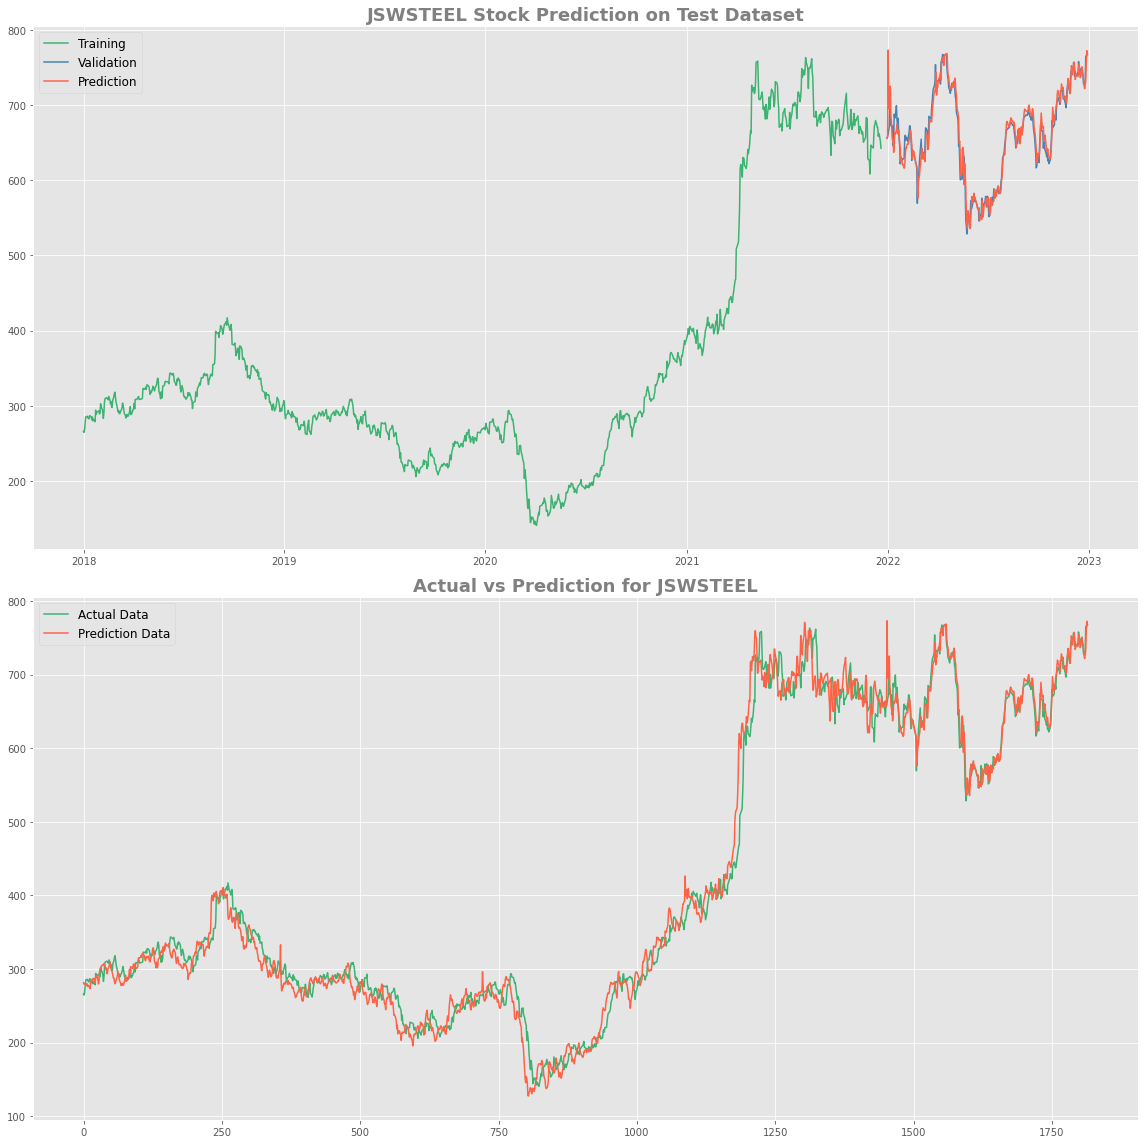

In [151]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[2] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[2]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[2]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[2]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("JSWSTEEL_Sent.jpg")
plt.show()

#### 5.4.4 Visualizing Results for 'RELIANCE'

In [152]:
valid.loc[:,'Pred'] = y_preds[3]

trn_idx_l = 3*trn_len
trn_idx_h = trn_idx_l + trn_len
tst_idx_l = 3*test_len
tst_idx_h = tst_idx_l + test_len

pred_train = model_f.predict(x_train[trn_idx_l:trn_idx_h])
pred_train = scalers[3].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[3])
acts = np.append(train[labels[3]].values, y_test[tst_idx_l:tst_idx_h])

46/46 [==============================] - 0s 9ms/step


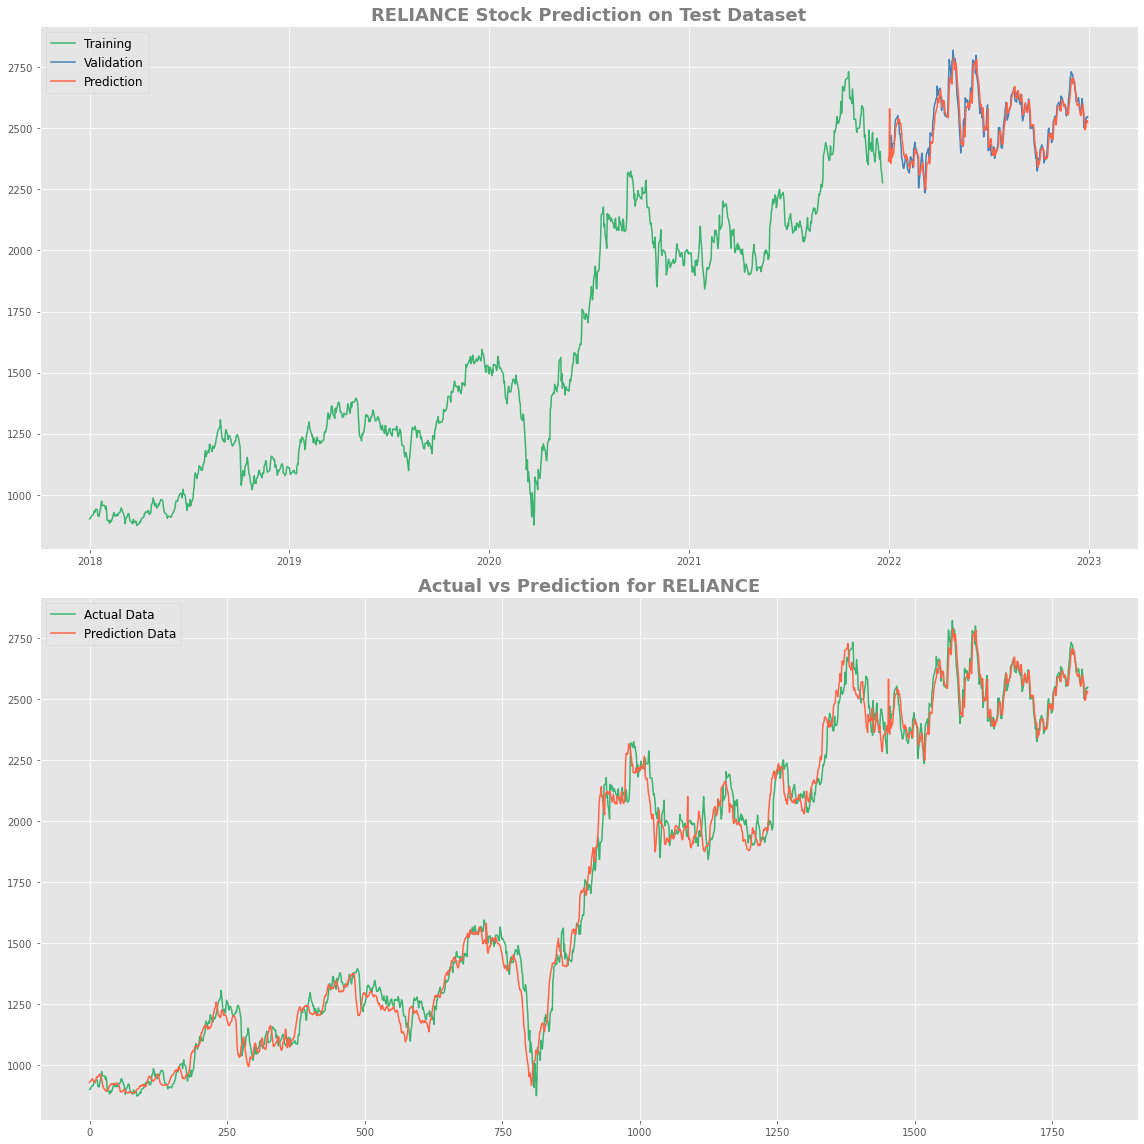

In [153]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[3] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[3]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[3]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[3]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("RELIANCE_Sent.jpg")
plt.show()

#### 5.4.5 Visualizing Results for 'ADANIPORTS'

In [154]:
valid.loc[:,'Pred'] = y_preds[4]

trn_idx_l = 4*trn_len
trn_idx_h = trn_idx_l + trn_len
tst_idx_l = 4*test_len
tst_idx_h = tst_idx_l + test_len

pred_train = model_f.predict(x_train[trn_idx_l:trn_idx_h])
pred_train = scalers[4].inverse_transform(pred_train)
preds = np.append(pred_train, y_preds[4])
acts = np.append(train[labels[4]].values, y_test[tst_idx_l:tst_idx_h])

46/46 [==============================] - 0s 9ms/step


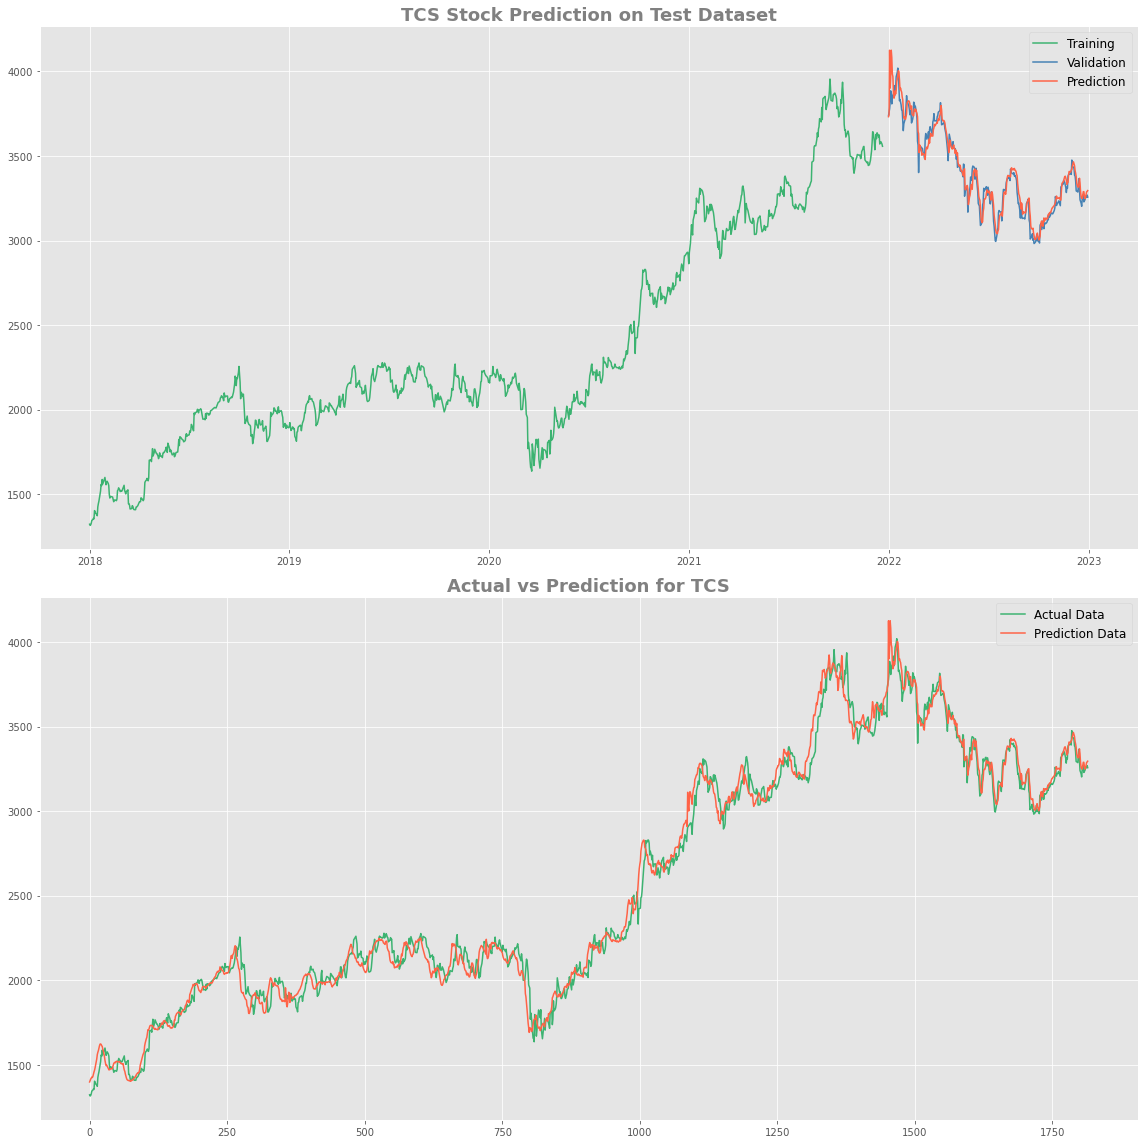

In [155]:
fig, axes = plt.subplots(2,1,figsize=(16,16))

title = labels[4] + " Stock Prediction on Test Dataset"
axes[0].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[0].plot(train[labels[4]], 
             label='Training', 
             color='mediumseagreen')

axes[0].plot(valid[labels[4]], 
             label='Validation', 
             color='steelblue')

axes[0].plot(valid['Pred'], 
             label='Prediction',
             color='tomato')

axes[0].legend(fontsize=12)

title = "Actual vs Prediction for " + labels[4]
axes[1].set_title(title,
                  fontsize=18,
                  fontweight='bold',
                  color='grey')

axes[1].plot(acts,
             color = 'mediumseagreen',
             label='Actual Data')

axes[1].plot(preds,
             color = 'tomato',
             label='Prediction Data')

axes[1].legend(fontsize=12)

fig.tight_layout()
# plt.savefig("TCS_Sent.jpg")
plt.show()

#### 5.4.6 Comparing Model Evaluation Metrics

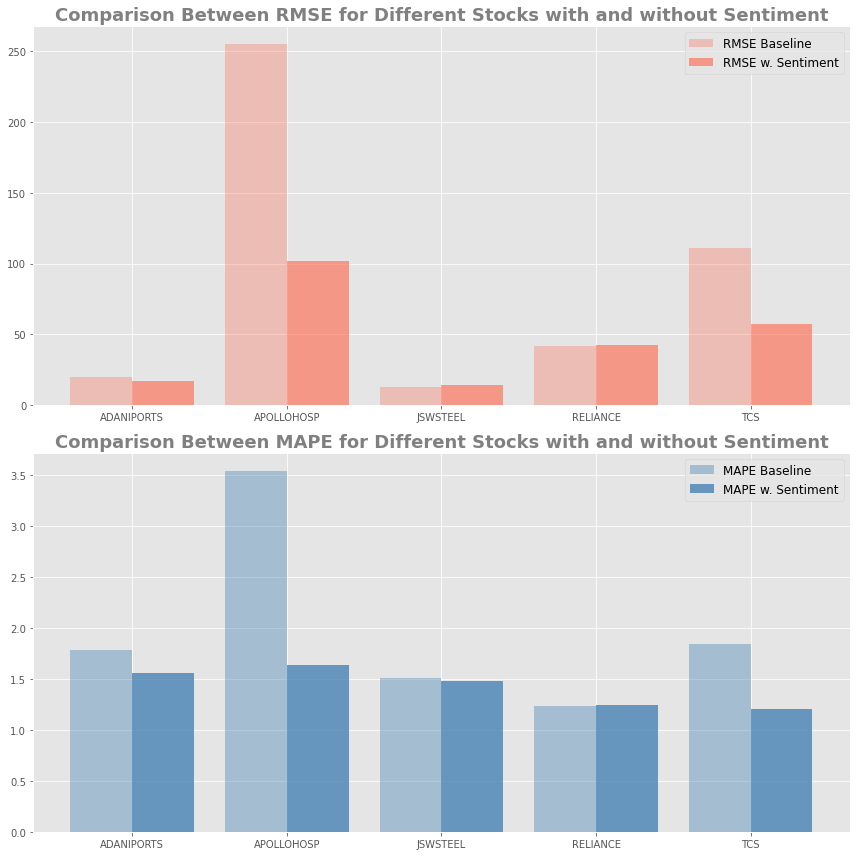

In [156]:
fig, ax = plt.subplots(2,1,figsize=(12,12))

w = 0.4
x = np.arange(len(metrics_df['Stock']))

ax[0].set_title("Comparison Between RMSE for Different Stocks with and without Sentiment",
                fontsize=18,
                fontweight='bold',
                color='grey')

ax[0].bar(x-w/2,
          metrics_df['RMSE'],
          color='tomato',
          alpha=0.3,
          width=w,
          label='RMSE Baseline')

ax[0].bar(x+w/2,
          metrics_df2['RMSE'],
          color='tomato',
          alpha=0.6,
          width=w,
          label='RMSE w. Sentiment')

ax[0].set_xticks(x)
ax[0].set_xticklabels(list(metrics_df['Stock'].values))
ax[0].legend(loc='upper right',
             fontsize=12)

ax[1].set_title("Comparison Between MAPE for Different Stocks with and without Sentiment",
                fontsize=18,
                fontweight='bold',
                color='grey')

ax[1].bar(x-w/2,
          metrics_df['MAPE'],
          color='steelblue',
          alpha=0.4,
          width=w,
          label="MAPE Baseline")

ax[1].bar(x+w/2,
          metrics_df2['MAPE'],
          color='steelblue',
          alpha=0.8,
          width=w,
          label="MAPE w. Sentiment")

ax[1].set_xticks(x)
ax[1].set_xticklabels(list(metrics_df2['Stock'].values))
ax[1].legend(loc='upper right',
             fontsize=12)

fig.tight_layout()
# plt.savefig("RMSE_MAPE_Sent.jpg")
plt.show()

The two graphs above show that the model performed markedly better when augmented with the sentiment scores. This shows that the stock prices can be predicted with greater accuracy with the help of sentiment analysis.